#**Assessing the Efficacy of Permutation Entropy and Complexity Analysis for Discriminating Heavy Drinking from Sober Cases**
---


###*Done By: Surya Vinay Kumar*

## **Introduction**

The objective of this project is to explore and analyze a dataset sourced from the UCI Machine Learning Repository, specifically the "Bar Crawl: Detecting Heavy Drinking" dataset. This dataset comprises detailed information collected from participants engaged in bar-crawl events, with a focus on detecting instances of heavy drinking based on various recorded factors.

The first phase of the project involves a comprehensive understanding of the dataset provided. This includes data exploration, preprocessing, and feature analysis to gain insights into the nature of the dataset and its underlying characteristics.

Subsequently, the project aims to investigate the applicability and reliability of permutation entropy and complexity methods in differentiating between cases of heavy drinking and sober behavior.

Permutation entropy and complexity are sophisticated techniques used in time series analysis and signal processing to assess the irregularity and complexity of data patterns.

Through this investigation, we seek to evaluate the effectiveness of these methods in accurately classifying and distinguishing heavy drinking episodes from instances of sobriety. The future scope of this study will contribute towards advancing methods for detecting and understanding alcohol-related behaviors using computational machine learning approaches and signal analysis techniques.

The project will proceed with a structured analysis pipeline, integrating data preprocessing, feature engineering, model development, and performance evaluation to achieve the research objectives outlined above. The findings from this study have the potential to inform future studies on alcohol-related behaviors and contribute to the development of data-driven approaches for behavioral analysis and intervention.

More details and datasets can be found [here](https://archive.ics.uci.edu/dataset/515/bar+crawl+detecting+heavy+drinking).

##**Step 1: Importing libraries**

Before we start coding, let us first import all the required libraries and connect to google drive for this project.

In [1]:
from google.colab import drive
from google.colab import files
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import plotly.express as px
import os
import warnings
import math
warnings.filterwarnings("ignore")
drive.mount('/content/drive')
%cd /content/drive/MyDrive/FDA/Dataset/Project 2

Mounted at /content/drive
/content/drive/MyDrive/FDA/Dataset/Project 2


##**Step 2: Loading accelerometer data for all pids**


In [2]:
acc_df = pd.read_csv('all_accelerometer_data_pids_13.csv')
acc_df.head()

time     pid       x       y       z
0              0  JB3156  0.0000  0.0000  0.0000
1              0  CC6740  0.0000  0.0000  0.0000
2  1493733882409  SA0297  0.0758  0.0273 -0.0102
3  1493733882455  SA0297 -0.0359  0.0794  0.0037
4  1493733882500  SA0297 -0.2427 -0.0861 -0.0163

It is imperative for us to thoroughly explore and understand the dataset before proceeding with our analysis. Key details such as column names, value distributions, and ranges of variables are essential to note. Let us now embark on our Exploratory Data Analysis (EDA) to gain valuable insights and prepare our data for further analysis.

In [3]:
acc_df.shape

(14057567, 5)

In [4]:
acc_df.head()

time     pid       x       y       z
0              0  JB3156  0.0000  0.0000  0.0000
1              0  CC6740  0.0000  0.0000  0.0000
2  1493733882409  SA0297  0.0758  0.0273 -0.0102
3  1493733882455  SA0297 -0.0359  0.0794  0.0037
4  1493733882500  SA0297 -0.2427 -0.0861 -0.0163

##**Step 2: Seconds conversion**

The next critical task is to merge an additional table containing TAC (Transdermal Alcohol Concentration) values with our existing accelerometer data. The TAC values play a crucial role in determining whether a person is sober at any given timestamp.

These TAC values are sourced from 13 separate tables, each corresponding to a unique participant identified by a PID (Participant ID). The dataset containing these tables can be accessed using the link provided.

Given that there are 13 distinct participants in this experiment, each with their own table, our primary objective is to merge the PID table (containing TAC values) with the accelerometer table. This integration will enable us to correlate accelerometer readings with TAC values across all participants.

However, there is a challenge to overcome before merging these tables: the discrepancy in timestamp units. The timestamps in the accelerometer table are recorded in milliseconds, whereas those in the PID table are recorded in seconds.

Therefore, our initial step involves converting the timestamp values from milliseconds to seconds to ensure compatibility between the two datasets. Once this conversion is complete, we can proceed with merging the tables based on the timestamp column, facilitating a comprehensive analysis of accelerometer data in conjunction with TAC measurements.

This data integration process is crucial for gaining insights into how accelerometer readings correlate with TAC levels, which is fundamental for understanding the behavioral patterns associated with alcohol consumption among participants.

In [5]:
acc_df['time'] = acc_df['time']//1000

In [6]:
acc_df = acc_df.rename(columns={'time': 'timestamp'})
acc_df['timestamp'] = acc_df['timestamp'].astype(str)
acc_df.head()

timestamp     pid       x       y       z
0           0  JB3156  0.0000  0.0000  0.0000
1           0  CC6740  0.0000  0.0000  0.0000
2  1493733882  SA0297  0.0758  0.0273 -0.0102
3  1493733882  SA0297 -0.0359  0.0794  0.0037
4  1493733882  SA0297 -0.2427 -0.0861 -0.0163

##**Step 3: Loading PID data**

Next, we will proceed to load the PID data. I have stored all the necessary files in Google Drive, from which we will extract the required data. By reading the CSV files and converting them into DataFrame format, we can easily access and manipulate the data.

To simplify the process, I have developed a code snippet that directly retrieves the PID from the input file name. This ensures efficient extraction and organization of participant-specific data for further analysis.

In [7]:
%cd /content/drive/MyDrive/FDA/Dataset/Project 2/clean_tac

/content/drive/MyDrive/FDA/Dataset/Project 2/clean_tac


In [51]:
def file_retrieval(file_name):
  print("###########################################################################################################")
  print("File Retrieval started")
  pid = pd.read_csv(file_name)        # reading PID file
  pid_name = file_name.split('_')[0]  # creating a variable to store pid name
  print("PID: ",pid_name)
  print("File Retrieval finished")
  return pid_name, pid
# pid_name, pid = file_retrieval(file_name)

##**Step 3: Filtering PID**

Now that we have obtained the PID data and ensured that the timestamp columns are aligned and compatible between the accelerometer and PID datasets, our next objective is to merge these tables based on the 'timestamp' column. This merge operation will allow us to consolidate the data and retrieve the common rows corresponding to each participant.

In [142]:
def pid_filter(pid,pid_name):
  print("PID filtering started")
  pid['timestamp'] = pid['timestamp'].astype(str)                   # changing the data type of timestamp column
  merged_pid = pd.merge(acc_df,pid,on = 'timestamp')                # merging tables on timestamp column
  condition = merged_pid['pid'] == pid_name                         # filtering rows based on PID
  merged_pid = merged_pid[condition]                                # applying the above condition
  print("Total number of rows are: ", len(merged_pid['timestamp']))
  print("PID filtering ended")
  return merged_pid
# merged_pid = pid_filter(pid, pid_name)

##**Step 4: Analysing accelerometer data**

Before proceeding with the calculation of permutation entropy and complexity, it's crucial to thoroughly examine and address any potential data discrepancies. As indicated in the accompanying text file of the dataset, it's noted that the data was collected at a frequency of 40Hz.

To ensure consistency and accuracy in our analysis, we need to align our dataset with this sampling rate. Therefore, we will divide the dataset size by 40. This adjustment compensates for the difference in data collection frequency and enables us to appropriately handle the dataset within the context of the 40Hz sampling rate.

In [191]:
def graph(merged_pid):
  print("Plotting time stamp vs dimension graph")
  time = np. arange(merged_pid['x'].size)/40
  fig, ax = plt.subplots(4, figsize=(15,8))
  plt.xlabel ("Time in seconds")
  ax[0]. plot(time, "x" ,data=merged_pid)
  # ax[0] .label(y="x axis")
  ax[1]. plot(time, "y", data=merged_pid)
  # plt.ylabel("y axis")
  ax[2].plot(time, "z", data=merged_pid)
  # plt.ylabel("z axis")
  ax[3]. plot(time, 'TAC_Reading', data=merged_pid)
  ax[3].axhline(y=0.08, color='r', linestyle='-')
  plt.show()
  print("Plotting completed")
  return time
# time = graph(merged_pid)

##**Step 5: Calculating Permutation Entropy and Complexity**

In [192]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''
import numpy as np


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])


def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

##**Step 6: Calculating Length**

This preprocessing step is critical for our project. We will begin by dividing our input dataset into three separate datasets corresponding to the x, y, and z accelerometer values. Subsequently, we will sort each of these datasets based on time and tac values to prepare for the calculation of permutation entropy (PE) and Complexity.

This initial sorting and separation will ensure that our data is appropriately organized and ready for the subsequent analytical steps. Let's proceed with this essential preprocessing phase.

In [145]:
def length_of_segment(merged_df):
  df_sample_x = pd.DataFrame({'time': time, 'x':merged_pid['x'], 'tac':merged_pid['TAC_Reading']})    # Creating a table for acc_x
  df_sample_x = df_sample_x.sort_values(by=['time', 'tac'], ascending=True)                           # sorting values
  df_sample_x = df_sample_x.reset_index()                                                             # Resetting index

  df_sample_y = pd.DataFrame({'time': time, 'y':merged_pid['y'], 'tac':merged_pid['TAC_Reading']})    # Creating a table for acc_y
  df_sample_y = df_sample_y.sort_values(by=['time', 'tac'], ascending=True)
  df_sample_y = df_sample_y.reset_index()

  df_sample_z = pd.DataFrame({'time': time, 'z':merged_pid['z'], 'tac':merged_pid['TAC_Reading']})    # Creating a table for acc_z
  df_sample_z = df_sample_z.sort_values(by=['time', 'tac'], ascending=True)
  df_sample_z = df_sample_z.reset_index()

  return df_sample_x, df_sample_y, df_sample_z
# df_sample_x,df_sample_y, df_sample_z = length_of_segment(merged_pid)

To segment the dataset based on changes in the TAC values, we begin by sorting the dataset by time and TAC values. Next, we initialize an empty list called 'segment_length' to store the lengths of each segment determined by consecutive identical TAC values.

We iterate through each row in the 'tac' column and count the number of consecutive rows with the same TAC value. Each count is appended to the 'segment_length' list, representing the length of each segment.

Using the segment lengths from the list, we iterate through and create segments in the dataset. For each segment, we calculate the Permutation Entropy (PE) and Complexity. These metrics provide insights into the regularity and complexity of the accelerometer data within each segment.

Additionally, we create a new column called 'class' to classify whether a person is sober or not at each timestamp. If the TAC value exceeds 0.08, indicating intoxication, the 'class' is marked as 1; otherwise, it is marked as 0.

This segmentation and analysis process is repeated for all three datasets (x, y, z accelerometer values). Finally, we generate various graphs to visualize the output, which can include plots of PE, Complexity, and the classification of sobriety over time.

By following these steps systematically, we can effectively analyze the accelerometer data, identify segments based on TAC changes, and gain insights into the dynamics of sobriety levels represented in the dataset.

In [177]:
def pe_comp_calc(df_sample_x,df_sample_y,df_sample_z):

  print("Calculating permutation entropy and complexity")
  print("Plotting Graphs")
  value_counts = df_sample_x['tac'].value_counts()      # Calculating TAC value repitetion
  segment_length = list(value_counts)                   # Putting all these values in a list
  print("Segment List: ",segment_length)
  pe_results_x = []                                     # Creating empty list
  comp_results_x = []                                   # Creating empty list
  i = 0                                                 # Initializing
  for segment_value in segment_length:                  # Iterating through all the elements in the list
    num_segs = len(df_sample_x['x'])//segment_value     # Calculating number of segments
    if (i == 0):                                        # If condition to calculate start index
      start_index = i * segment_value
    elif( i != 0):
      start_index = end_index
    end_index = start_index + segment_value             # Calculating end index
    segment = df_sample_x['x'][start_index:end_index]   # Creating segment
    op = ordinal_patterns(segment,3,1)                  # Calculating ordinal patterns
    pe = p_entropy(op)                                  # Calculating PE
    comp = complexity(op)                               # Calculating complexity
    pe_results_x.append(pe)                             # Appending PE to a list
    comp_results_x.append(comp)                         # Appending complexity to a list
    i += 1                                              # Incrementing i

  fig, axes = plt.subplots(1, 2, figsize=(12, 5))       # Creating plots

  sns.lineplot(pe_results_x, ax=axes[0])
  axes[0].set_title('Permutation Entropy for x')

  sns.lineplot(comp_results_x, ax=axes[1])
  axes[1].set_title('Complexity for x')

  plt.tight_layout()
  plt.show()

  print("Starting Post Processing for df_sample_x")
  pp_x = pd.DataFrame(df_sample_x['tac'].drop_duplicates().reset_index(drop=True))    # Post Processing for creating final table
  pp_x['Permutation Entropy'] = np.array(pe_results_x)                                # table PE
  pp_x['Complexity'] = np.array(comp_results_x)                                       # table complexity
  pp_x = pd.merge(df_sample_x, pp_x, on = 'tac')                                      # merging all the tables
  pp_x = pp_x[['time','x','tac','Permutation Entropy','Complexity']]                  # structing the dataset
  pp_x['Class'] = np.where(pp_x['tac'] > 0.08, 1, 0)                                  # creating 'class' column
  pp_x = pp_x.rename(columns = {'time':'Time','tac': 'TAC'})                          # Renaming columns
  print(pp_x)
  print("Post Processing completed for df_sample_x")

  plt.figure(figsize=(10, 6))  # adjust figure size if needed
  plt.scatter(pp_x['Complexity'], pp_x['Permutation Entropy'], s=pp_x['TAC']*500, c=pp_x['Class'], alpha=0.7, cmap='viridis')  # alpha for transparency, cmap for color map
  plt.colorbar(label='Class')  # add color scale based on the colormap
  plt.xlabel('Complexity')  # label for x-axis
  plt.ylabel('Permutation Entropy')  # label for y-axis
  plt.title('Complexity vs Permuation Entropy for all TAC readings')  # plot title
  plt.grid(True)  # show grid lines
  plt.show()

    #############################################################

  pe_results_y = []
  comp_results_y = []
  i = 0

  for segment_value in segment_length:
    num_segs = len(df_sample_y['y'])//segment_value
    if (i == 0):
      start_index = i * segment_value
    elif( i != 0):
      start_index = end_index
    end_index = start_index + segment_value
    segment = df_sample_y['y'][start_index:end_index]
    op = ordinal_patterns(segment,3,1)
    pe = p_entropy(op)
    comp = complexity(op)
    pe_results_y.append(pe)
    comp_results_y.append(comp)
    i += 1

  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  sns.lineplot(pe_results_y, ax=axes[0])
  axes[0].set_title('Permutation Entropy for y')

  sns.lineplot(comp_results_y, ax=axes[1])
  axes[1].set_title('Complexity for y')

  plt.tight_layout()
  plt.show()

  print("Starting Post Processing for df_sample_y")
  pp_y = pd.DataFrame(df_sample_y['tac'].drop_duplicates().reset_index(drop=True))
  pp_y['Permutation Entropy'] = np.array(pe_results_y)
  pp_y['Complexity'] = np.array(comp_results_y)
  pp_y = pd.merge(df_sample_y, pp_y, on = 'tac')
  pp_y = pp_y[['time','y','tac','Permutation Entropy','Complexity']]
  pp_y['Class'] = np.where(pp_y['tac'] > 0.08, 1, 0)
  pp_y = pp_y.rename(columns = {'time':'Time','tac': 'TAC'})
  print(pp_y)
  print("Post Processing completed for df_sample_y")

  plt.figure(figsize=(10, 6))  # adjust figure size if needed
  plt.scatter(pp_y['Complexity'], pp_y['Permutation Entropy'], s=pp_y['TAC']*500, c=pp_y['Class'], alpha=0.7, cmap='viridis')  # alpha for transparency, cmap for color map
  plt.colorbar(label='Class')  # add color scale based on the colormap
  plt.xlabel('Complexity')  # label for x-axis
  plt.ylabel('Permutation Entropy')  # label for y-axis
  plt.title('Complexity vs Permuation Entropy for all TAC readings')  # plot title
  plt.grid(True)  # show grid lines
  plt.show()


    ############################################################

  pe_results_z = []
  comp_results_z = []
  i = 0
  for segment_value in segment_length:
    num_segs = len(df_sample_z['z'])//segment_value
    # for i in range (num_segs):
    if (i == 0):
      start_index = i * segment_value
    elif( i != 0):
      start_index = end_index
    end_index = start_index + segment_value
    segment = df_sample_z['z'][start_index:end_index]
    op = ordinal_patterns(segment,3,1)
    pe = p_entropy(op)
    comp = complexity(op)
    pe_results_z.append(pe)
    comp_results_z.append(comp)
    i += 1

  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  sns.lineplot(pe_results_z, ax=axes[0])
  axes[0].set_title('Permutation Entropy for z')

  sns.lineplot(comp_results_z, ax=axes[1])
  axes[1].set_title('Complexity for z')

  plt.tight_layout()
  plt.show()

  print("Starting Post Processing for df_sample_z")
  pp_z = pd.DataFrame(df_sample_z['tac'].drop_duplicates().reset_index(drop=True))
  pp_z['Permutation Entropy'] = np.array(pe_results_z)
  pp_z['Complexity'] = np.array(comp_results_z)
  pp_z = pd.merge(df_sample_z, pp_z, on = 'tac')
  pp_z = pp_z[['time','z','tac','Permutation Entropy','Complexity']]
  pp_z['Class'] = np.where(pp_z['tac'] > 0.08, 1, 0)
  pp_z = pp_z.rename(columns = {'time':'Time','tac': 'TAC'})
  print(pp_z)
  print("Post Processing completed for df_sample_z")

  plt.figure(figsize=(10, 6))  # adjust figure size if needed
  plt.scatter(pp_z['Complexity'], pp_z['Permutation Entropy'], s=pp_z['TAC']*500, c=pp_z['Class'], alpha=0.7, cmap='viridis')  # alpha for transparency, cmap for color map
  plt.colorbar(label='Class')  # add color scale based on the colormap
  plt.xlabel('Complexity')  # label for x-axis
  plt.ylabel('Permutation Entropy')  # label for y-axis
  plt.title('Complexity vs Permuation Entropy for all TAC readings')  # plot title
  plt.grid(True)  # show grid lines
  plt.show()


  print("Plotting Scatter Plot")

    ###########################################################


  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  sns.lineplot(pe_results_x, label = 'acc_x', ax=axes[0])
  sns.lineplot(pe_results_y, label = 'acc_y', ax=axes[0])
  sns.lineplot(pe_results_z, label = 'acc_z', ax=axes[0])
  axes[0].set_title('Permutation Entropy of acc_x,acc_y, acc_z')
  axes[0].legend()

  sns.lineplot(comp_results_x, label = 'acc_x', ax=axes[1])
  sns.lineplot(comp_results_y, label = 'acc_y', ax=axes[1])
  sns.lineplot(comp_results_z, label = 'acc_z', ax=axes[1])
  axes[1].set_title('Complexity of acc_x,acc_y, acc_z')
  axes[1].legend()

  plt.tight_layout()
  plt.show()
  print("Graphs plotted successfully")
  # return pe_results_x, comp_results_x

  print("###########################################################################################################")
# pe_comp_calc(segment_length,df_sample_x,df_sample_y,df_sample_z)

## **Step 7: Performing calculations for all PIDs**

Having completed all necessary calculations, we are now ready to compute Permutation Entropy (PE) and Complexity for each PID in our dataset. This comprehensive analysis will provide valuable insights into the dynamics of the data across different individuals.

To proceed, we will systematically solve for PE and Complexity for each PID, leveraging the segmented data and relevant metrics. Subsequently, we will generate and plot the appropriate graphs to visualize the results effectively.

By conducting this analysis across all PIDs, we aim to uncover patterns, trends, and variations within the dataset, shedding light on the complexity of the accelerometer readings over time.

Let's proceed with solving PE and Complexity for all PIDs and visualizing the outcomes through relevant graphs.

1.) PID: BK7610

###########################################################################################################
File Retrieval started
PID:  BK7610
File Retrieval finished
PID filtering started
Total number of rows are:  674
PID filtering ended
Plotting time stamp vs dimension graph


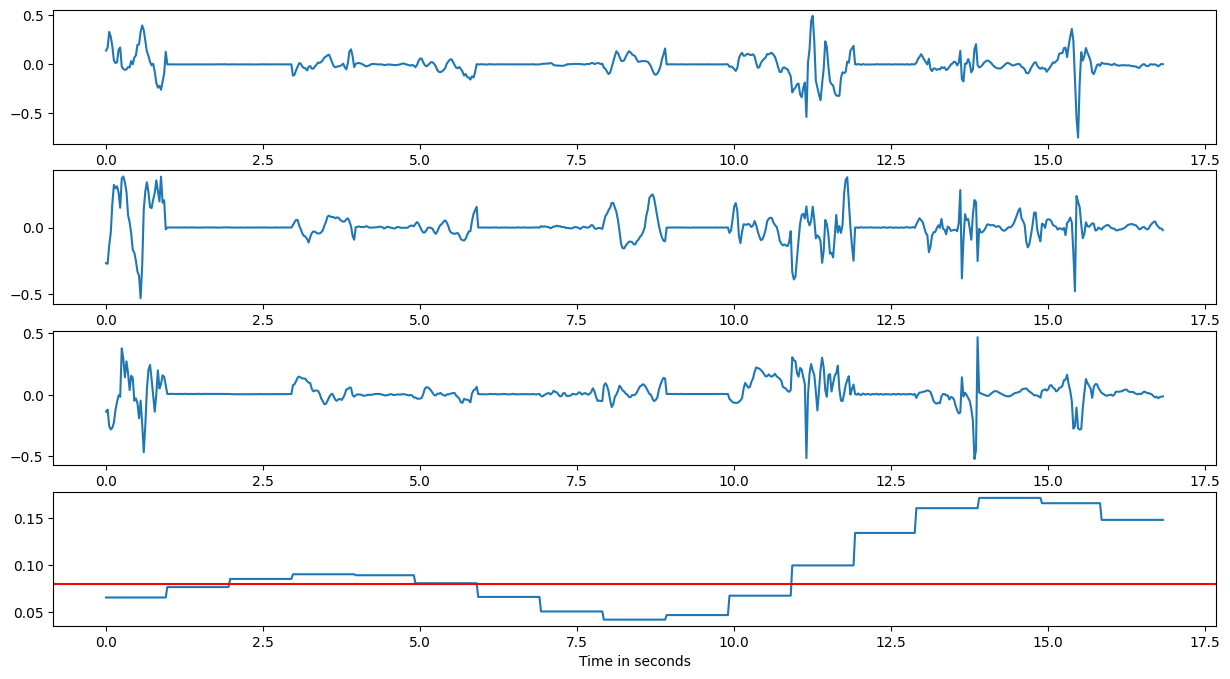

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 39, 39, 38, 38]


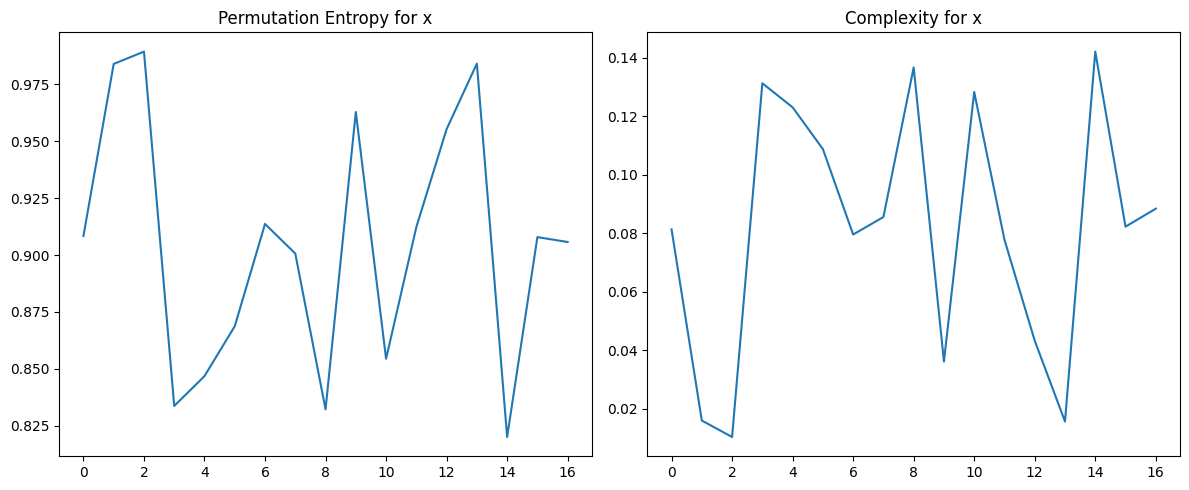

Starting Post Processing for df_sample_x
       Time       x       TAC  Permutation Entropy  Complexity  Class
0     0.000  0.1410  0.065357             0.908377    0.081307      0
1     0.025  0.1714  0.065357             0.908377    0.081307      0
2     0.050  0.3328  0.065357             0.908377    0.081307      0
3     0.075  0.2822  0.065357             0.908377    0.081307      0
4     0.100  0.1847  0.065357             0.908377    0.081307      0
..      ...     ...       ...                  ...         ...    ...
669  16.725 -0.0073  0.148265             0.905719    0.088389      1
670  16.750 -0.0191  0.148265             0.905719    0.088389      1
671  16.775 -0.0090  0.148265             0.905719    0.088389      1
672  16.800  0.0048  0.148265             0.905719    0.088389      1
673  16.825  0.0012  0.148265             0.905719    0.088389      1

[674 rows x 6 columns]
Post Processing completed for df_sample_x


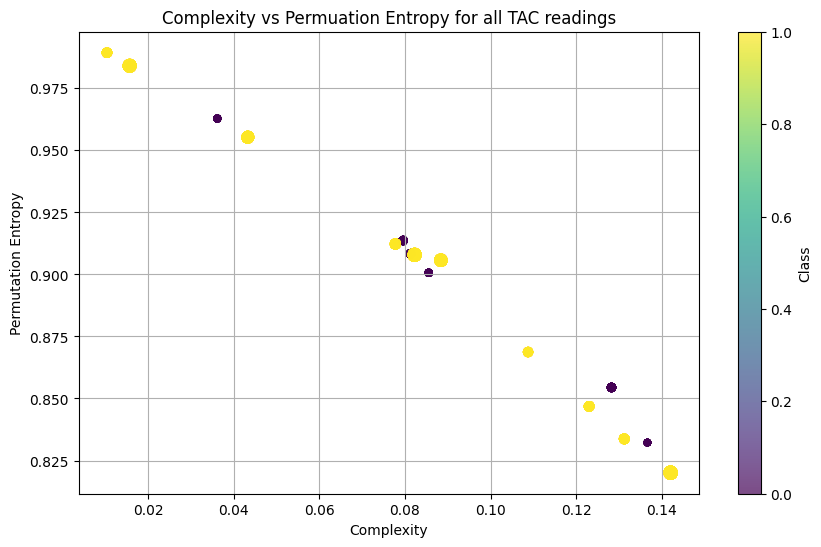

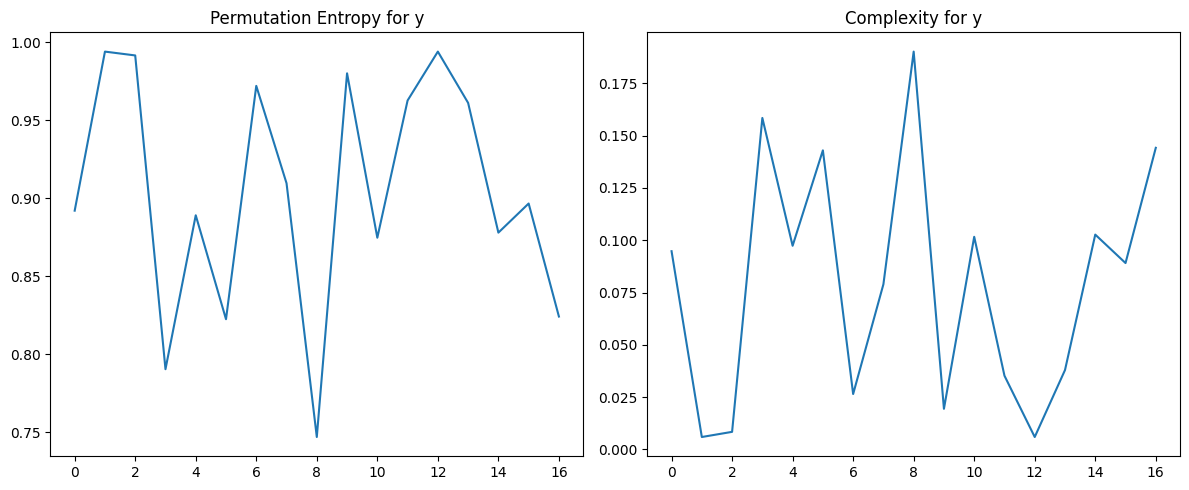

Starting Post Processing for df_sample_y
       Time       y       TAC  Permutation Entropy  Complexity  Class
0     0.000 -0.2686  0.065357             0.891948    0.094747      0
1     0.025 -0.2722  0.065357             0.891948    0.094747      0
2     0.050 -0.1353  0.065357             0.891948    0.094747      0
3     0.075 -0.0375  0.065357             0.891948    0.094747      0
4     0.100  0.1813  0.065357             0.891948    0.094747      0
..      ...     ...       ...                  ...         ...    ...
669  16.725  0.0220  0.148265             0.824085    0.144169      1
670  16.750  0.0071  0.148265             0.824085    0.144169      1
671  16.775 -0.0069  0.148265             0.824085    0.144169      1
672  16.800 -0.0064  0.148265             0.824085    0.144169      1
673  16.825 -0.0193  0.148265             0.824085    0.144169      1

[674 rows x 6 columns]
Post Processing completed for df_sample_y


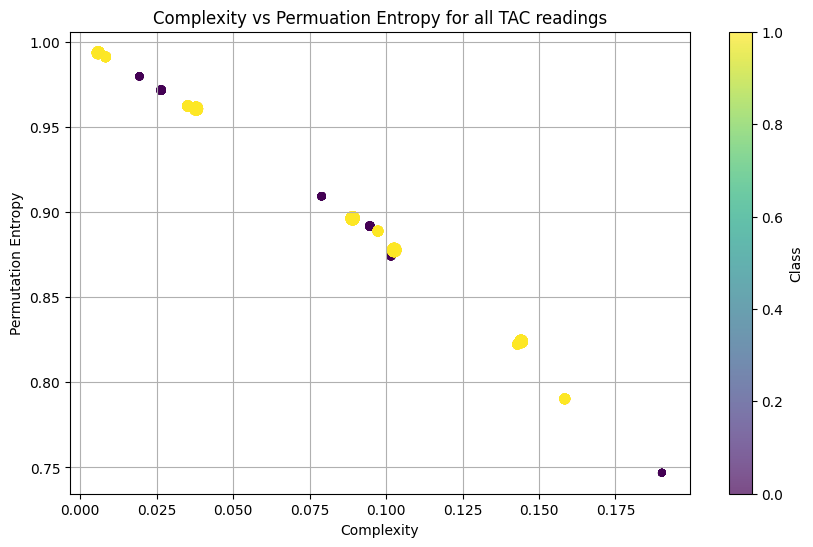

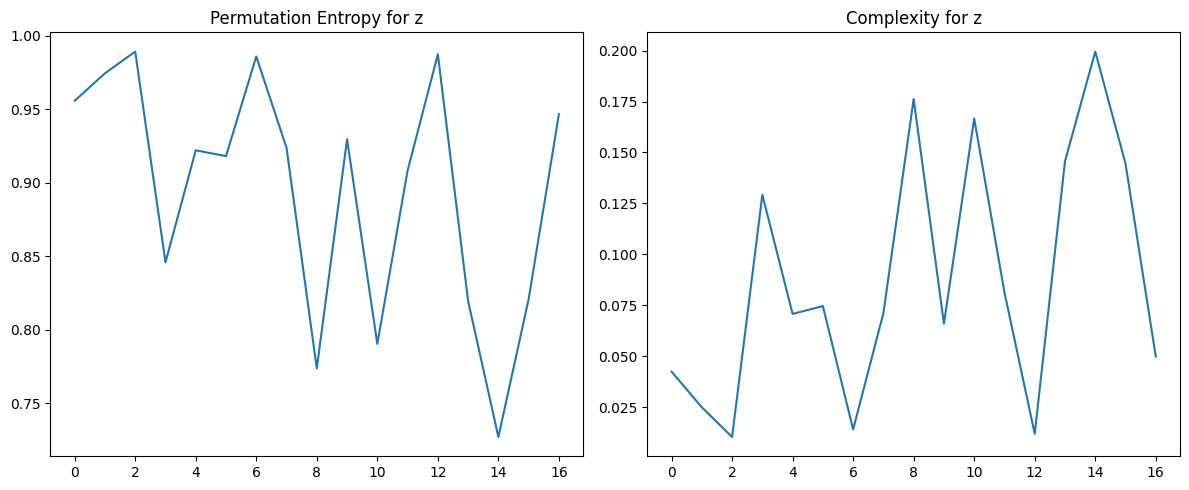

Starting Post Processing for df_sample_z
       Time       z       TAC  Permutation Entropy  Complexity  Class
0     0.000 -0.1372  0.065357             0.955915    0.042437      0
1     0.025 -0.1208  0.065357             0.955915    0.042437      0
2     0.050 -0.2548  0.065357             0.955915    0.042437      0
3     0.075 -0.2816  0.065357             0.955915    0.042437      0
4     0.100 -0.2680  0.065357             0.955915    0.042437      0
..      ...     ...       ...                  ...         ...    ...
669  16.725 -0.0166  0.148265             0.946758    0.049820      1
670  16.750 -0.0289  0.148265             0.946758    0.049820      1
671  16.775 -0.0188  0.148265             0.946758    0.049820      1
672  16.800 -0.0164  0.148265             0.946758    0.049820      1
673  16.825 -0.0132  0.148265             0.946758    0.049820      1

[674 rows x 6 columns]
Post Processing completed for df_sample_z


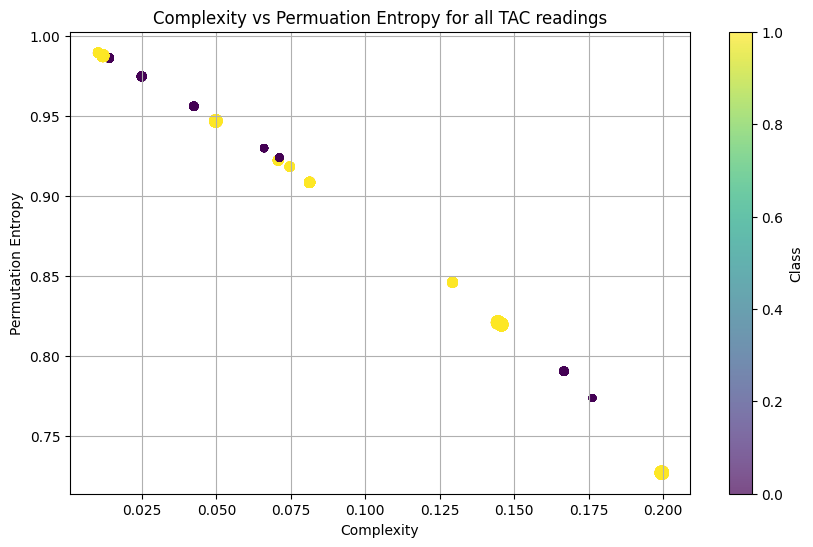

Plotting Scatter Plot


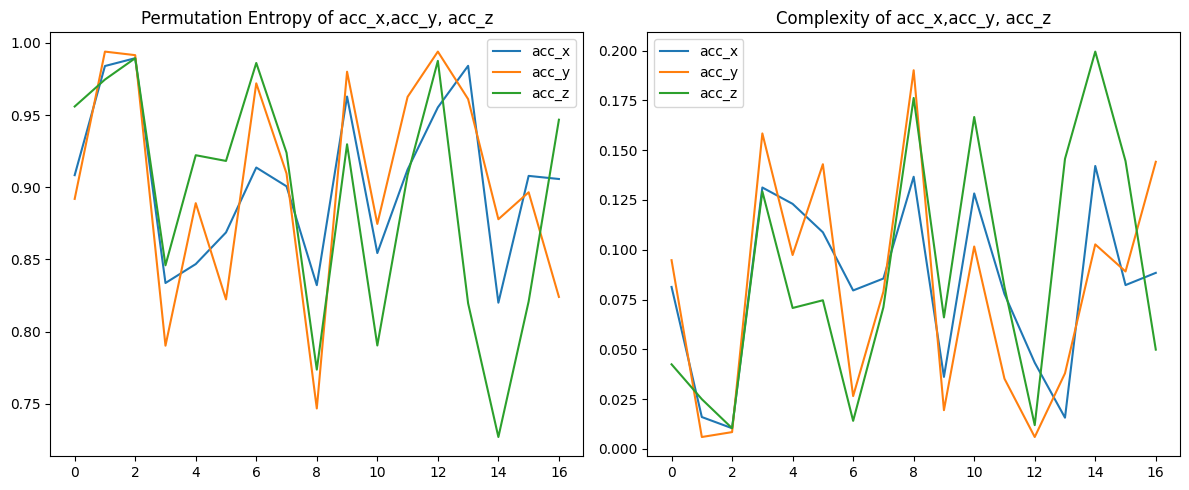

Graphs plotted successfully
###########################################################################################################


In [178]:
pid_name, pid = file_retrieval('BK7610_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

# plot scatter plot on entropy - x, complexity - y, tac values as size of bubble and 0,1 (classes) are the colors

2.) PID: BU4704

###########################################################################################################
File Retrieval started
PID:  BU4707
File Retrieval finished
PID filtering started
Total number of rows are:  237
PID filtering ended
Plotting time stamp vs dimension graph


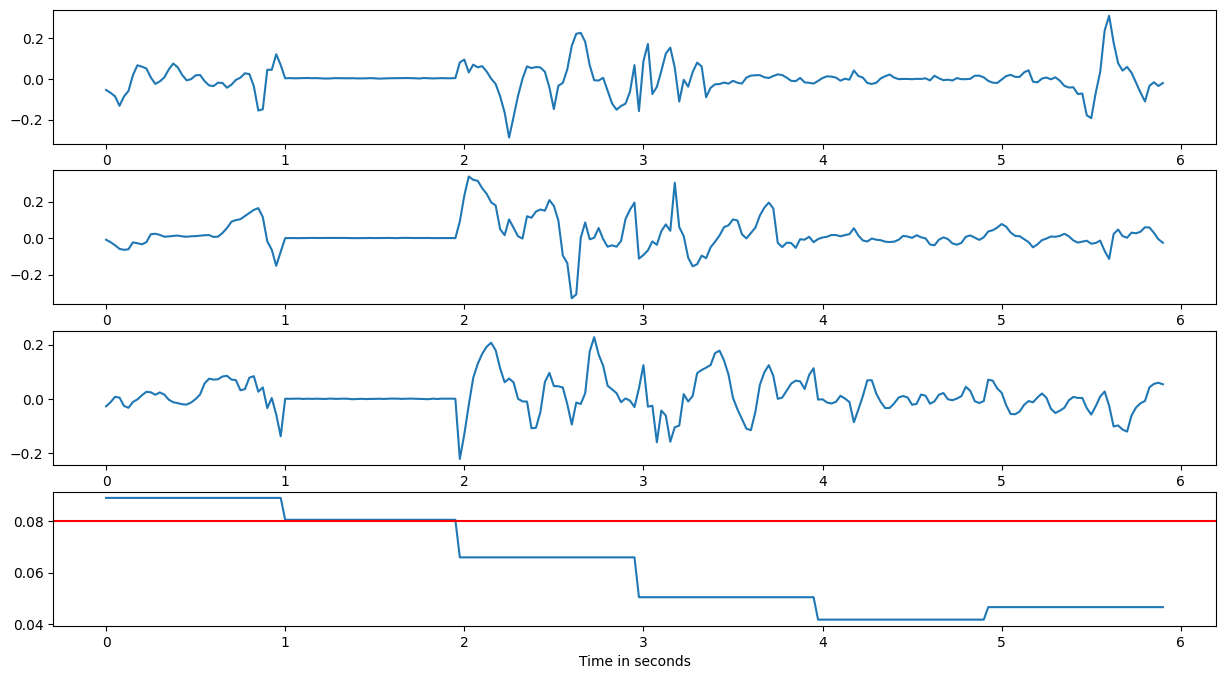

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [40, 40, 40, 40, 39, 38]


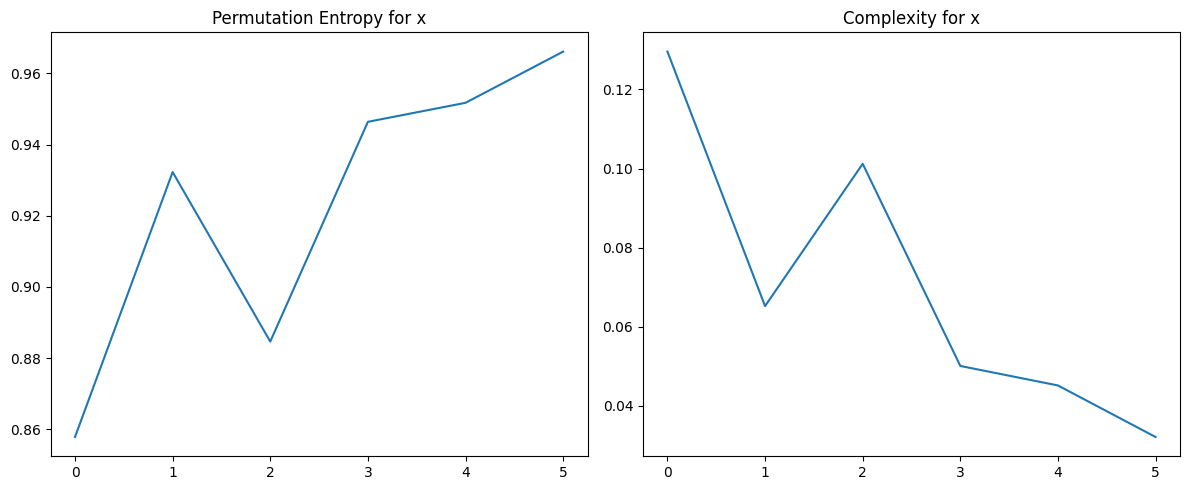

Starting Post Processing for df_sample_x
      Time       x       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0548  0.089122             0.857823    0.129546      1
1    0.025 -0.0686  0.089122             0.857823    0.129546      1
2    0.050 -0.0858  0.089122             0.857823    0.129546      1
3    0.075 -0.1324  0.089122             0.857823    0.129546      1
4    0.100 -0.0867  0.089122             0.857823    0.129546      1
..     ...     ...       ...                  ...         ...    ...
232  5.800 -0.1110  0.046559             0.966140    0.032156      0
233  5.825 -0.0346  0.046559             0.966140    0.032156      0
234  5.850 -0.0171  0.046559             0.966140    0.032156      0
235  5.875 -0.0354  0.046559             0.966140    0.032156      0
236  5.900 -0.0208  0.046559             0.966140    0.032156      0

[237 rows x 6 columns]
Post Processing completed for df_sample_x


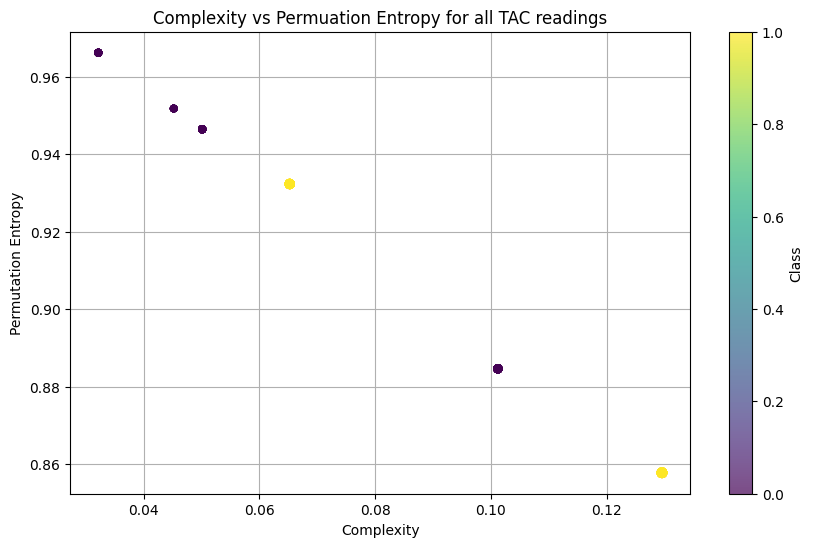

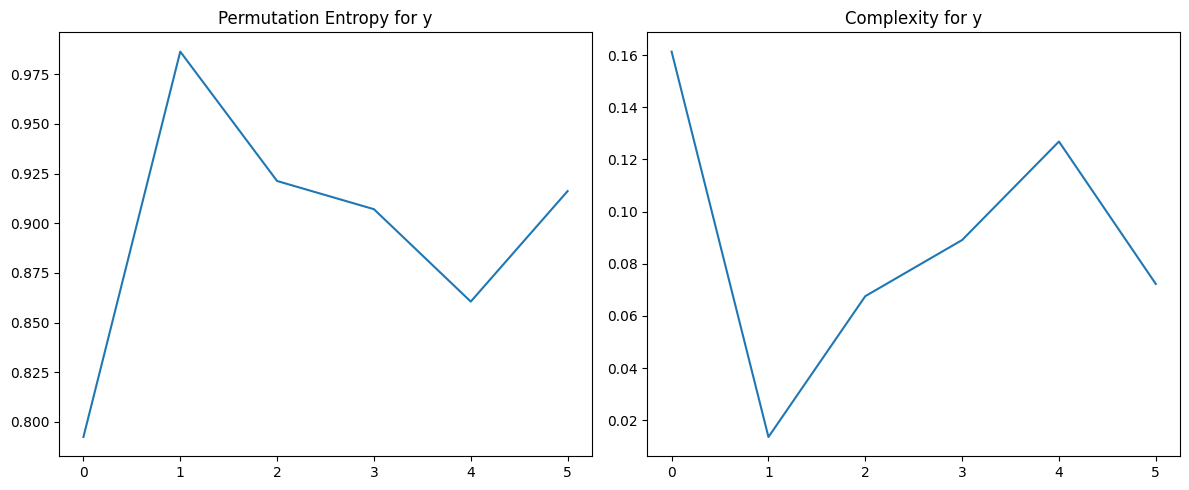

Starting Post Processing for df_sample_y
      Time       y       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0088  0.089122             0.792369    0.161375      1
1    0.025 -0.0223  0.089122             0.792369    0.161375      1
2    0.050 -0.0389  0.089122             0.792369    0.161375      1
3    0.075 -0.0590  0.089122             0.792369    0.161375      1
4    0.100 -0.0643  0.089122             0.792369    0.161375      1
..     ...     ...       ...                  ...         ...    ...
232  5.800  0.0593  0.046559             0.916161    0.072254      0
233  5.825  0.0581  0.046559             0.916161    0.072254      0
234  5.850  0.0288  0.046559             0.916161    0.072254      0
235  5.875 -0.0062  0.046559             0.916161    0.072254      0
236  5.900 -0.0254  0.046559             0.916161    0.072254      0

[237 rows x 6 columns]
Post Processing completed for df_sample_y


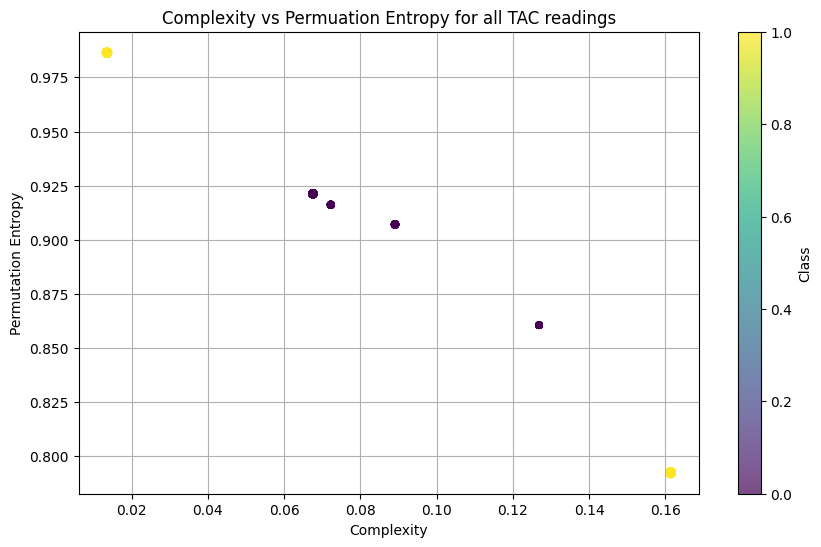

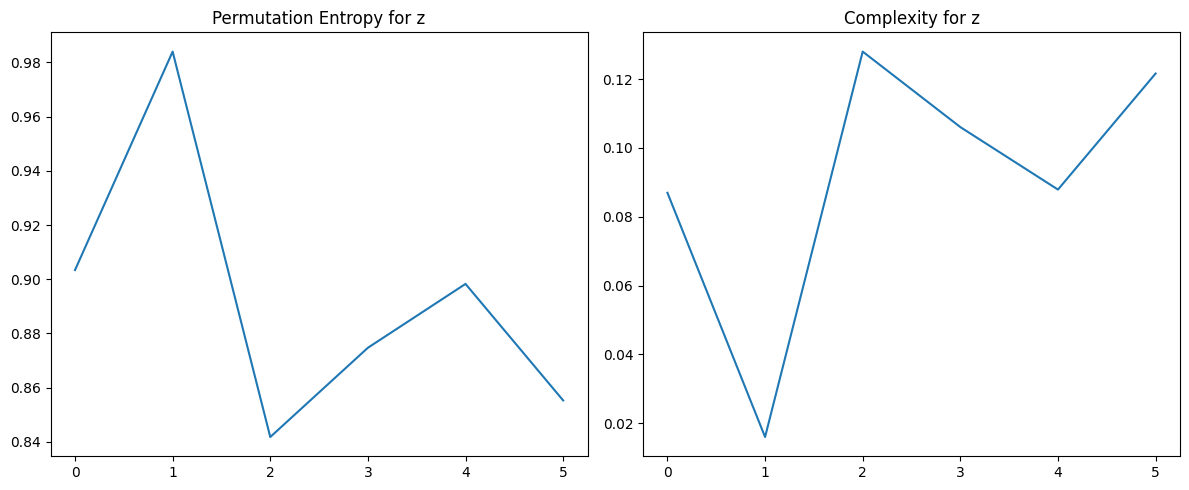

Starting Post Processing for df_sample_z
      Time       z       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0272  0.089122             0.903386    0.086948      1
1    0.025 -0.0121  0.089122             0.903386    0.086948      1
2    0.050  0.0076  0.089122             0.903386    0.086948      1
3    0.075  0.0050  0.089122             0.903386    0.086948      1
4    0.100 -0.0256  0.089122             0.903386    0.086948      1
..     ...     ...       ...                  ...         ...    ...
232  5.800 -0.0076  0.046559             0.855321    0.121610      0
233  5.825  0.0428  0.046559             0.855321    0.121610      0
234  5.850  0.0553  0.046559             0.855321    0.121610      0
235  5.875  0.0595  0.046559             0.855321    0.121610      0
236  5.900  0.0538  0.046559             0.855321    0.121610      0

[237 rows x 6 columns]
Post Processing completed for df_sample_z


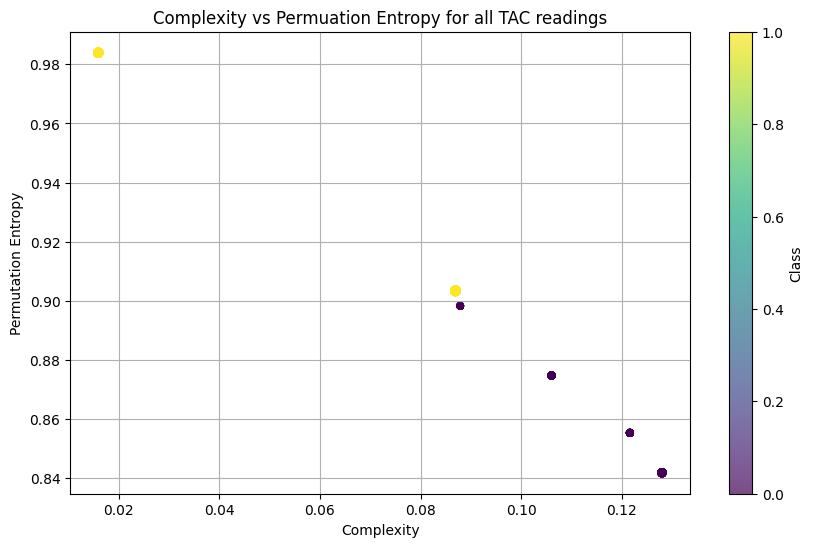

Plotting Scatter Plot


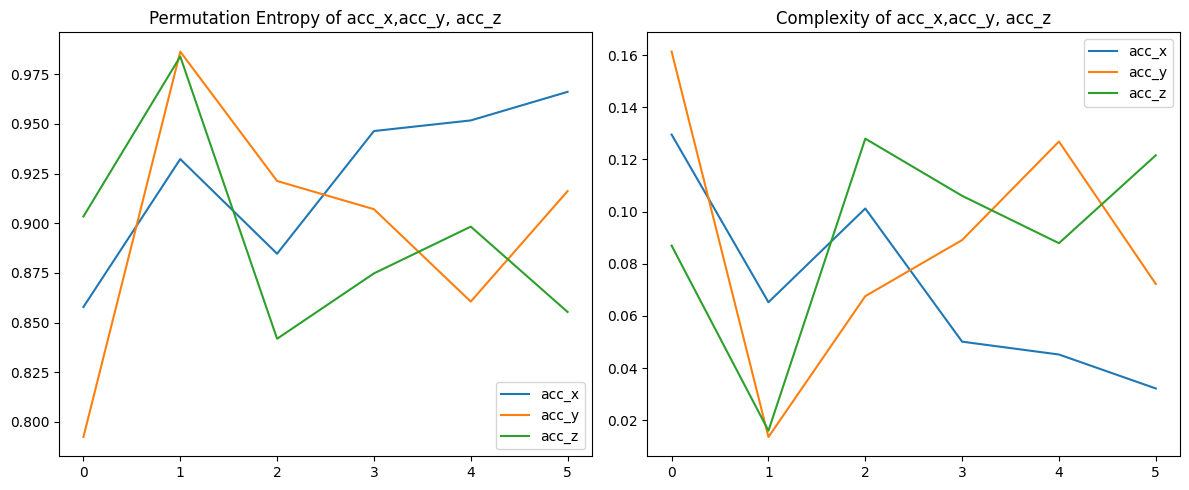

Graphs plotted successfully
###########################################################################################################


In [179]:
pid_name, pid = file_retrieval('BU4707_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

3.) PID: CC6740

###########################################################################################################
File Retrieval started
PID:  CC6740
File Retrieval finished
PID filtering started
Total number of rows are:  831
PID filtering ended
Plotting time stamp vs dimension graph


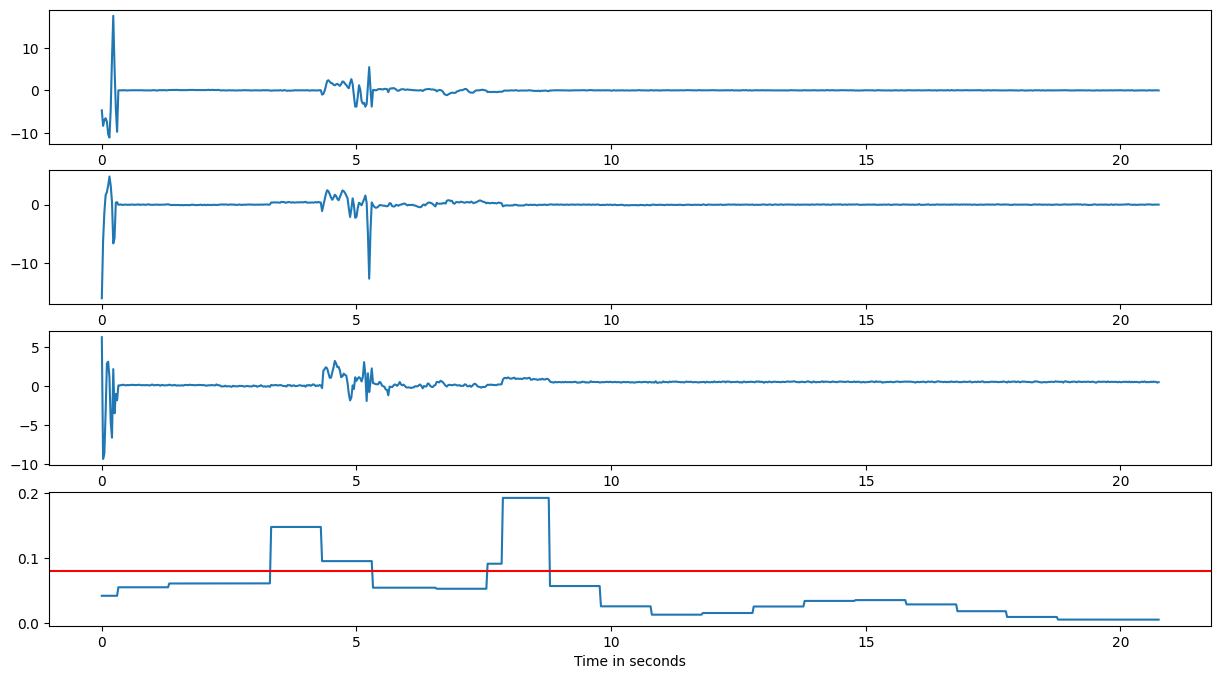

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [50, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 39, 37, 13, 12]


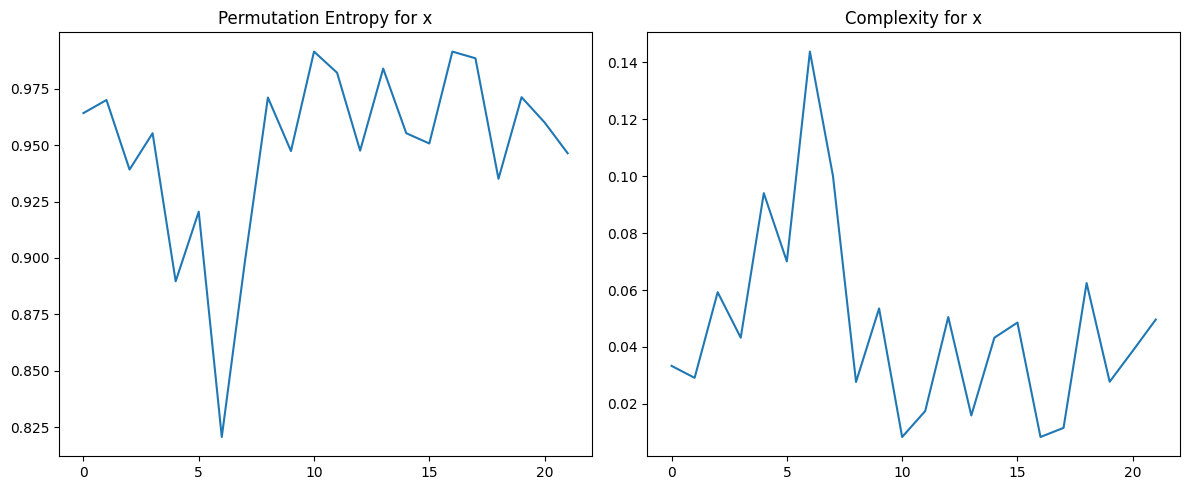

Starting Post Processing for df_sample_x
       Time         x      TAC  Permutation Entropy  Complexity  Class
0     0.000 -4.696118  0.04187             0.964215    0.033372      0
1     0.025 -8.342324  0.04187             0.964215    0.033372      0
2     0.050 -6.992756  0.04187             0.964215    0.033372      0
3     0.075 -6.556036  0.04187             0.964215    0.033372      0
4     0.100 -7.352158  0.04187             0.964215    0.033372      0
..      ...       ...      ...                  ...         ...    ...
826  20.650  0.012896  0.00504             0.946412    0.049641      0
827  20.675 -0.006422  0.00504             0.946412    0.049641      0
828  20.700  0.012401  0.00504             0.946412    0.049641      0
829  20.725  0.012559  0.00504             0.946412    0.049641      0
830  20.750 -0.024973  0.00504             0.946412    0.049641      0

[831 rows x 6 columns]
Post Processing completed for df_sample_x


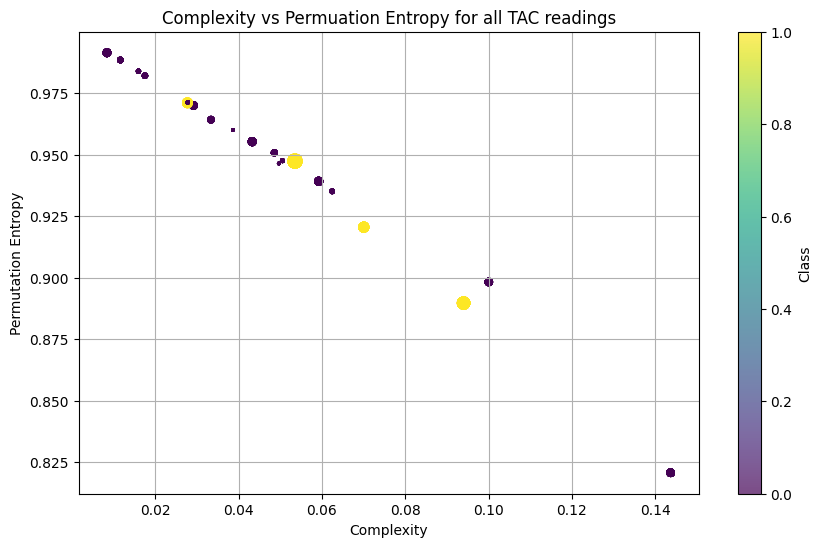

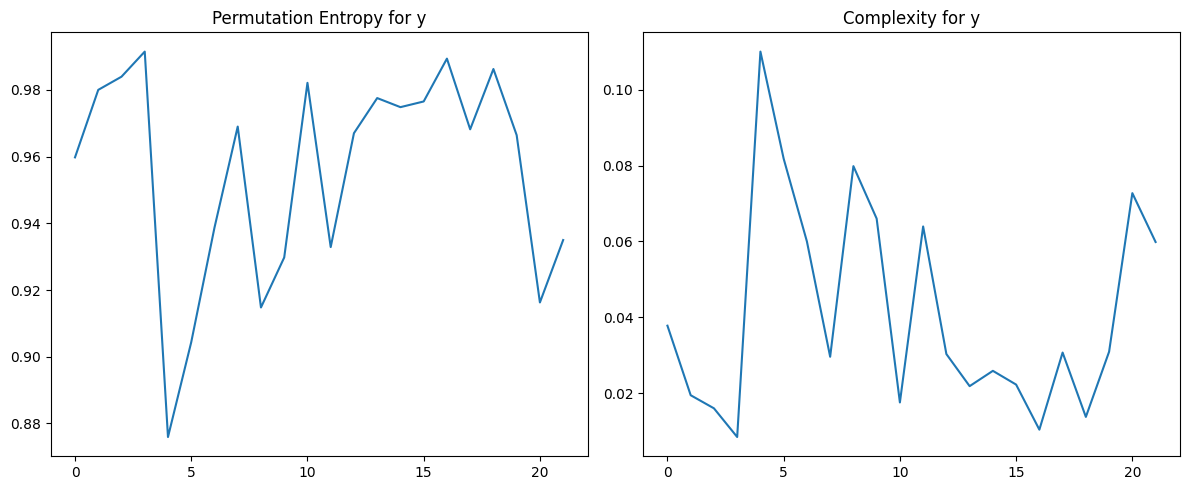

Starting Post Processing for df_sample_y
       Time          y      TAC  Permutation Entropy  Complexity  Class
0     0.000 -16.039703  0.04187             0.959755    0.037759      0
1     0.025  -6.281204  0.04187             0.959755    0.037759      0
2     0.050  -1.318486  0.04187             0.959755    0.037759      0
3     0.075   1.632029  0.04187             0.959755    0.037759      0
4     0.100   2.141843  0.04187             0.959755    0.037759      0
..      ...        ...      ...                  ...         ...    ...
826  20.650  -0.013732  0.00504             0.934978    0.059834      0
827  20.675   0.023981  0.00504             0.934978    0.059834      0
828  20.700   0.004974  0.00504             0.934978    0.059834      0
829  20.725   0.005315  0.00504             0.934978    0.059834      0
830  20.750   0.005600  0.00504             0.934978    0.059834      0

[831 rows x 6 columns]
Post Processing completed for df_sample_y


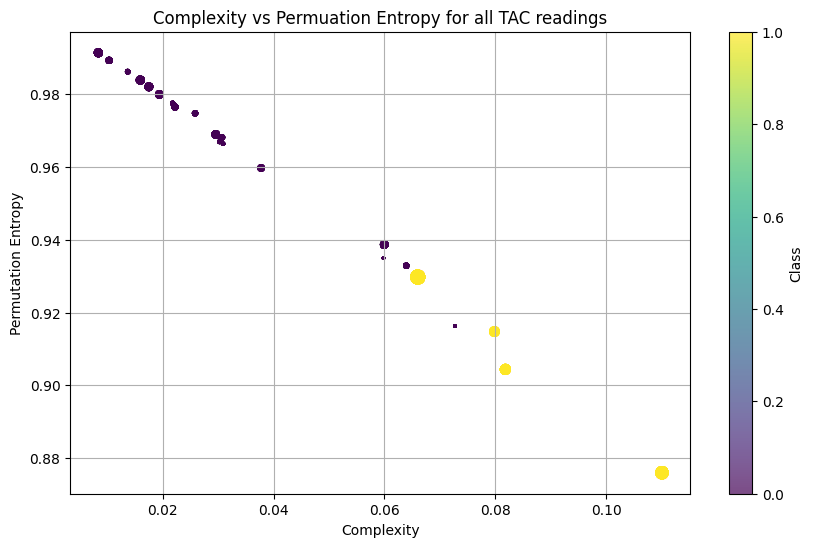

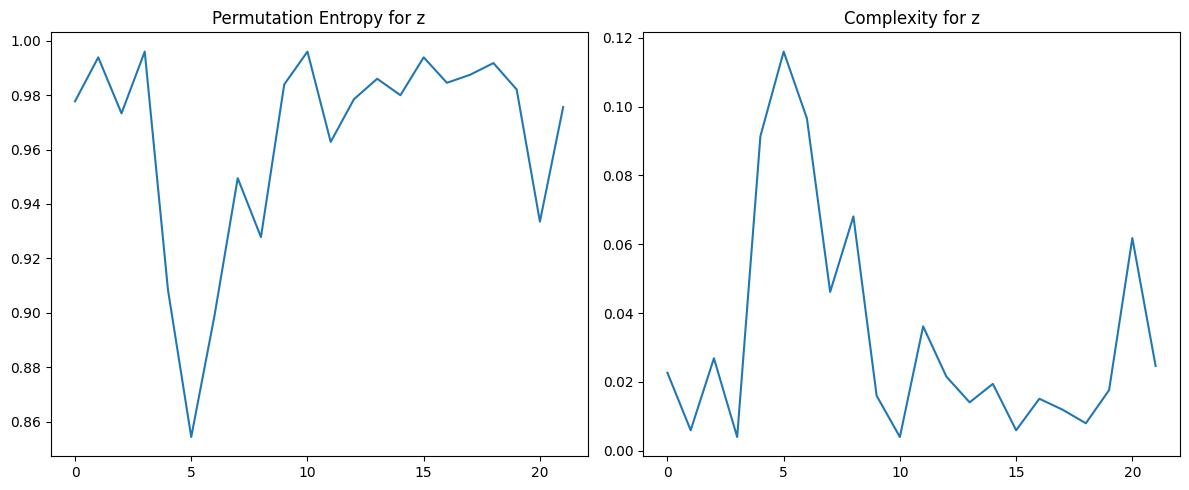

Starting Post Processing for df_sample_z
       Time         z      TAC  Permutation Entropy  Complexity  Class
0     0.000  6.315768  0.04187             0.977725    0.022654      0
1     0.025 -9.354126  0.04187             0.977725    0.022654      0
2     0.050 -8.665682  0.04187             0.977725    0.022654      0
3     0.075 -3.295139  0.04187             0.977725    0.022654      0
4     0.100  2.943863  0.04187             0.977725    0.022654      0
..      ...       ...      ...                  ...         ...    ...
826  20.650  0.604185  0.00504             0.975615    0.024625      0
827  20.675  0.565886  0.00504             0.975615    0.024625      0
828  20.700  0.565885  0.00504             0.975615    0.024625      0
829  20.725  0.470111  0.00504             0.975615    0.024625      0
830  20.750  0.527568  0.00504             0.975615    0.024625      0

[831 rows x 6 columns]
Post Processing completed for df_sample_z


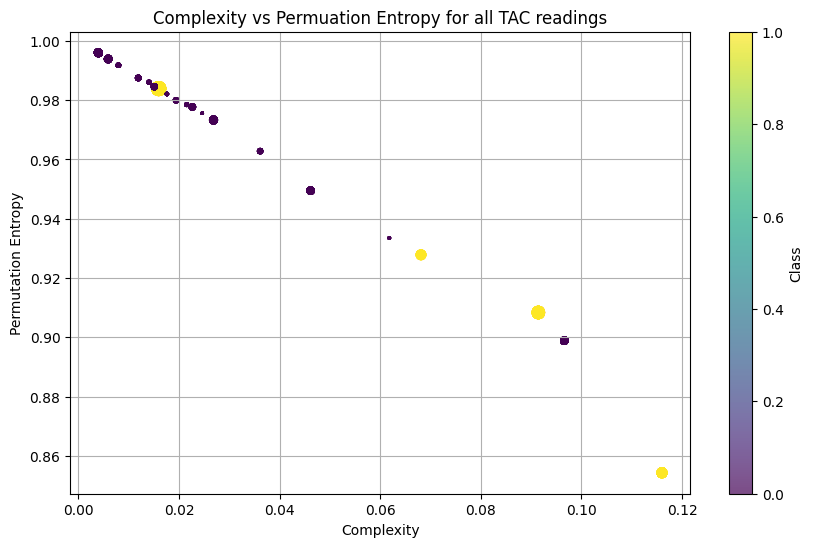

Plotting Scatter Plot


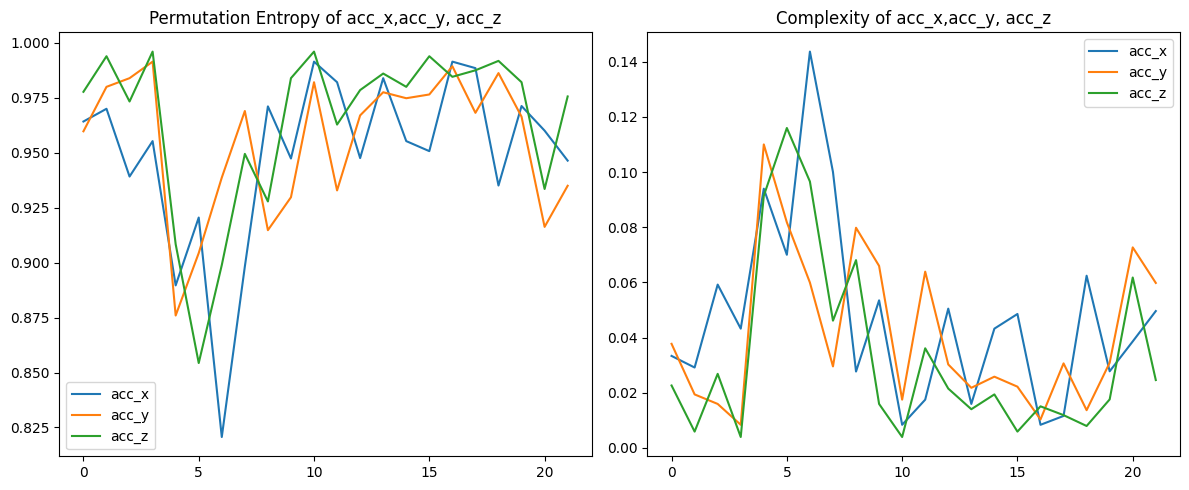

Graphs plotted successfully
###########################################################################################################


In [180]:
pid_name, pid = file_retrieval('CC6740_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

4.) PID: DC6359

###########################################################################################################
File Retrieval started
PID:  DC6359
File Retrieval finished
PID filtering started
Total number of rows are:  304
PID filtering ended
Plotting time stamp vs dimension graph


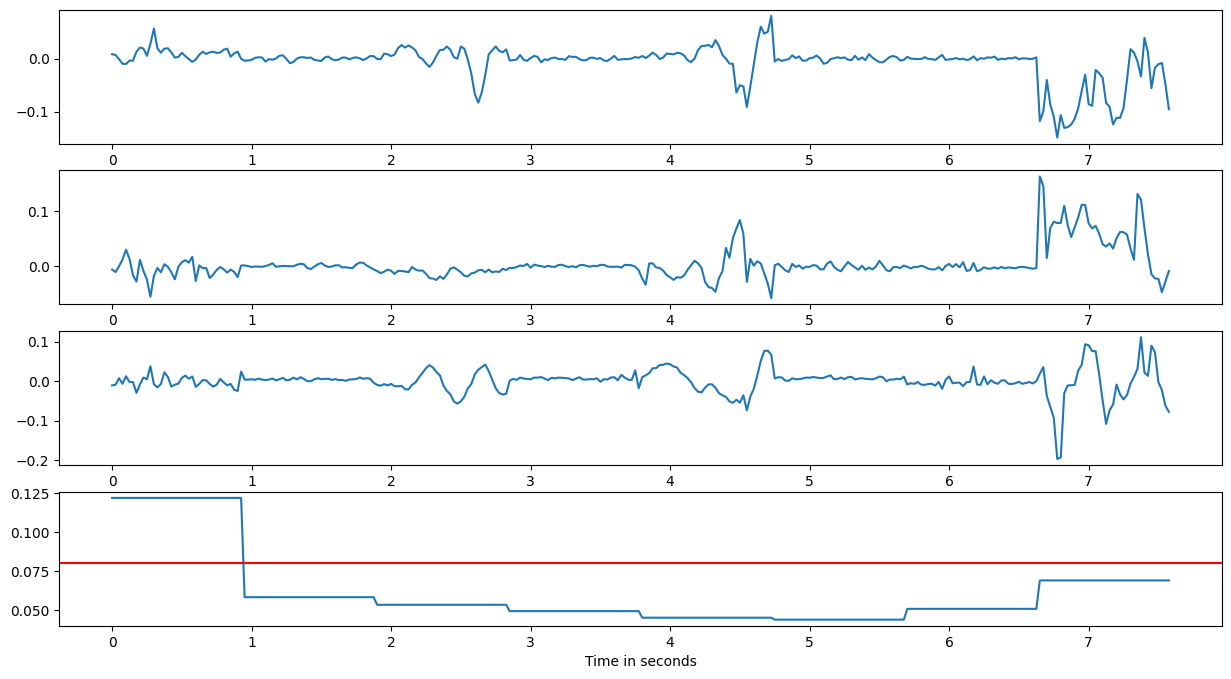

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [38, 38, 38, 38, 38, 38, 38, 38]


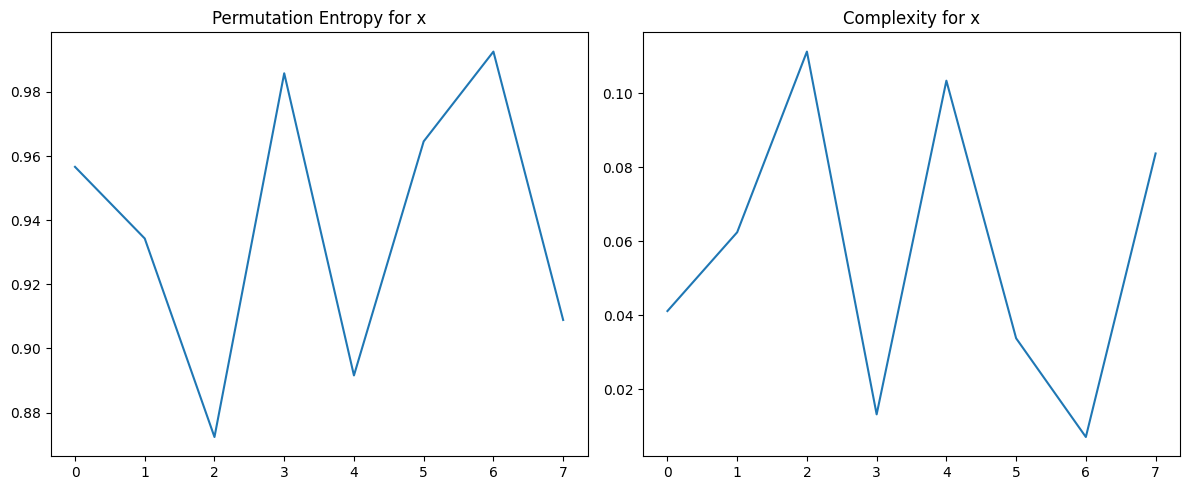

Starting Post Processing for df_sample_x
      Time       x       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.0081  0.122072             0.956641    0.041134      1
1    0.025  0.0069  0.122072             0.956641    0.041134      1
2    0.050 -0.0012  0.122072             0.956641    0.041134      1
3    0.075 -0.0098  0.122072             0.956641    0.041134      1
4    0.100 -0.0103  0.122072             0.956641    0.041134      1
..     ...     ...       ...                  ...         ...    ...
299  7.475 -0.0175  0.068986             0.908885    0.083686      0
300  7.500 -0.0105  0.068986             0.908885    0.083686      0
301  7.525 -0.0083  0.068986             0.908885    0.083686      0
302  7.550 -0.0480  0.068986             0.908885    0.083686      0
303  7.575 -0.0953  0.068986             0.908885    0.083686      0

[304 rows x 6 columns]
Post Processing completed for df_sample_x


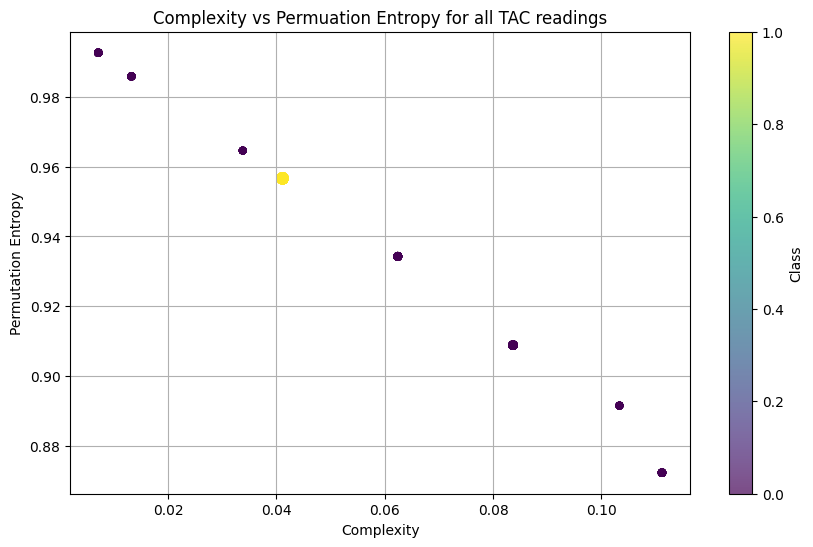

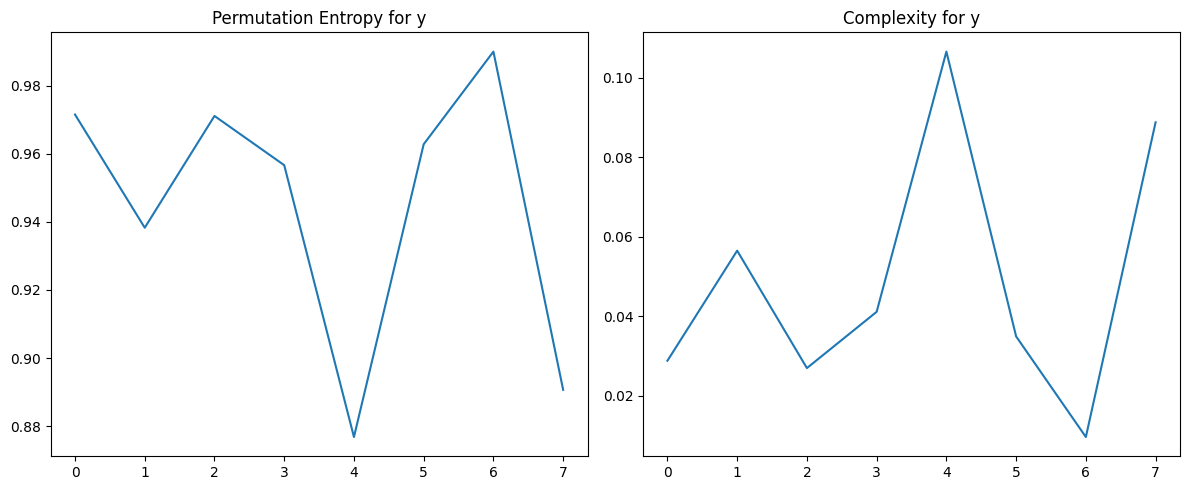

Starting Post Processing for df_sample_y
      Time       y       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0063  0.122072             0.971516    0.028832      1
1    0.025 -0.0109  0.122072             0.971516    0.028832      1
2    0.050 -0.0004  0.122072             0.971516    0.028832      1
3    0.075  0.0121  0.122072             0.971516    0.028832      1
4    0.100  0.0298  0.122072             0.971516    0.028832      1
..     ...     ...       ...                  ...         ...    ...
299  7.475 -0.0225  0.068986             0.890672    0.088809      0
300  7.500 -0.0234  0.068986             0.890672    0.088809      0
301  7.525 -0.0476  0.068986             0.890672    0.088809      0
302  7.550 -0.0286  0.068986             0.890672    0.088809      0
303  7.575 -0.0091  0.068986             0.890672    0.088809      0

[304 rows x 6 columns]
Post Processing completed for df_sample_y


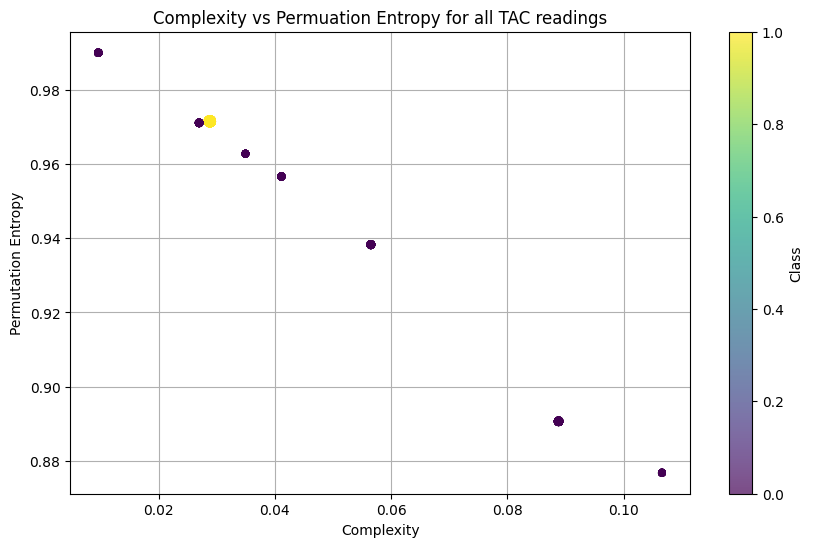

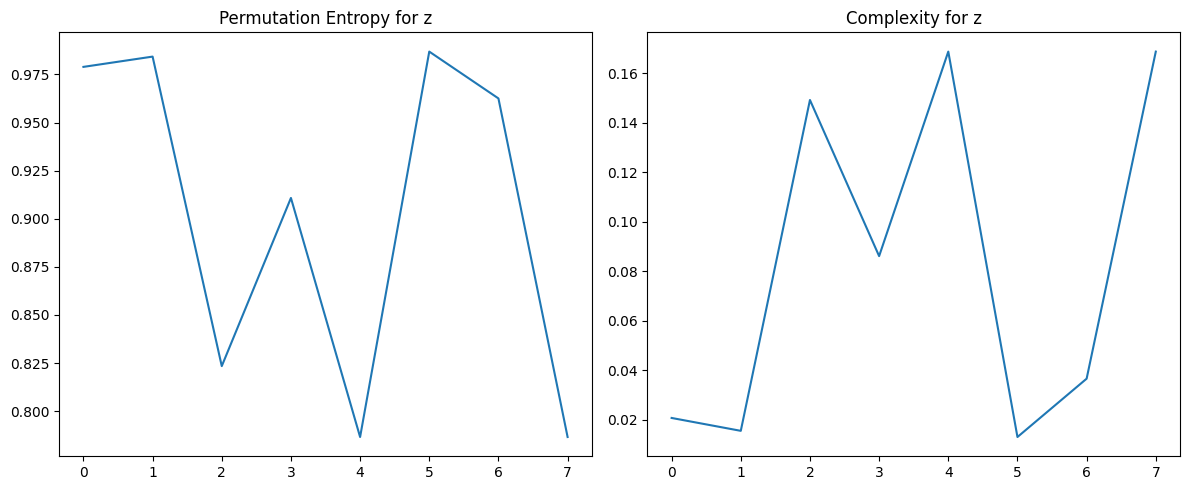

Starting Post Processing for df_sample_z
      Time       z       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0106  0.122072             0.978928    0.020650      1
1    0.025 -0.0092  0.122072             0.978928    0.020650      1
2    0.050  0.0076  0.122072             0.978928    0.020650      1
3    0.075 -0.0065  0.122072             0.978928    0.020650      1
4    0.100  0.0124  0.122072             0.978928    0.020650      1
..     ...     ...       ...                  ...         ...    ...
299  7.475  0.0733  0.068986             0.786588    0.168793      0
300  7.500 -0.0022  0.068986             0.786588    0.168793      0
301  7.525 -0.0226  0.068986             0.786588    0.168793      0
302  7.550 -0.0621  0.068986             0.786588    0.168793      0
303  7.575 -0.0775  0.068986             0.786588    0.168793      0

[304 rows x 6 columns]
Post Processing completed for df_sample_z


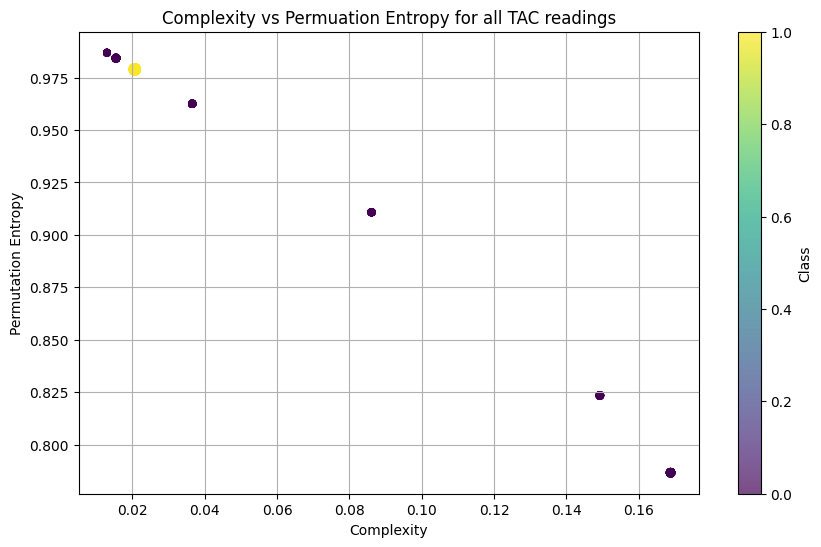

Plotting Scatter Plot


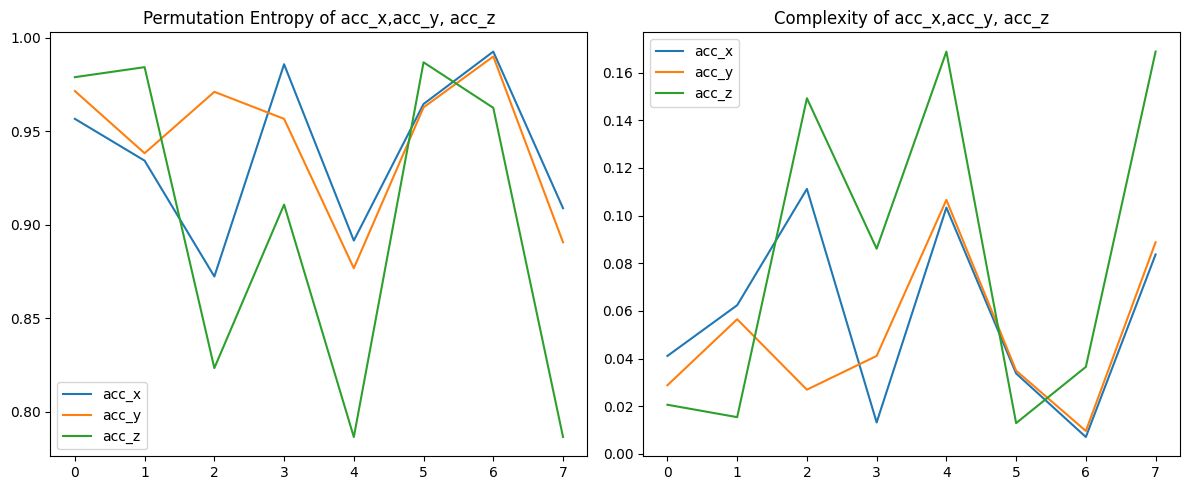

Graphs plotted successfully
###########################################################################################################


In [181]:
pid_name, pid = file_retrieval('DC6359_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

5.) PID: DK3500

###########################################################################################################
File Retrieval started
PID:  DK3500
File Retrieval finished
PID filtering started
Total number of rows are:  637
PID filtering ended
Plotting time stamp vs dimension graph


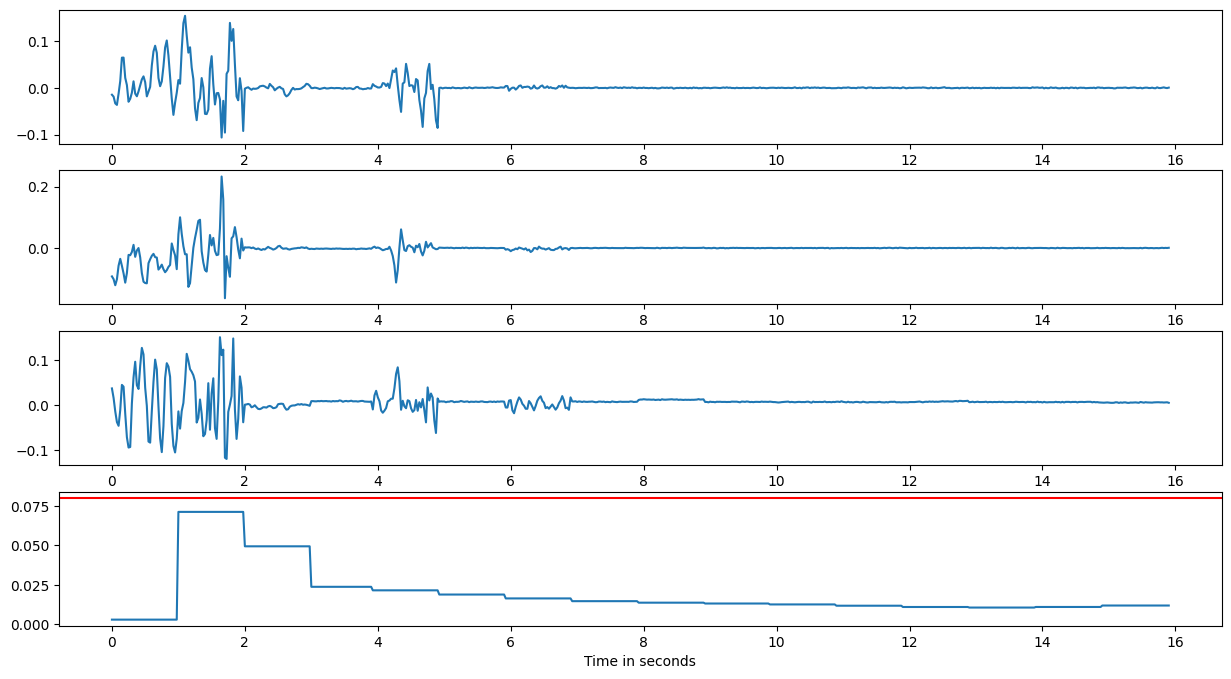

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [41, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 39, 37]


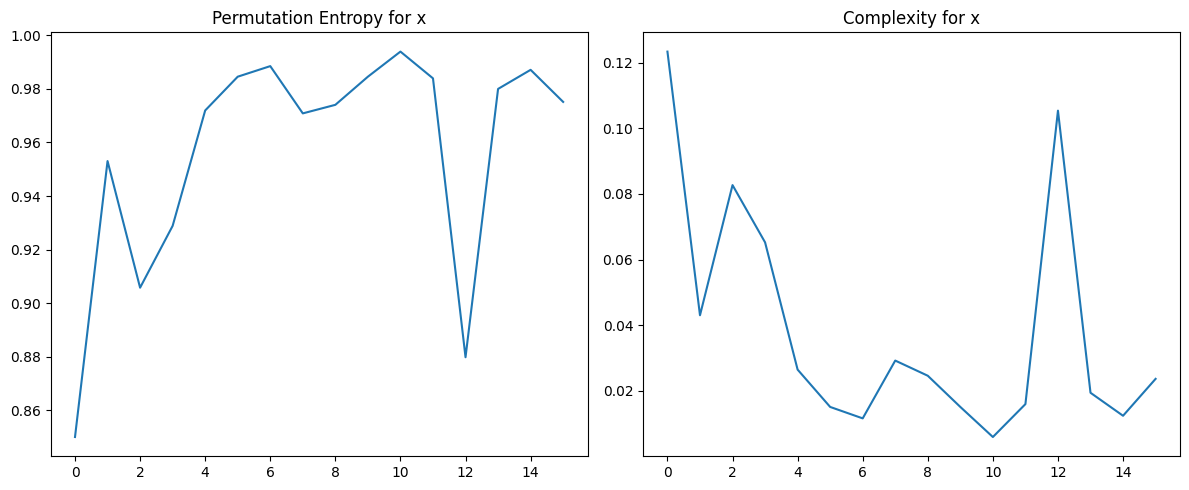

Starting Post Processing for df_sample_x
       Time       x       TAC  Permutation Entropy  Complexity  Class
0     0.000 -0.0149  0.003018             0.850094    0.123398      0
1     0.025 -0.0190  0.003018             0.850094    0.123398      0
2     0.050 -0.0334  0.003018             0.850094    0.123398      0
3     0.075 -0.0366  0.003018             0.850094    0.123398      0
4     0.100 -0.0126  0.003018             0.850094    0.123398      0
..      ...     ...       ...                  ...         ...    ...
632  15.800  0.0000  0.011943             0.975142    0.023656      0
633  15.825  0.0008  0.011943             0.975142    0.023656      0
634  15.850 -0.0002  0.011943             0.975142    0.023656      0
635  15.875 -0.0007  0.011943             0.975142    0.023656      0
636  15.900  0.0003  0.011943             0.975142    0.023656      0

[637 rows x 6 columns]
Post Processing completed for df_sample_x


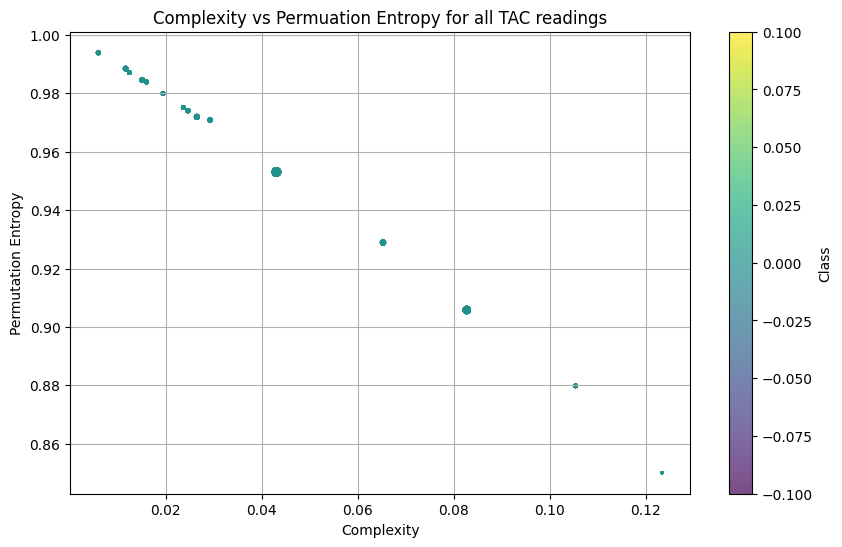

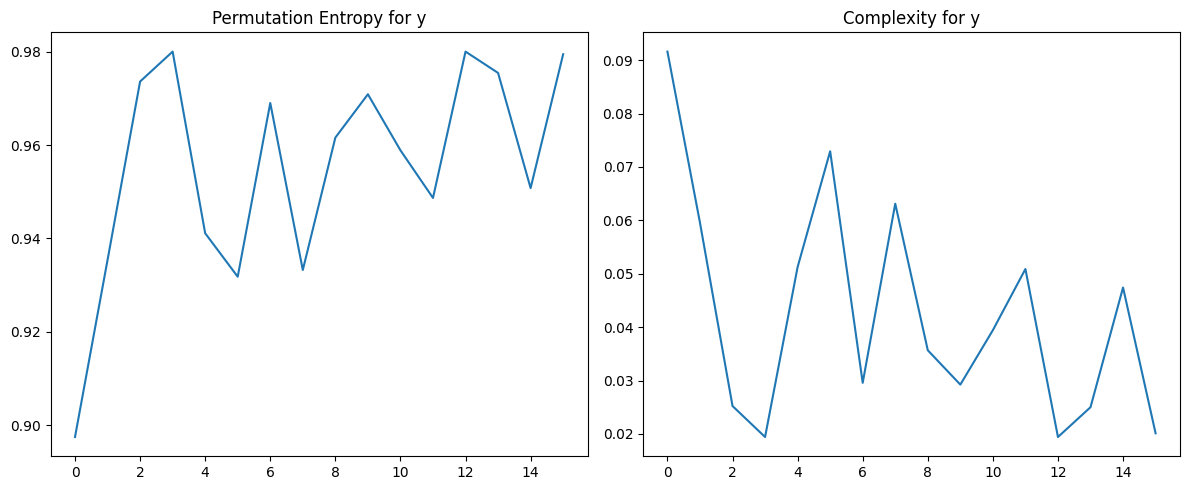

Starting Post Processing for df_sample_y
       Time       y       TAC  Permutation Entropy  Complexity  Class
0     0.000 -0.0921  0.003018             0.897518    0.091600      0
1     0.025 -0.1011  0.003018             0.897518    0.091600      0
2     0.050 -0.1208  0.003018             0.897518    0.091600      0
3     0.075 -0.1014  0.003018             0.897518    0.091600      0
4     0.100 -0.0571  0.003018             0.897518    0.091600      0
..      ...     ...       ...                  ...         ...    ...
632  15.800  0.0009  0.011943             0.979426    0.020113      0
633  15.825 -0.0000  0.011943             0.979426    0.020113      0
634  15.850  0.0006  0.011943             0.979426    0.020113      0
635  15.875  0.0002  0.011943             0.979426    0.020113      0
636  15.900  0.0009  0.011943             0.979426    0.020113      0

[637 rows x 6 columns]
Post Processing completed for df_sample_y


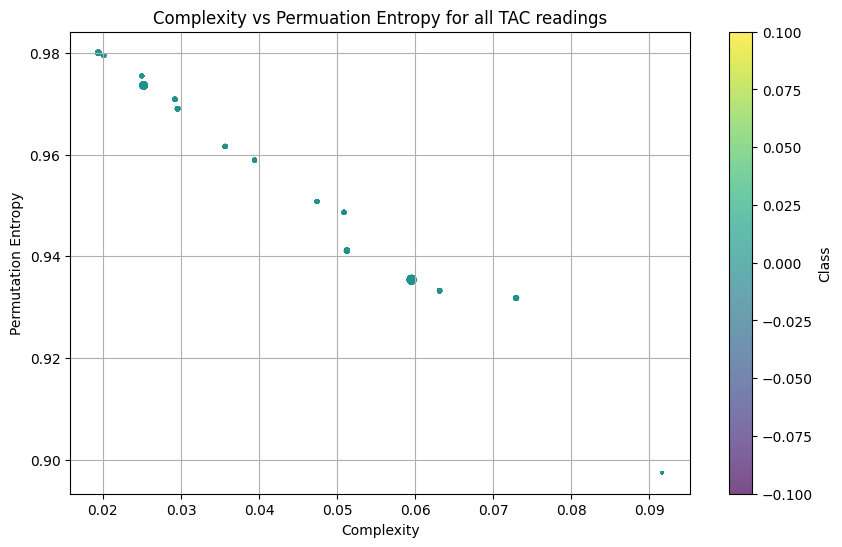

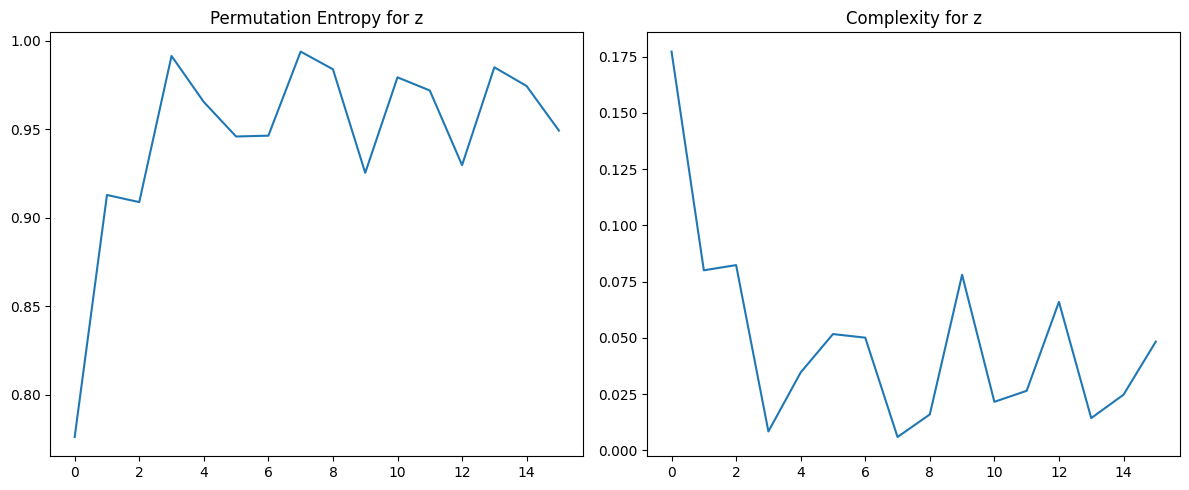

Starting Post Processing for df_sample_z
       Time       z       TAC  Permutation Entropy  Complexity  Class
0     0.000  0.0366  0.003018             0.776117    0.177292      0
1     0.025  0.0154  0.003018             0.776117    0.177292      0
2     0.050 -0.0144  0.003018             0.776117    0.177292      0
3     0.075 -0.0378  0.003018             0.776117    0.177292      0
4     0.100 -0.0461  0.003018             0.776117    0.177292      0
..      ...     ...       ...                  ...         ...    ...
632  15.800  0.0058  0.011943             0.949262    0.048342      0
633  15.825  0.0054  0.011943             0.949262    0.048342      0
634  15.850  0.0056  0.011943             0.949262    0.048342      0
635  15.875  0.0059  0.011943             0.949262    0.048342      0
636  15.900  0.0048  0.011943             0.949262    0.048342      0

[637 rows x 6 columns]
Post Processing completed for df_sample_z


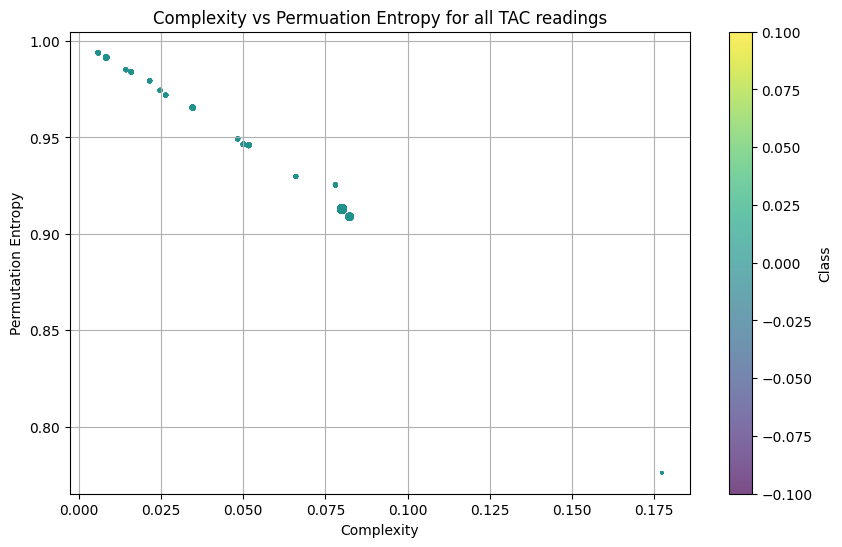

Plotting Scatter Plot


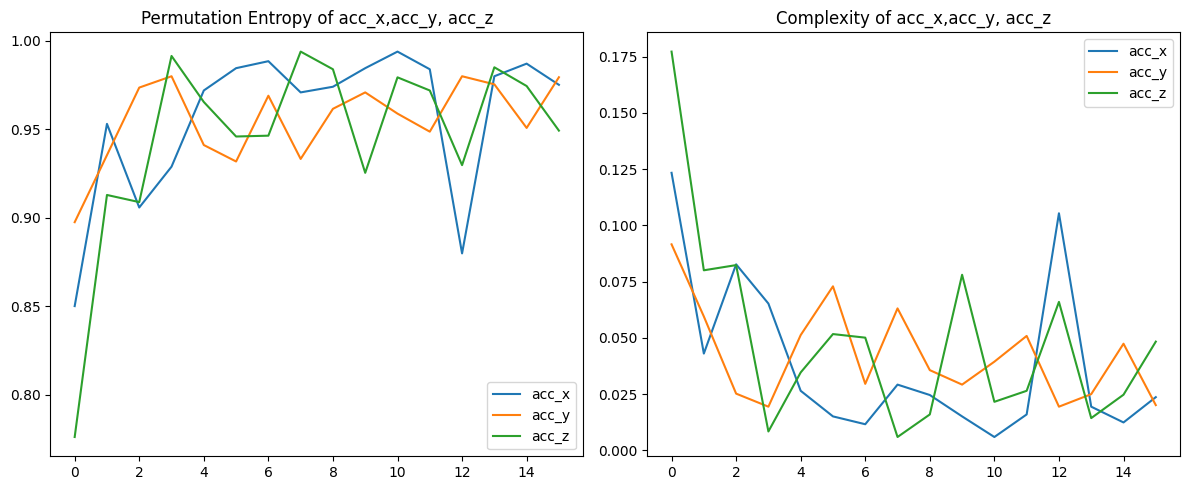

Graphs plotted successfully
###########################################################################################################


In [182]:
pid_name, pid = file_retrieval('DK3500_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

6.) PID: HV0618

###########################################################################################################
File Retrieval started
PID:  HV0618
File Retrieval finished
PID filtering started
Total number of rows are:  600
PID filtering ended
Plotting time stamp vs dimension graph


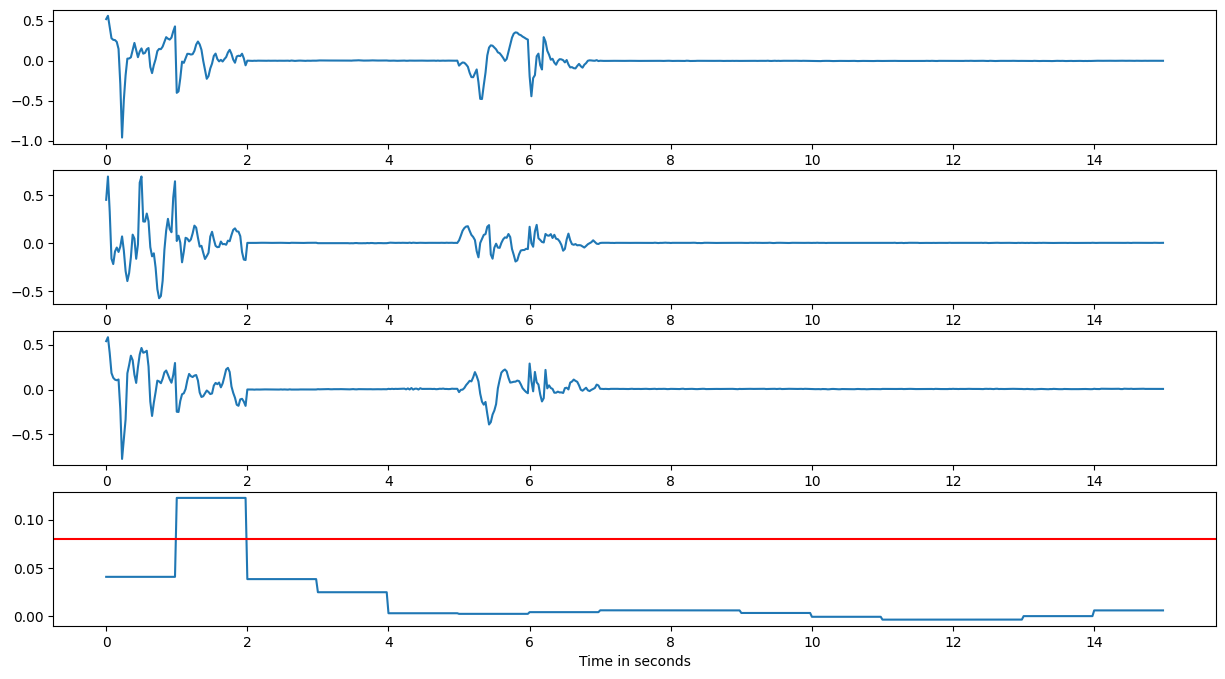

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]


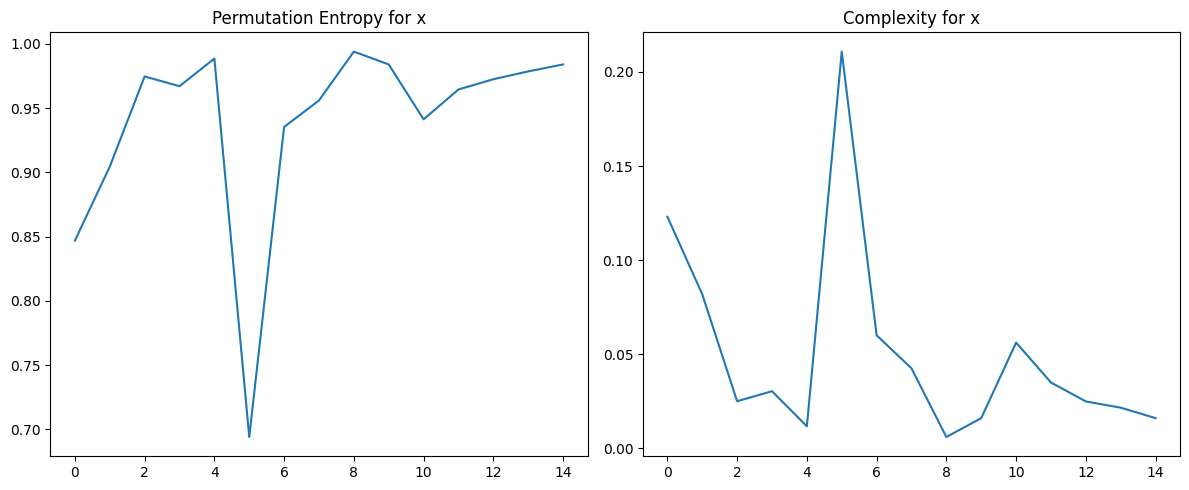

Starting Post Processing for df_sample_x
       Time       x       TAC  Permutation Entropy  Complexity  Class
0     0.000  0.5199  0.040862             0.846825    0.123038      0
1     0.025  0.5609  0.040862             0.846825    0.123038      0
2     0.050  0.4247  0.040862             0.846825    0.123038      0
3     0.075  0.2807  0.040862             0.846825    0.123038      0
4     0.100  0.2606  0.040862             0.846825    0.123038      0
..      ...     ...       ...                  ...         ...    ...
595  14.875 -0.0013  0.006193             0.983933    0.015965      0
596  14.900 -0.0010  0.006193             0.983933    0.015965      0
597  14.925 -0.0011  0.006193             0.983933    0.015965      0
598  14.950 -0.0013  0.006193             0.983933    0.015965      0
599  14.975 -0.0013  0.006193             0.983933    0.015965      0

[600 rows x 6 columns]
Post Processing completed for df_sample_x


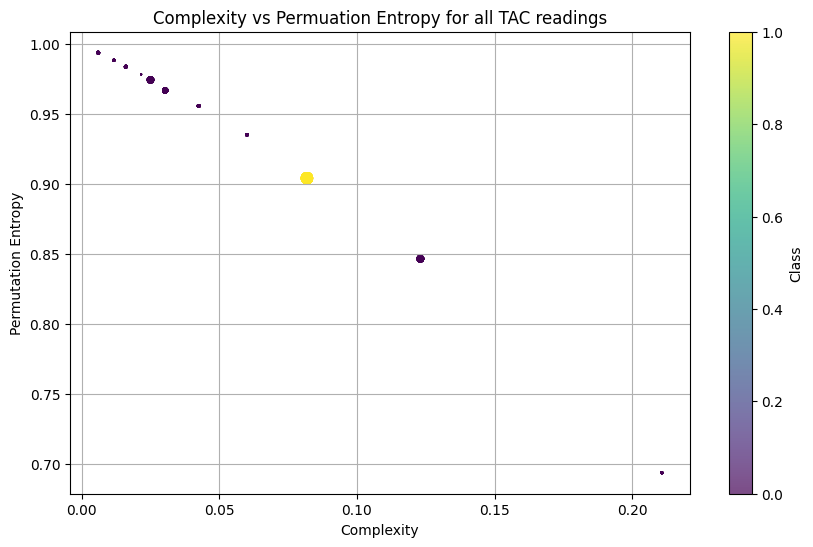

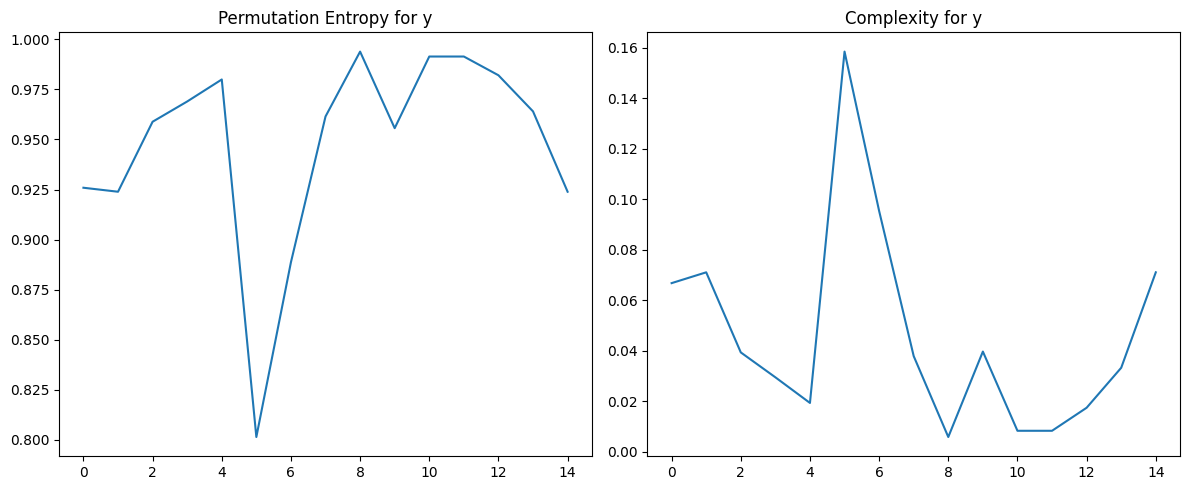

Starting Post Processing for df_sample_y
       Time       y       TAC  Permutation Entropy  Complexity  Class
0     0.000  0.4485  0.040862             0.925894    0.066849      0
1     0.025  0.6912  0.040862             0.925894    0.066849      0
2     0.050  0.3246  0.040862             0.925894    0.066849      0
3     0.075 -0.1651  0.040862             0.925894    0.066849      0
4     0.100 -0.2213  0.040862             0.925894    0.066849      0
..      ...     ...       ...                  ...         ...    ...
595  14.875  0.0000  0.006193             0.923896    0.071134      0
596  14.900 -0.0001  0.006193             0.923896    0.071134      0
597  14.925 -0.0006  0.006193             0.923896    0.071134      0
598  14.950  0.0002  0.006193             0.923896    0.071134      0
599  14.975  0.0000  0.006193             0.923896    0.071134      0

[600 rows x 6 columns]
Post Processing completed for df_sample_y


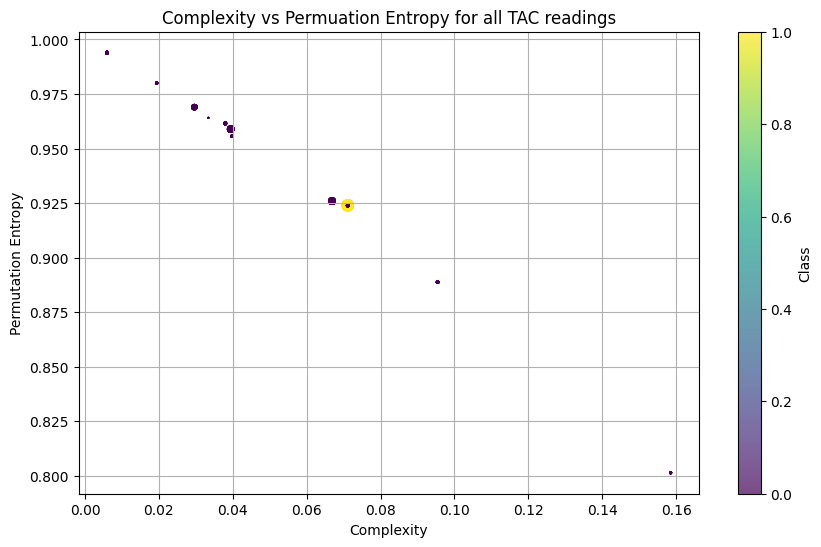

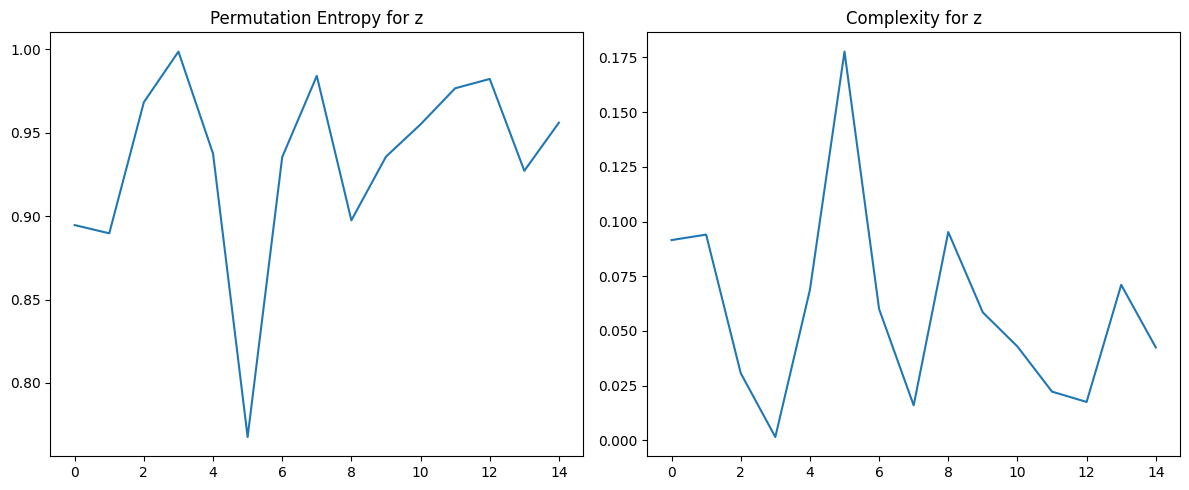

Starting Post Processing for df_sample_z
       Time       z       TAC  Permutation Entropy  Complexity  Class
0     0.000  0.5391  0.040862             0.894570    0.091516      0
1     0.025  0.5830  0.040862             0.894570    0.091516      0
2     0.050  0.4059  0.040862             0.894570    0.091516      0
3     0.075  0.1837  0.040862             0.894570    0.091516      0
4     0.100  0.1309  0.040862             0.894570    0.091516      0
..      ...     ...       ...                  ...         ...    ...
595  14.875  0.0063  0.006193             0.955915    0.042437      0
596  14.900  0.0075  0.006193             0.955915    0.042437      0
597  14.925  0.0061  0.006193             0.955915    0.042437      0
598  14.950  0.0071  0.006193             0.955915    0.042437      0
599  14.975  0.0065  0.006193             0.955915    0.042437      0

[600 rows x 6 columns]
Post Processing completed for df_sample_z


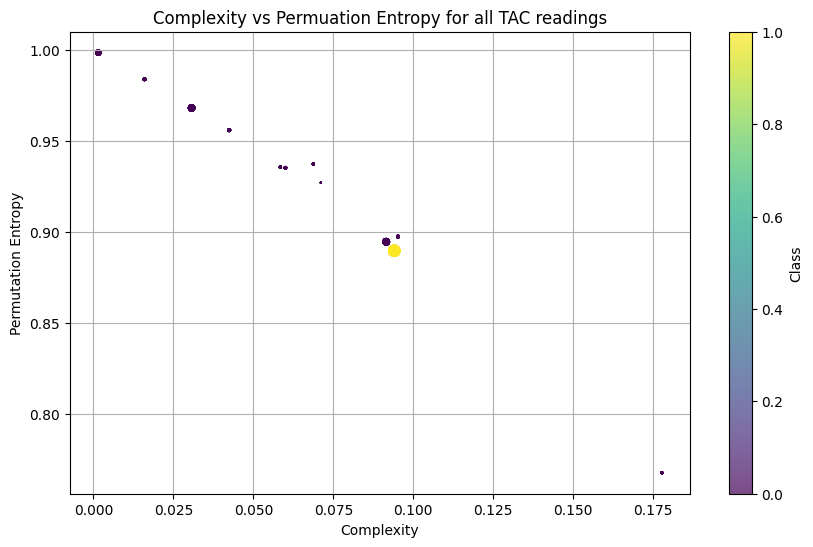

Plotting Scatter Plot


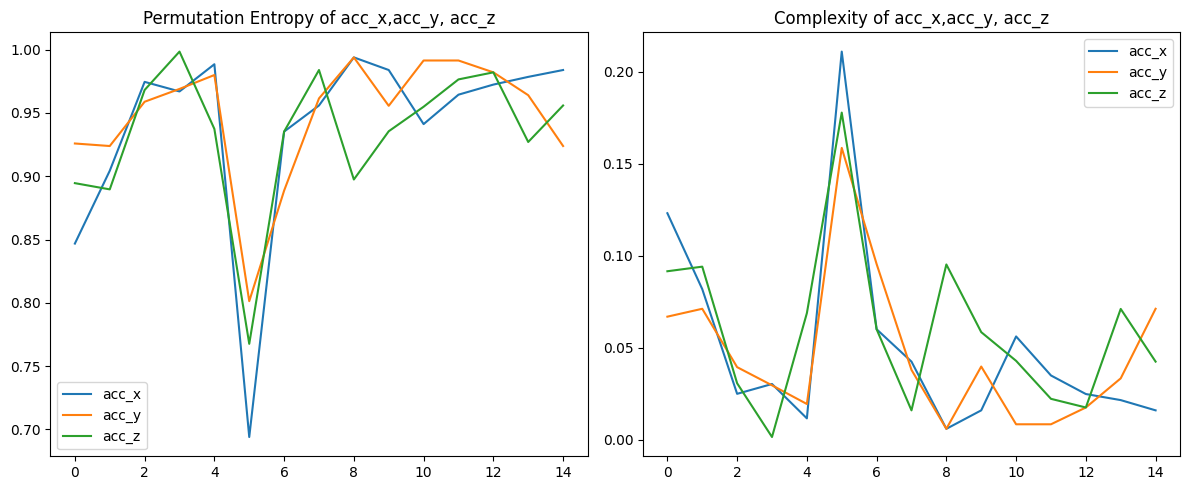

Graphs plotted successfully
###########################################################################################################


In [183]:
pid_name, pid = file_retrieval('HV0618_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

7.) PID: JB3156

###########################################################################################################
File Retrieval started
PID:  JB3156
File Retrieval finished
PID filtering started
Total number of rows are:  720
PID filtering ended
Plotting time stamp vs dimension graph


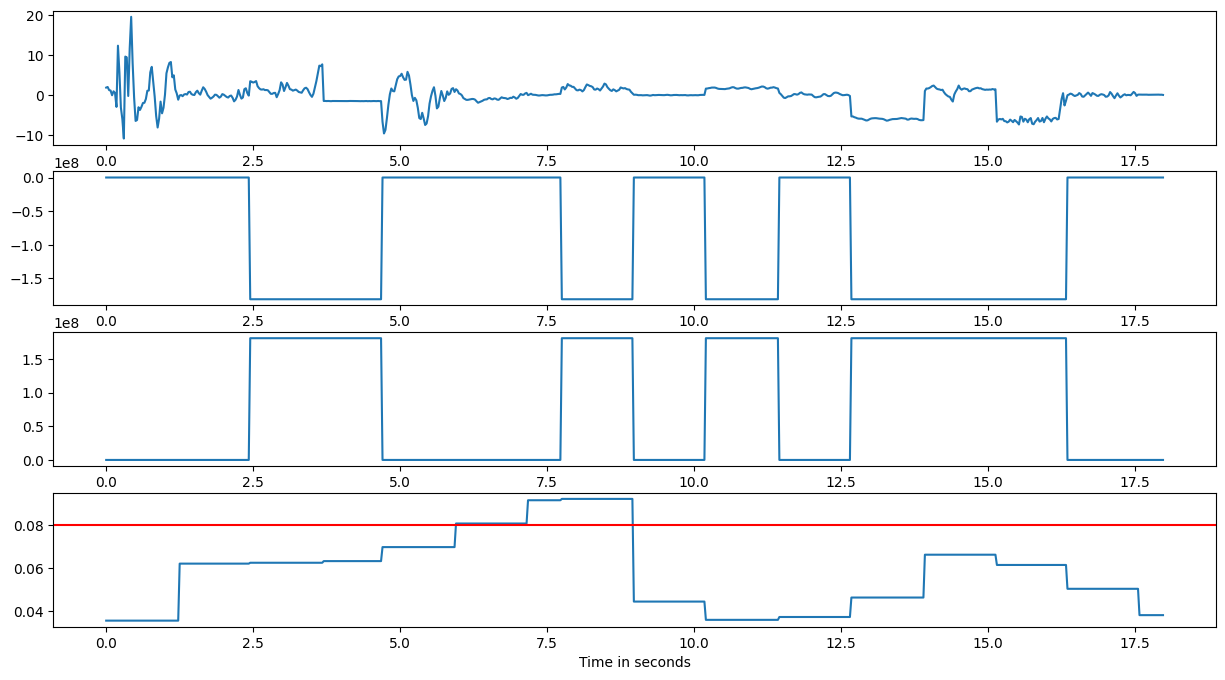

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 49, 48, 48, 40, 23, 17]


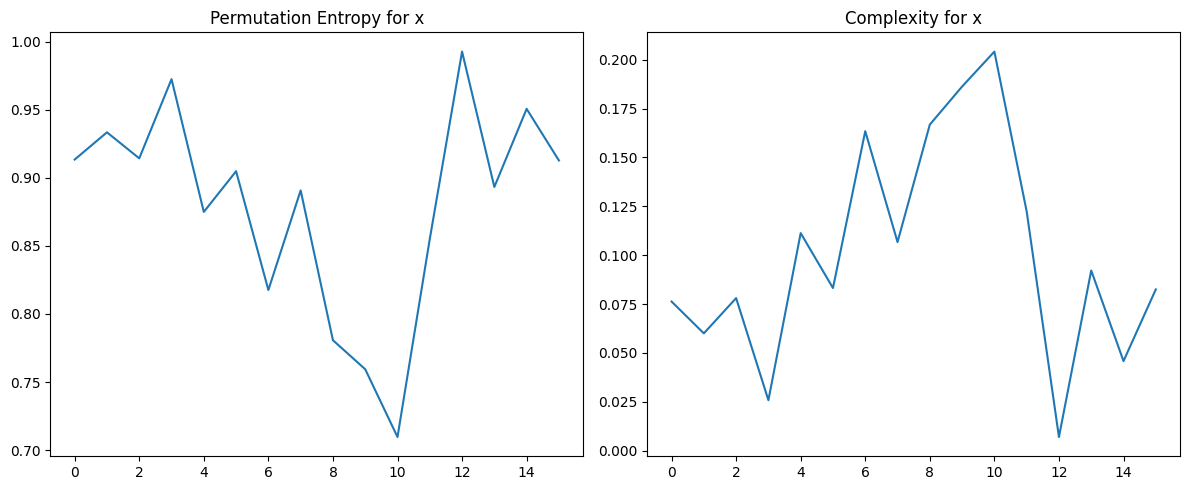

Starting Post Processing for df_sample_x
       Time         x       TAC  Permutation Entropy  Complexity  Class
0     0.000  1.829285  0.035549             0.913480    0.076273      0
1     0.025  1.981330  0.035549             0.913480    0.076273      0
2     0.050  1.193751  0.035549             0.913480    0.076273      0
3     0.075  1.087926  0.035549             0.913480    0.076273      0
4     0.100 -0.092390  0.035549             0.913480    0.076273      0
..      ...       ...       ...                  ...         ...    ...
715  17.875  0.054742  0.038097             0.912803    0.082472      0
716  17.900  0.064429  0.038097             0.912803    0.082472      0
717  17.925  0.038093  0.038097             0.912803    0.082472      0
718  17.950  0.046472  0.038097             0.912803    0.082472      0
719  17.975 -0.008594  0.038097             0.912803    0.082472      0

[720 rows x 6 columns]
Post Processing completed for df_sample_x


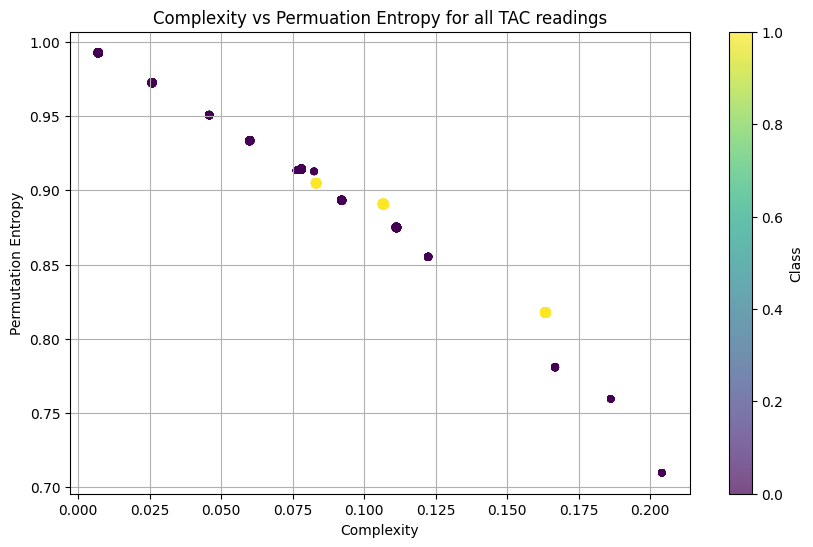

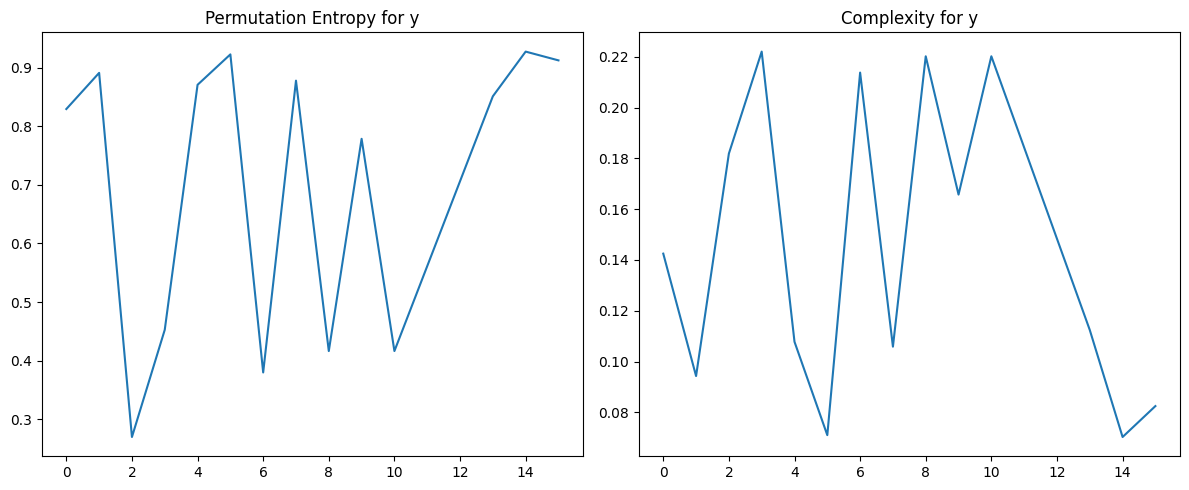

Starting Post Processing for df_sample_y
       Time          y       TAC  Permutation Entropy  Complexity  Class
0     0.000  10.341198  0.035549             0.829680    0.142484      0
1     0.025   9.302634  0.035549             0.829680    0.142484      0
2     0.050   6.882037  0.035549             0.829680    0.142484      0
3     0.075   3.531353  0.035549             0.829680    0.142484      0
4     0.100   3.977956  0.035549             0.829680    0.142484      0
..      ...        ...       ...                  ...         ...    ...
715  17.875  -0.075326  0.038097             0.912803    0.082472      0
716  17.900  -0.069424  0.038097             0.912803    0.082472      0
717  17.925  -0.053862  0.038097             0.912803    0.082472      0
718  17.950  -0.065833  0.038097             0.912803    0.082472      0
719  17.975  -0.037103  0.038097             0.912803    0.082472      0

[720 rows x 6 columns]
Post Processing completed for df_sample_y


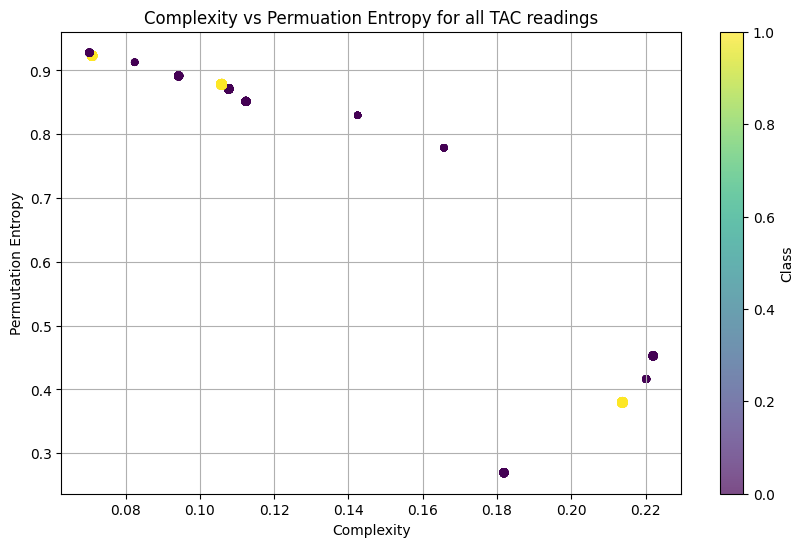

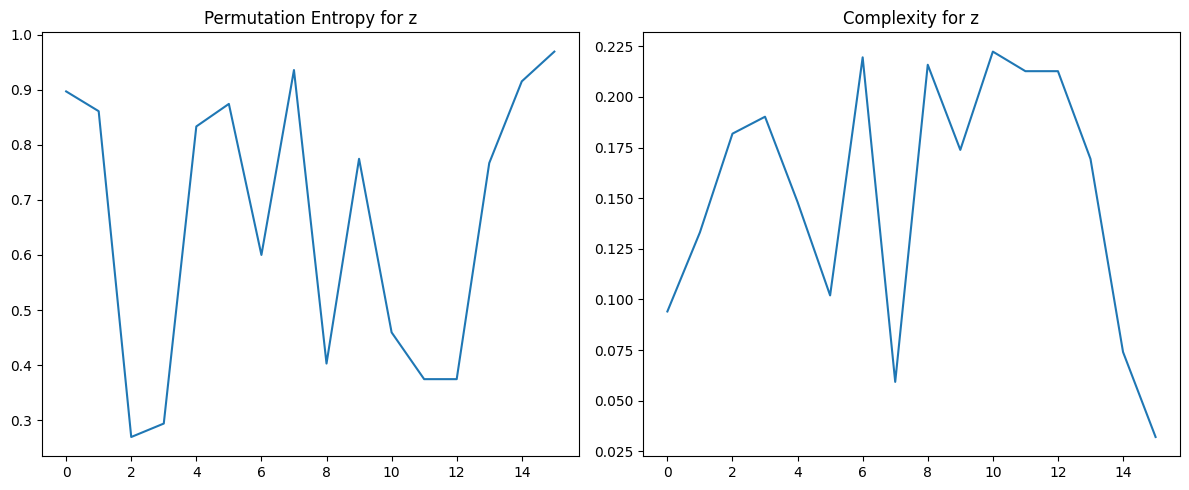

Starting Post Processing for df_sample_z
       Time          z       TAC  Permutation Entropy  Complexity  Class
0     0.000  10.899044  0.035549             0.897024    0.094082      0
1     0.025  10.169534  0.035549             0.897024    0.094082      0
2     0.050   8.002905  0.035549             0.897024    0.094082      0
3     0.075  10.245369  0.035549             0.897024    0.094082      0
4     0.100  13.346973  0.035549             0.897024    0.094082      0
..      ...        ...       ...                  ...         ...    ...
715  17.875  -0.261302  0.038097             0.969293    0.032098      0
716  17.900  -0.282848  0.038097             0.969293    0.032098      0
717  17.925  -0.239753  0.038097             0.969293    0.032098      0
718  17.950  -0.266089  0.038097             0.969293    0.032098      0
719  17.975  -0.237358  0.038097             0.969293    0.032098      0

[720 rows x 6 columns]
Post Processing completed for df_sample_z


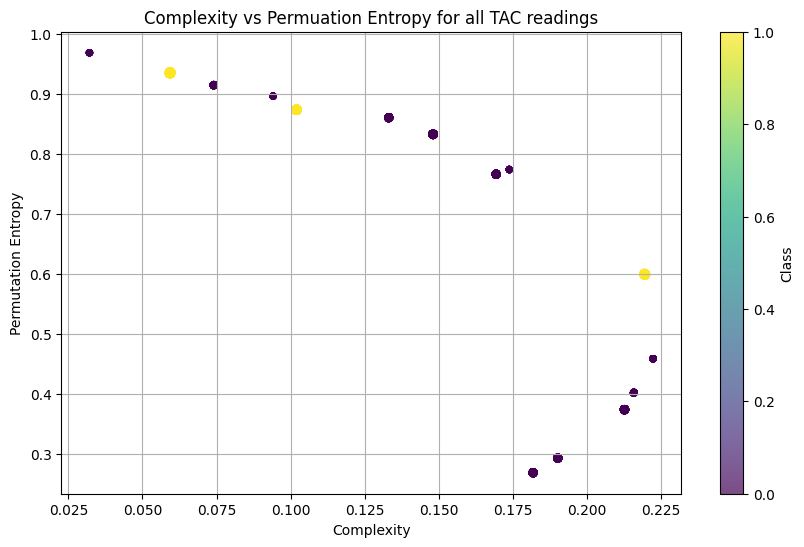

Plotting Scatter Plot


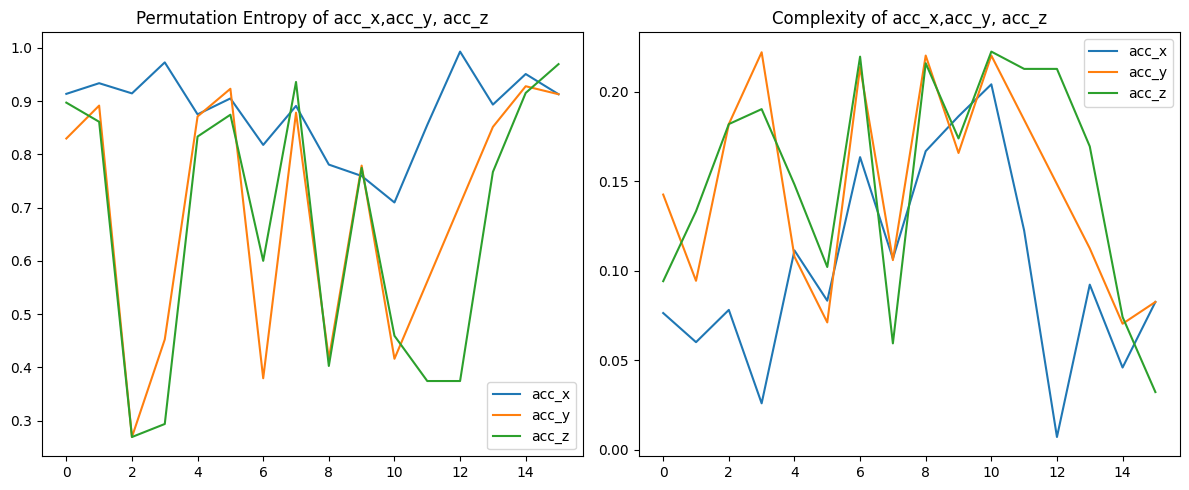

Graphs plotted successfully
###########################################################################################################


In [184]:
pid_name, pid = file_retrieval('JB3156_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

8.) PID: JR8022

###########################################################################################################
File Retrieval started
PID:  JR8022
File Retrieval finished
PID filtering started
Total number of rows are:  119
PID filtering ended
Plotting time stamp vs dimension graph


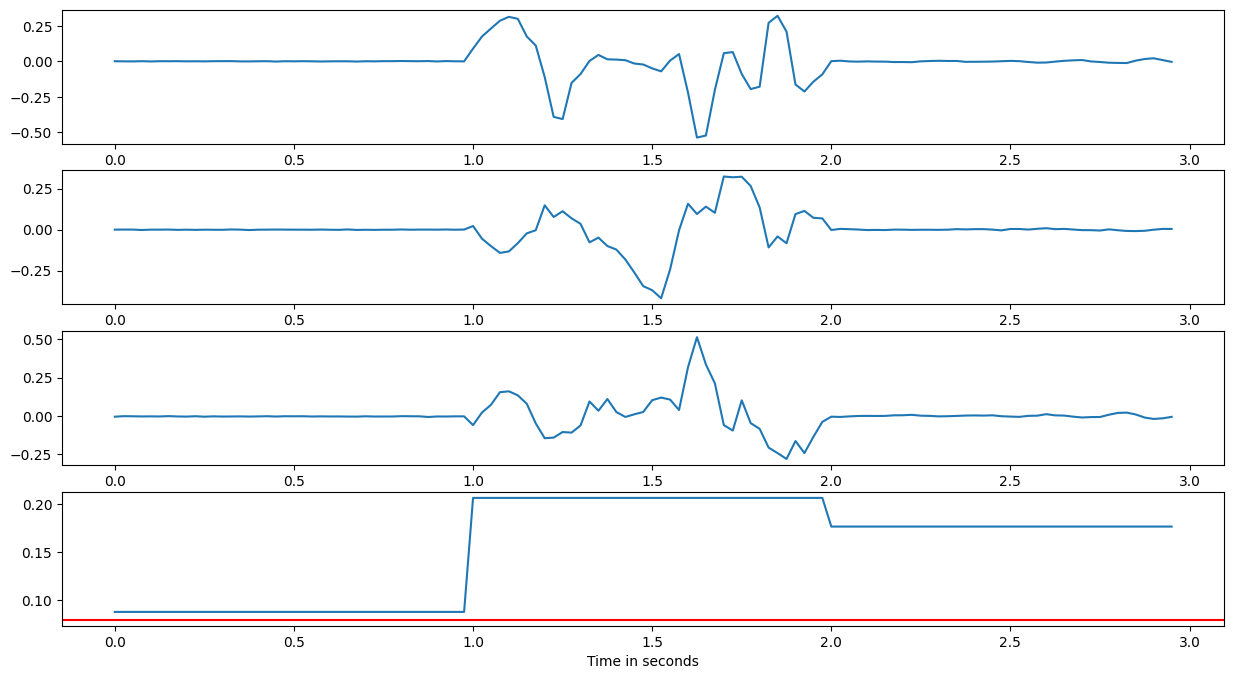

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [40, 40, 39]


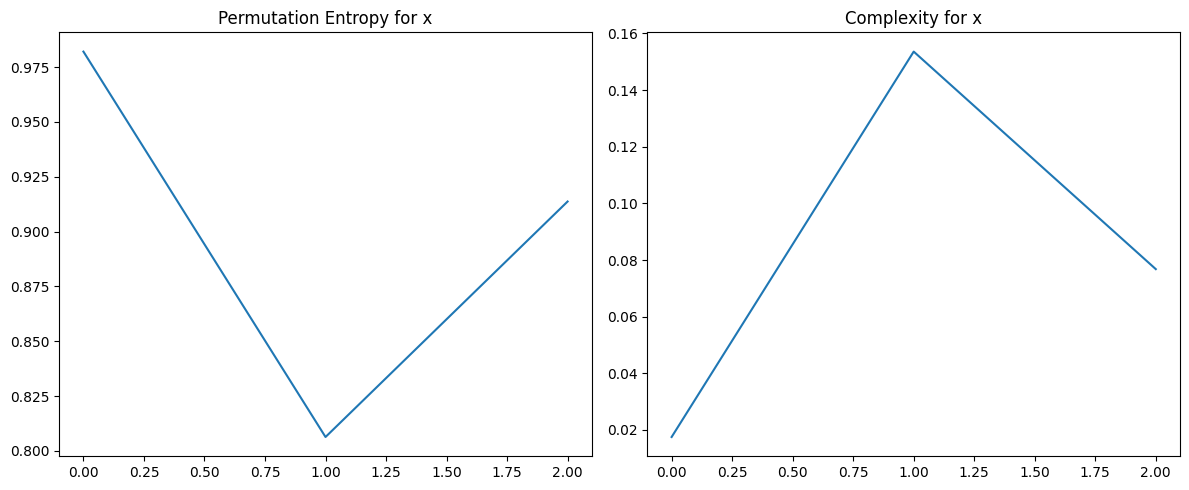

Starting Post Processing for df_sample_x
      Time       x       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.0004  0.088046             0.982092    0.017516      1
1    0.025 -0.0004  0.088046             0.982092    0.017516      1
2    0.050 -0.0008  0.088046             0.982092    0.017516      1
3    0.075  0.0008  0.088046             0.982092    0.017516      1
4    0.100 -0.0011  0.088046             0.982092    0.017516      1
..     ...     ...       ...                  ...         ...    ...
114  2.850  0.0047  0.176895             0.913720    0.076784      1
115  2.875  0.0162  0.176895             0.913720    0.076784      1
116  2.900  0.0213  0.176895             0.913720    0.076784      1
117  2.925  0.0086  0.176895             0.913720    0.076784      1
118  2.950 -0.0041  0.176895             0.913720    0.076784      1

[119 rows x 6 columns]
Post Processing completed for df_sample_x


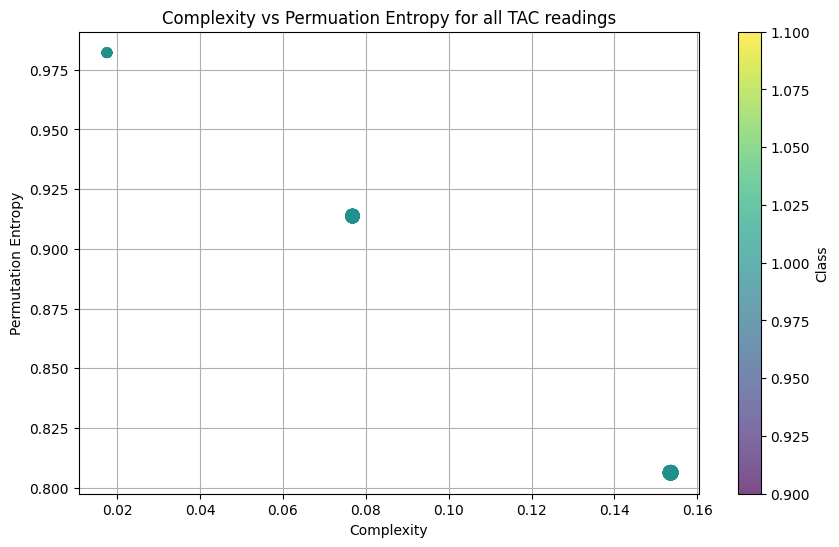

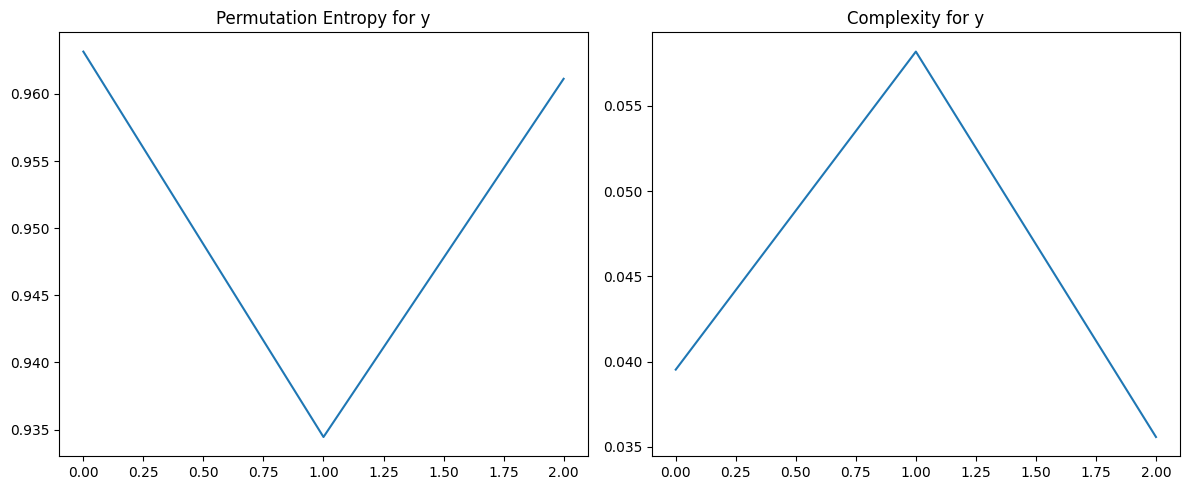

Starting Post Processing for df_sample_y
      Time       y       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0002  0.088046             0.963146    0.039533      1
1    0.025  0.0004  0.088046             0.963146    0.039533      1
2    0.050  0.0002  0.088046             0.963146    0.039533      1
3    0.075 -0.0023  0.088046             0.963146    0.039533      1
4    0.100 -0.0002  0.088046             0.963146    0.039533      1
..     ...     ...       ...                  ...         ...    ...
114  2.850 -0.0088  0.176895             0.961121    0.035584      1
115  2.875 -0.0071  0.176895             0.961121    0.035584      1
116  2.900 -0.0004  0.176895             0.961121    0.035584      1
117  2.925  0.0042  0.176895             0.961121    0.035584      1
118  2.950  0.0041  0.176895             0.961121    0.035584      1

[119 rows x 6 columns]
Post Processing completed for df_sample_y


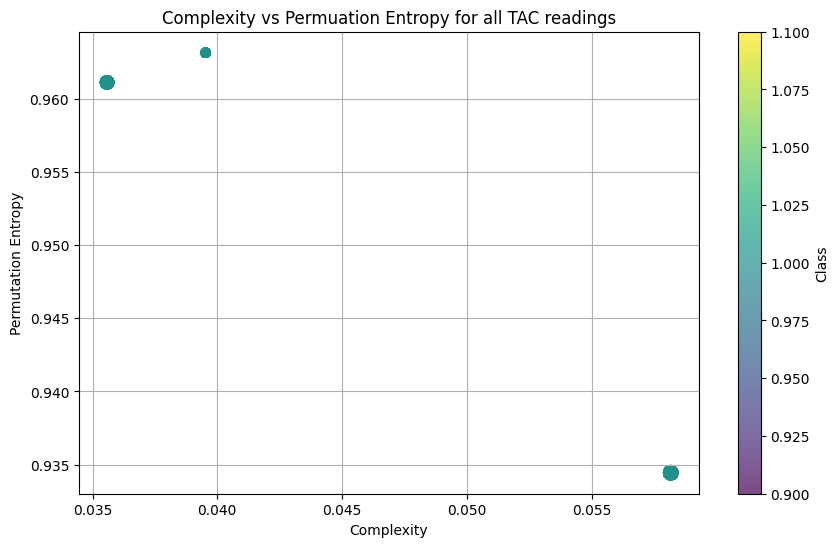

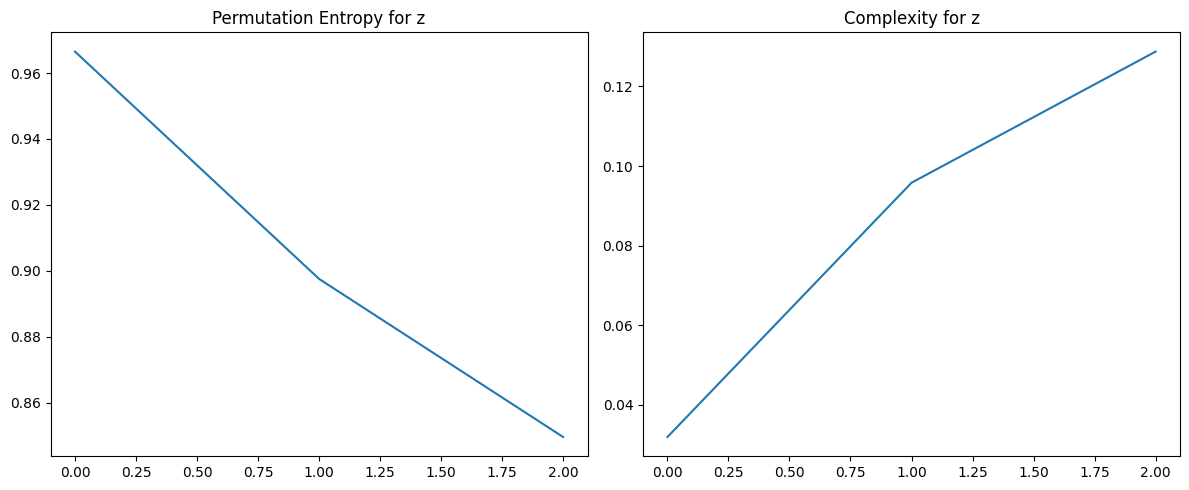

Starting Post Processing for df_sample_z
      Time       z       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0057  0.088046             0.966530    0.031911      1
1    0.025 -0.0023  0.088046             0.966530    0.031911      1
2    0.050 -0.0030  0.088046             0.966530    0.031911      1
3    0.075 -0.0041  0.088046             0.966530    0.031911      1
4    0.100 -0.0036  0.088046             0.966530    0.031911      1
..     ...     ...       ...                  ...         ...    ...
114  2.850  0.0086  0.176895             0.849535    0.128747      1
115  2.875 -0.0115  0.176895             0.849535    0.128747      1
116  2.900 -0.0205  0.176895             0.849535    0.128747      1
117  2.925 -0.0163  0.176895             0.849535    0.128747      1
118  2.950 -0.0068  0.176895             0.849535    0.128747      1

[119 rows x 6 columns]
Post Processing completed for df_sample_z


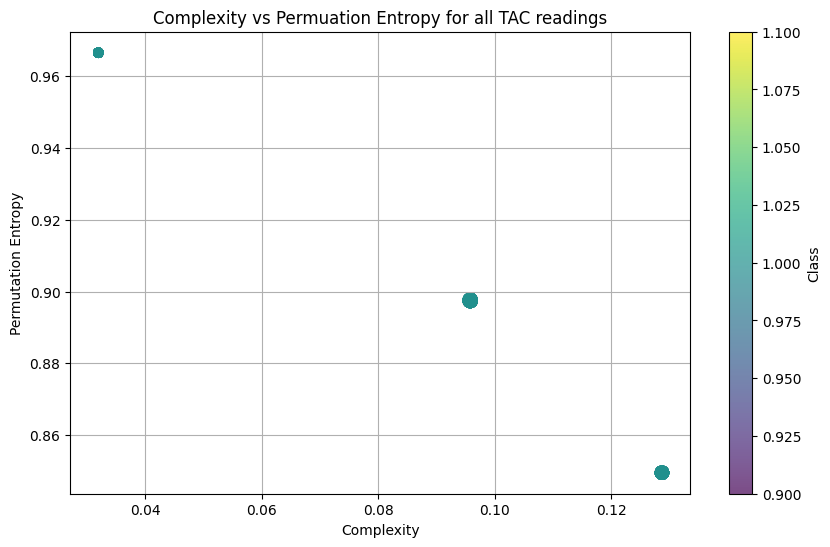

Plotting Scatter Plot


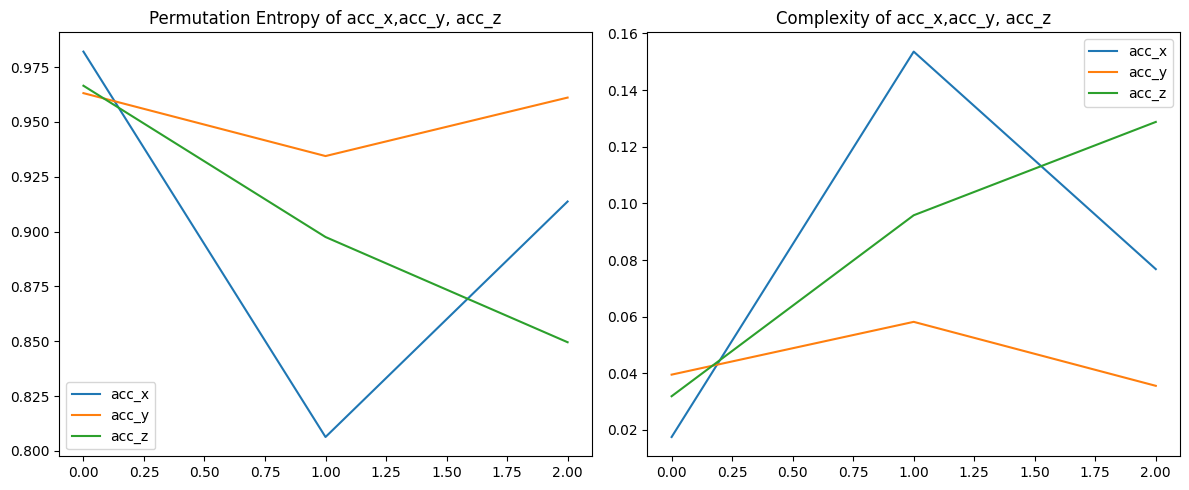

Graphs plotted successfully
###########################################################################################################


In [185]:
pid_name, pid = file_retrieval('JR8022_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

9.) PID: MC7070

###########################################################################################################
File Retrieval started
PID:  MC7070
File Retrieval finished
PID filtering started
Total number of rows are:  191
PID filtering ended
Plotting time stamp vs dimension graph


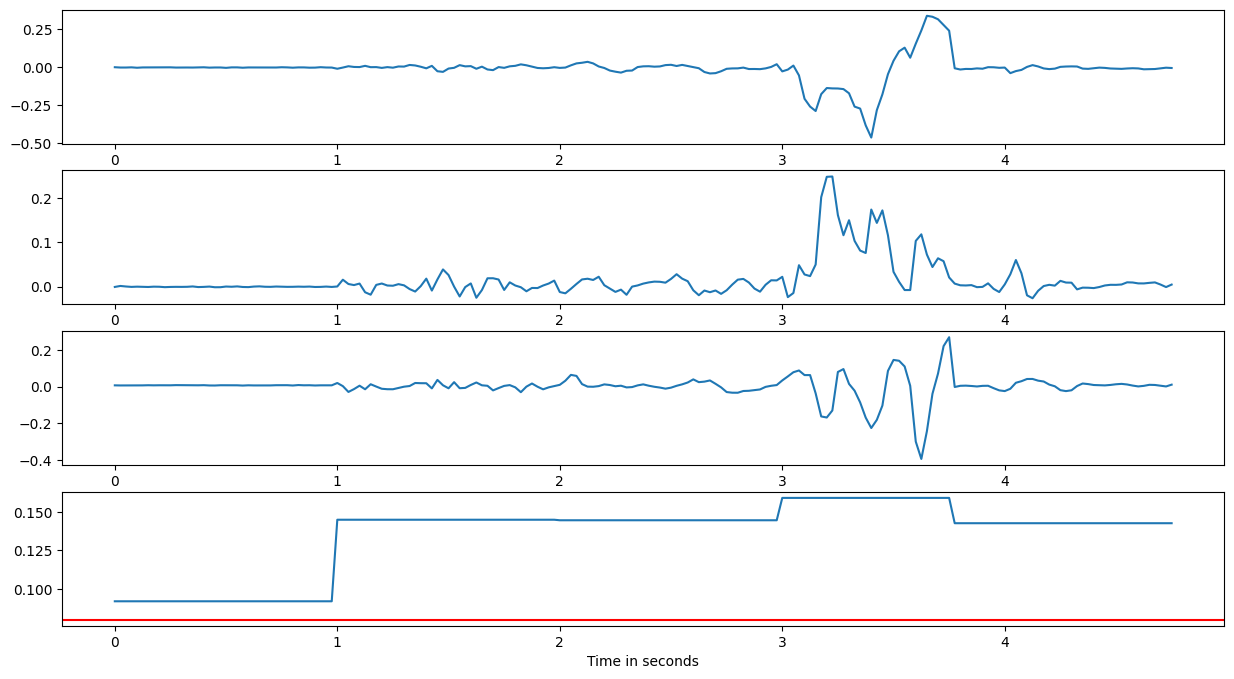

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [40, 40, 40, 40, 31]


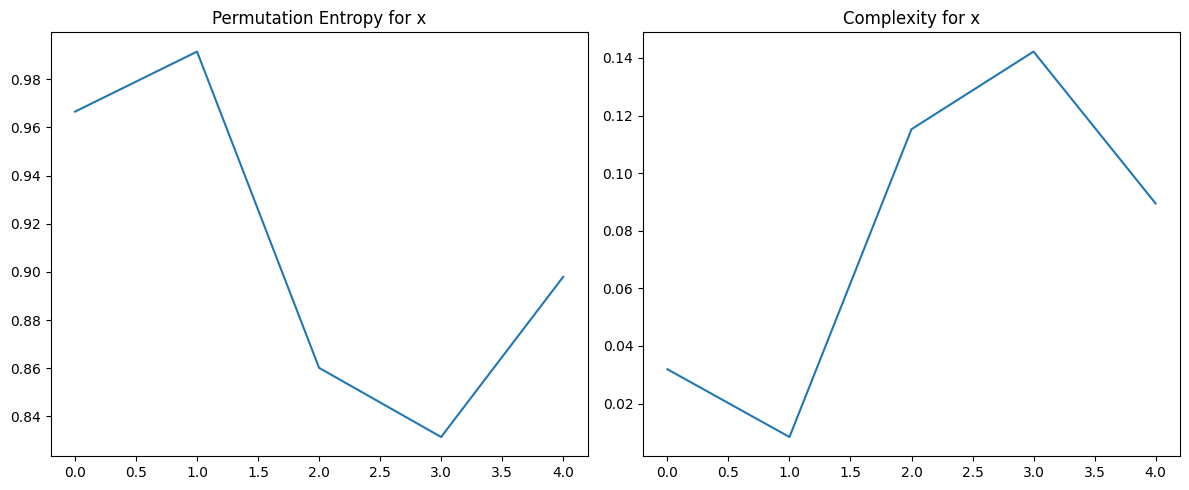

Starting Post Processing for df_sample_x
      Time       x       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.0013  0.091933             0.966530    0.031911      1
1    0.025 -0.0007  0.091933             0.966530    0.031911      1
2    0.050 -0.0007  0.091933             0.966530    0.031911      1
3    0.075  0.0005  0.091933             0.966530    0.031911      1
4    0.100 -0.0021  0.091933             0.966530    0.031911      1
..     ...     ...       ...                  ...         ...    ...
186  4.650 -0.0113  0.142696             0.897933    0.089469      1
187  4.675 -0.0105  0.142696             0.897933    0.089469      1
188  4.700 -0.0062  0.142696             0.897933    0.089469      1
189  4.725 -0.0018  0.142696             0.897933    0.089469      1
190  4.750 -0.0038  0.142696             0.897933    0.089469      1

[191 rows x 6 columns]
Post Processing completed for df_sample_x


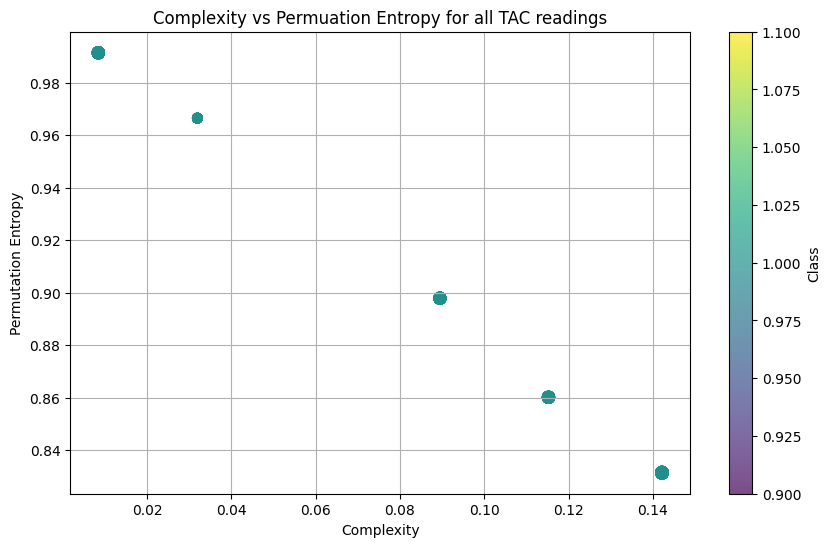

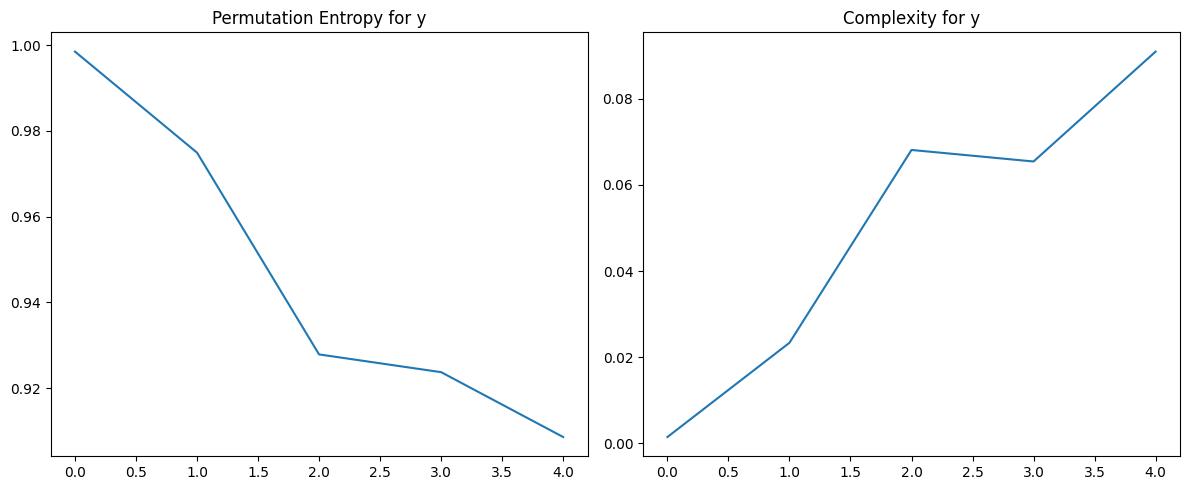

Starting Post Processing for df_sample_y
      Time       y       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0008  0.091933             0.998479    0.001487      1
1    0.025  0.0014  0.091933             0.998479    0.001487      1
2    0.050  0.0002  0.091933             0.998479    0.001487      1
3    0.075 -0.0007  0.091933             0.998479    0.001487      1
4    0.100 -0.0002  0.091933             0.998479    0.001487      1
..     ...     ...       ...                  ...         ...    ...
186  4.650  0.0084  0.142696             0.908578    0.090936      1
187  4.675  0.0094  0.142696             0.908578    0.090936      1
188  4.700  0.0046  0.142696             0.908578    0.090936      1
189  4.725 -0.0011  0.142696             0.908578    0.090936      1
190  4.750  0.0045  0.142696             0.908578    0.090936      1

[191 rows x 6 columns]
Post Processing completed for df_sample_y


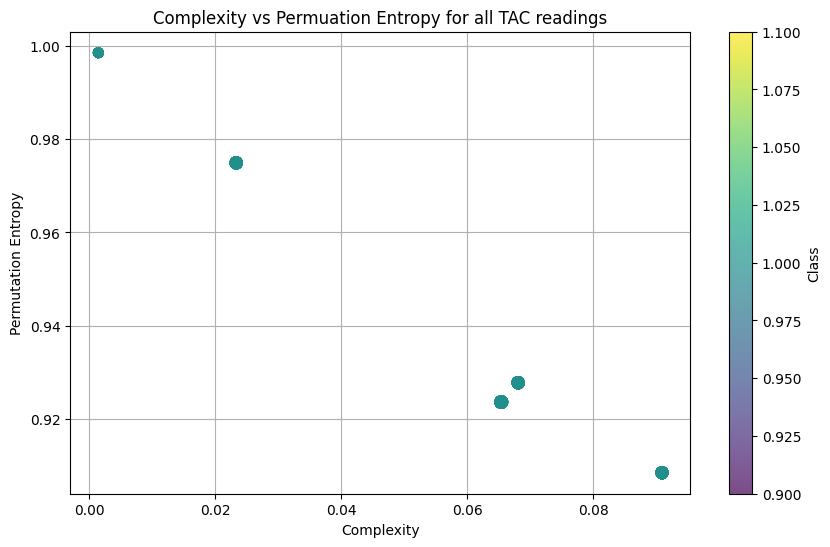

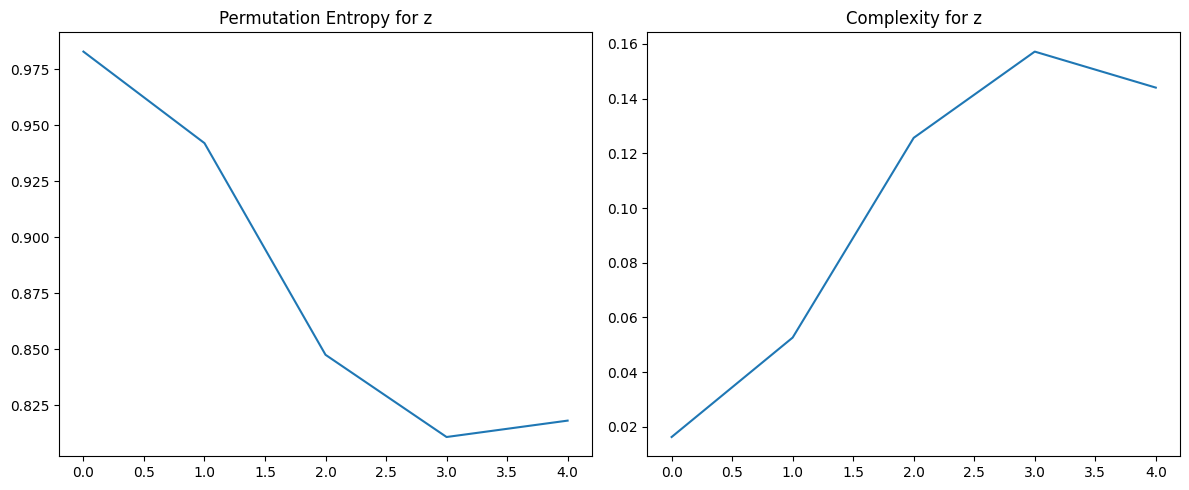

Starting Post Processing for df_sample_z
      Time       z       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.0075  0.091933             0.982944    0.016256      1
1    0.025  0.0069  0.091933             0.982944    0.016256      1
2    0.050  0.0070  0.091933             0.982944    0.016256      1
3    0.075  0.0074  0.091933             0.982944    0.016256      1
4    0.100  0.0072  0.091933             0.982944    0.016256      1
..     ...     ...       ...                  ...         ...    ...
186  4.650  0.0104  0.142696             0.818161    0.144034      1
187  4.675  0.0095  0.142696             0.818161    0.144034      1
188  4.700  0.0056  0.142696             0.818161    0.144034      1
189  4.725  0.0015  0.142696             0.818161    0.144034      1
190  4.750  0.0112  0.142696             0.818161    0.144034      1

[191 rows x 6 columns]
Post Processing completed for df_sample_z


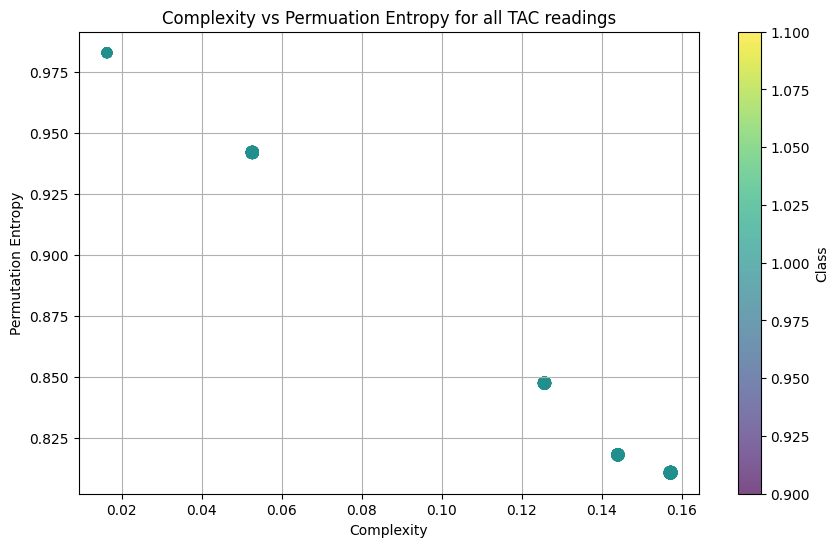

Plotting Scatter Plot


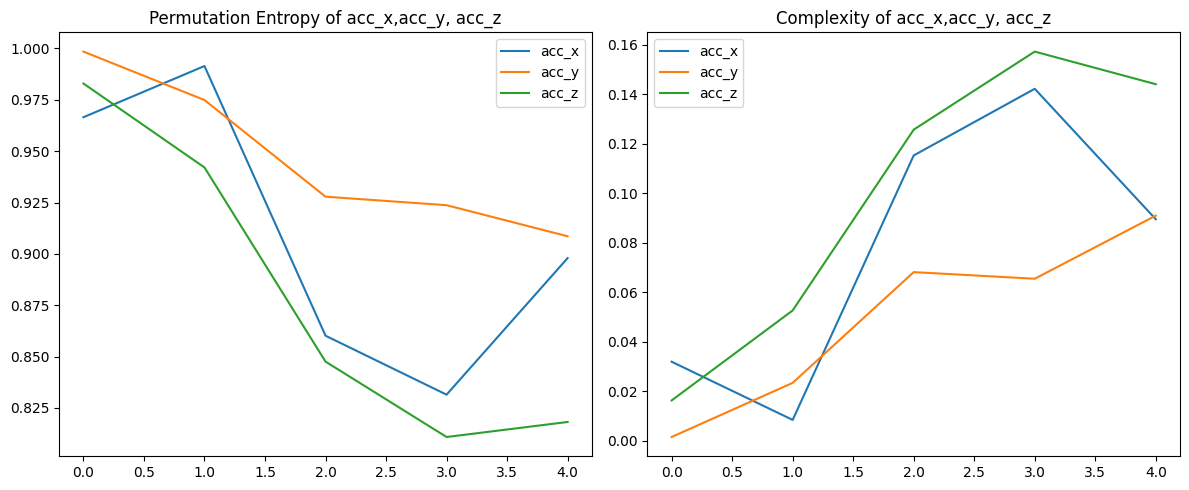

Graphs plotted successfully
###########################################################################################################


In [186]:
pid_name, pid = file_retrieval('MC7070_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

10.) PID: MJ8002

###########################################################################################################
File Retrieval started
PID:  MJ8002
File Retrieval finished
PID filtering started
Total number of rows are:  320
PID filtering ended
Plotting time stamp vs dimension graph


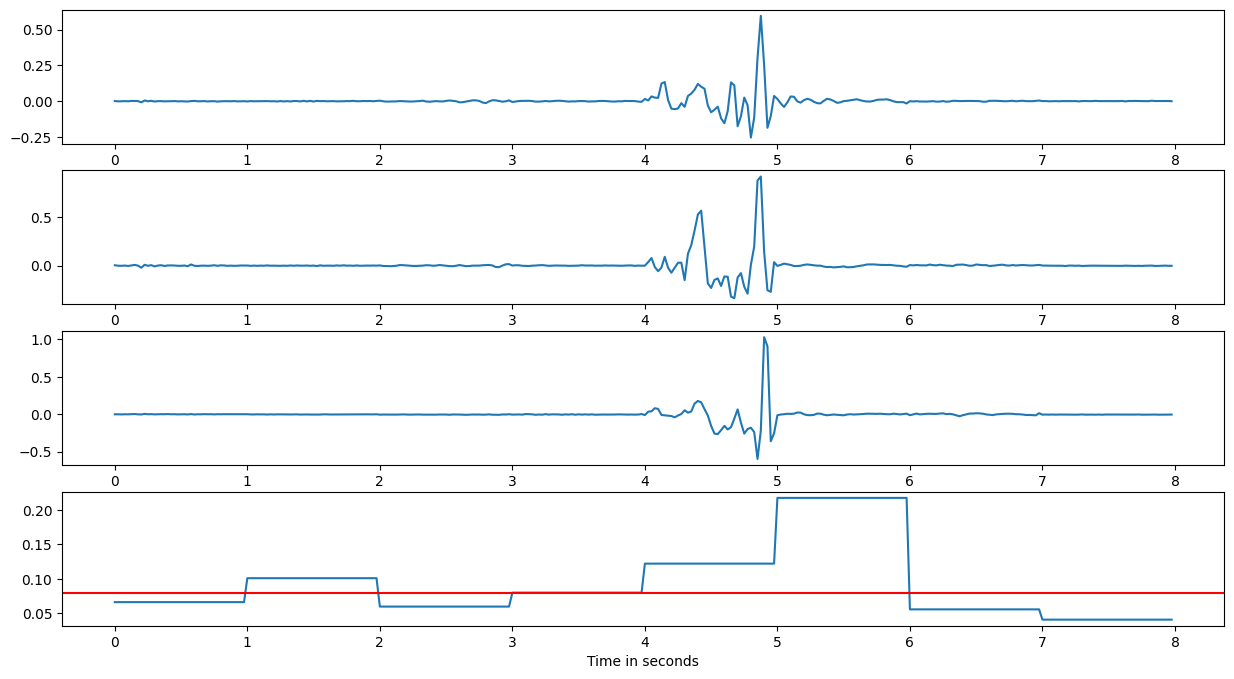

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [40, 40, 40, 40, 40, 40, 40, 40]


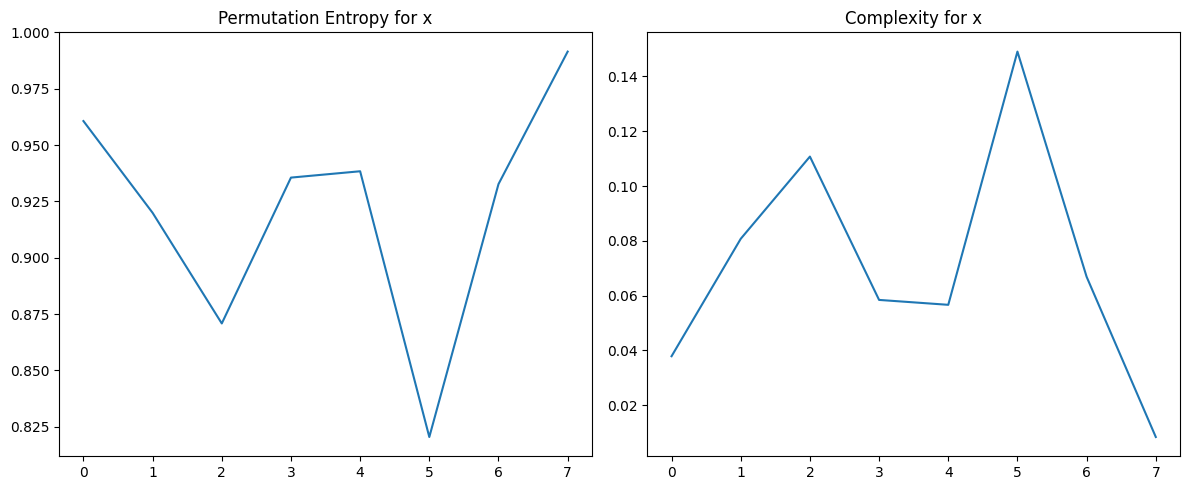

Starting Post Processing for df_sample_x
      Time       x       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.0011  0.066343             0.960643    0.037884      0
1    0.025 -0.0008  0.066343             0.960643    0.037884      0
2    0.050 -0.0005  0.066343             0.960643    0.037884      0
3    0.075  0.0010  0.066343             0.960643    0.037884      0
4    0.100 -0.0006  0.066343             0.960643    0.037884      0
..     ...     ...       ...                  ...         ...    ...
315  7.875  0.0015  0.040976             0.991455    0.008398      0
316  7.900  0.0023  0.040976             0.991455    0.008398      0
317  7.925  0.0017  0.040976             0.991455    0.008398      0
318  7.950  0.0016  0.040976             0.991455    0.008398      0
319  7.975  0.0002  0.040976             0.991455    0.008398      0

[320 rows x 6 columns]
Post Processing completed for df_sample_x


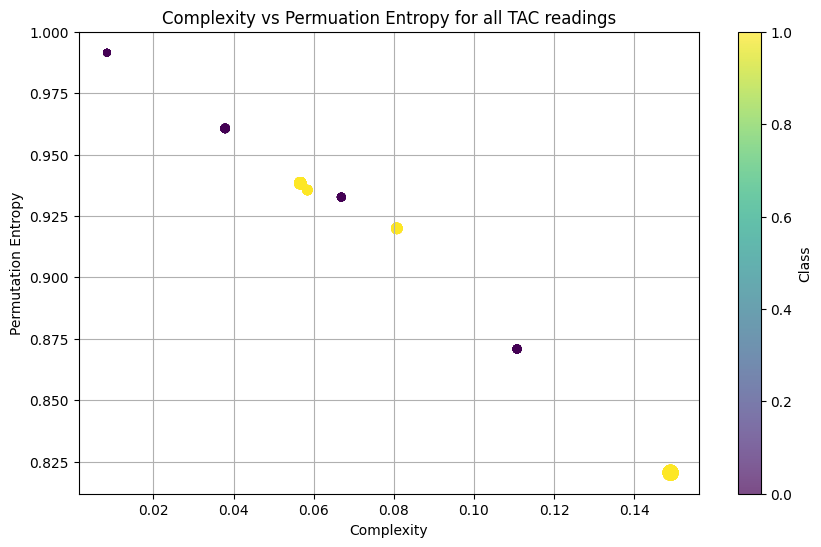

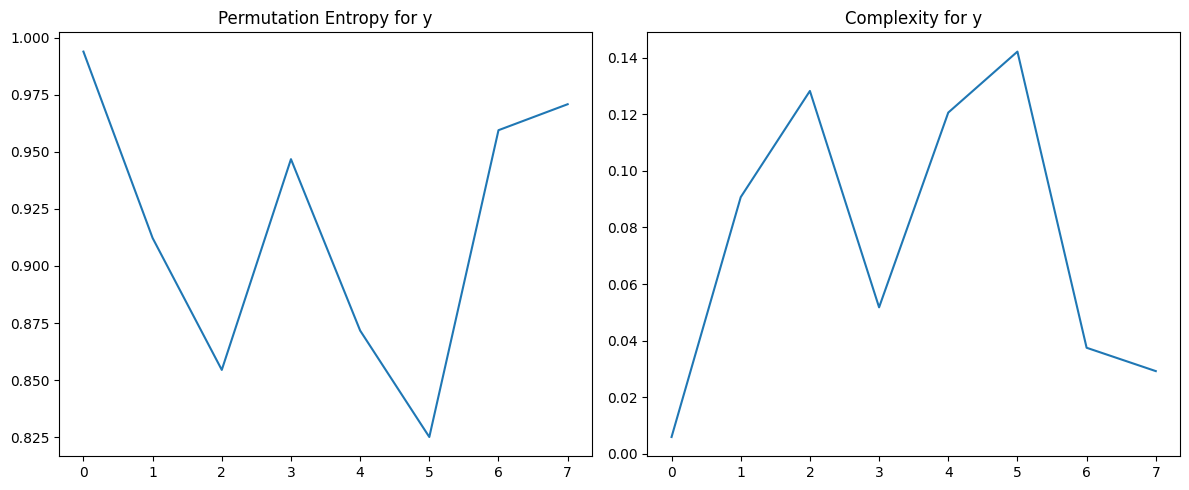

Starting Post Processing for df_sample_y
      Time       y       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.0036  0.066343             0.993914    0.005933      0
1    0.025 -0.0009  0.066343             0.993914    0.005933      0
2    0.050 -0.0019  0.066343             0.993914    0.005933      0
3    0.075  0.0006  0.066343             0.993914    0.005933      0
4    0.100 -0.0035  0.066343             0.993914    0.005933      0
..     ...     ...       ...                  ...         ...    ...
315  7.875 -0.0029  0.040976             0.970859    0.029228      0
316  7.900 -0.0010  0.040976             0.970859    0.029228      0
317  7.925  0.0001  0.040976             0.970859    0.029228      0
318  7.950 -0.0020  0.040976             0.970859    0.029228      0
319  7.975 -0.0018  0.040976             0.970859    0.029228      0

[320 rows x 6 columns]
Post Processing completed for df_sample_y


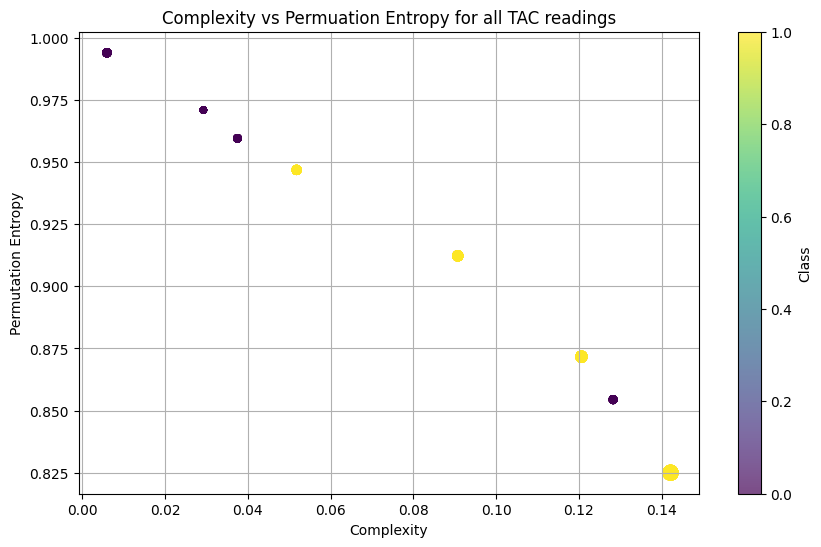

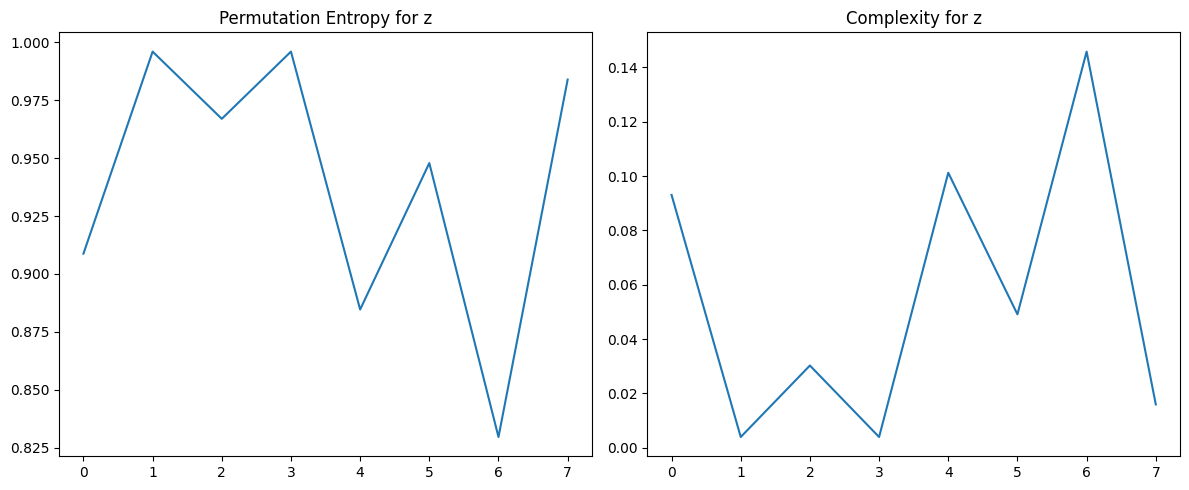

Starting Post Processing for df_sample_z
      Time       z       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0007  0.066343             0.908761    0.093062      0
1    0.025 -0.0002  0.066343             0.908761    0.093062      0
2    0.050 -0.0020  0.066343             0.908761    0.093062      0
3    0.075  0.0001  0.066343             0.908761    0.093062      0
4    0.100 -0.0009  0.066343             0.908761    0.093062      0
..     ...     ...       ...                  ...         ...    ...
315  7.875 -0.0056  0.040976             0.983933    0.015965      0
316  7.900 -0.0050  0.040976             0.983933    0.015965      0
317  7.925 -0.0048  0.040976             0.983933    0.015965      0
318  7.950 -0.0039  0.040976             0.983933    0.015965      0
319  7.975 -0.0039  0.040976             0.983933    0.015965      0

[320 rows x 6 columns]
Post Processing completed for df_sample_z


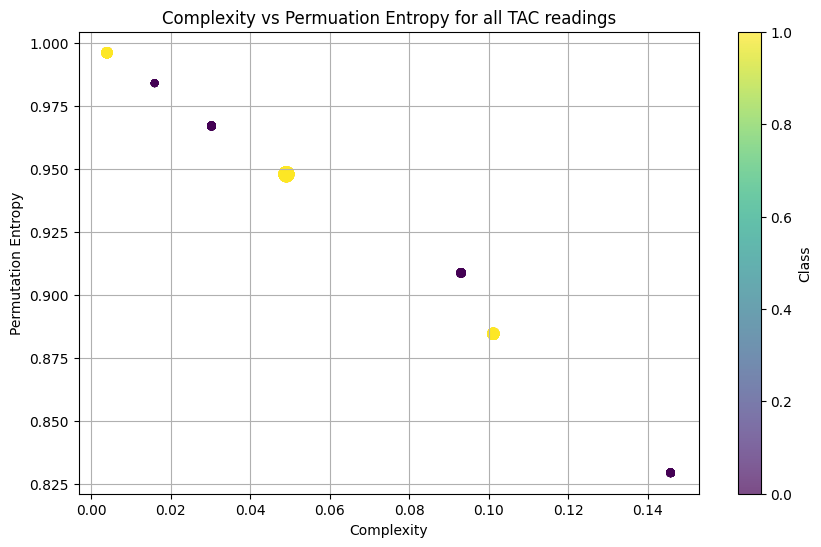

Plotting Scatter Plot


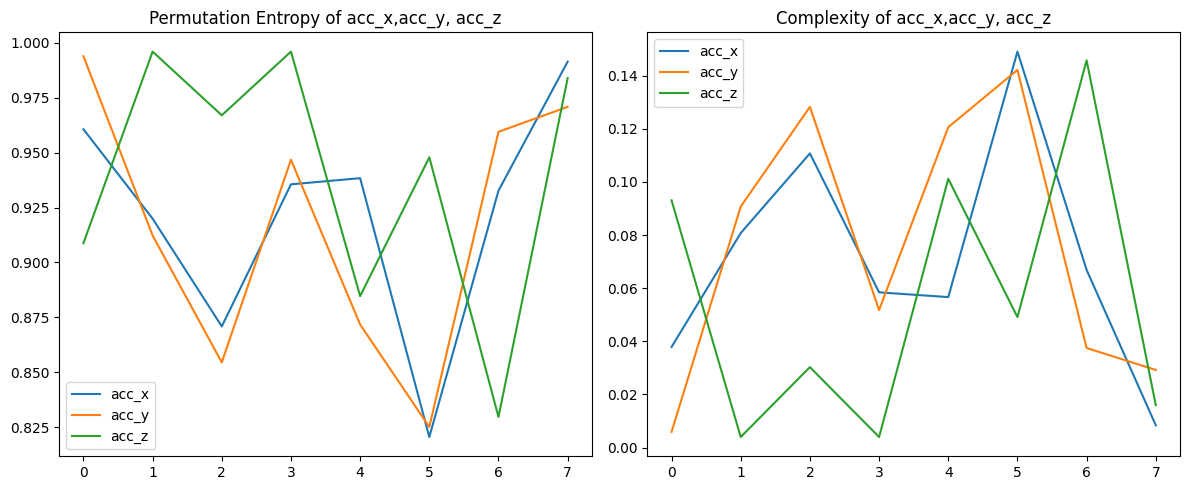

Graphs plotted successfully
###########################################################################################################


In [187]:
pid_name, pid = file_retrieval('MJ8002_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

11.) PID: PC6771

###########################################################################################################
File Retrieval started
PID:  PC6771
File Retrieval finished
PID filtering started
Total number of rows are:  762
PID filtering ended
Plotting time stamp vs dimension graph


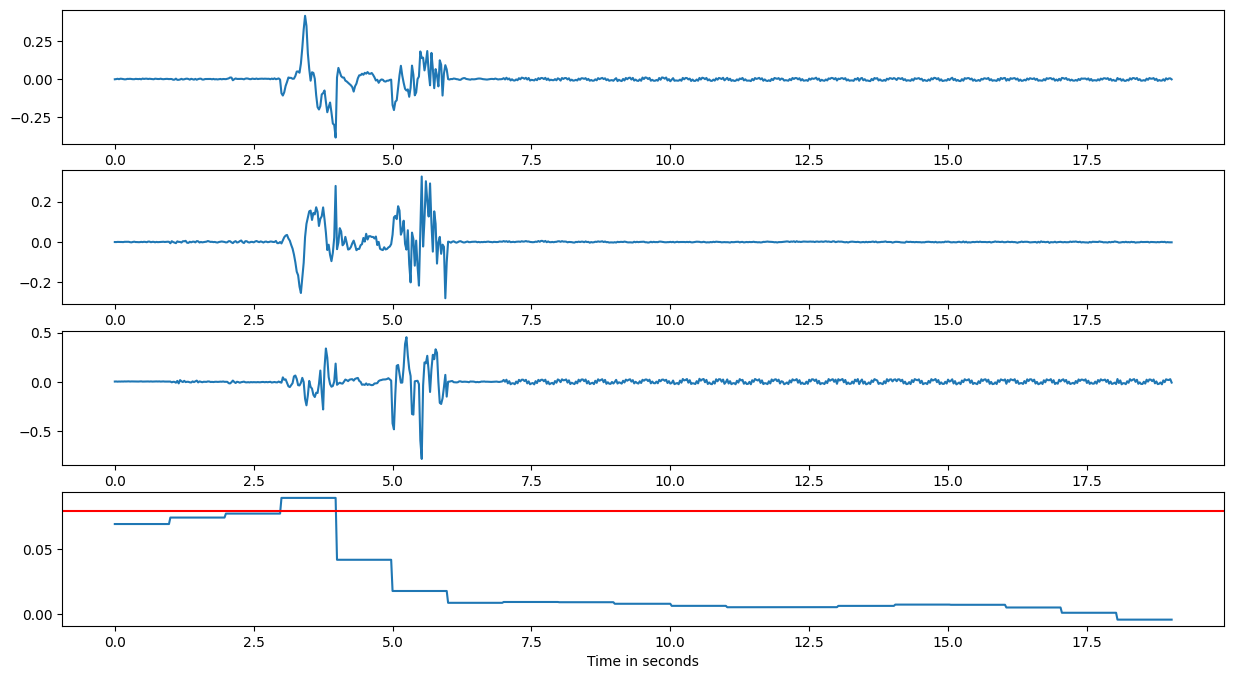

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [41, 41, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]


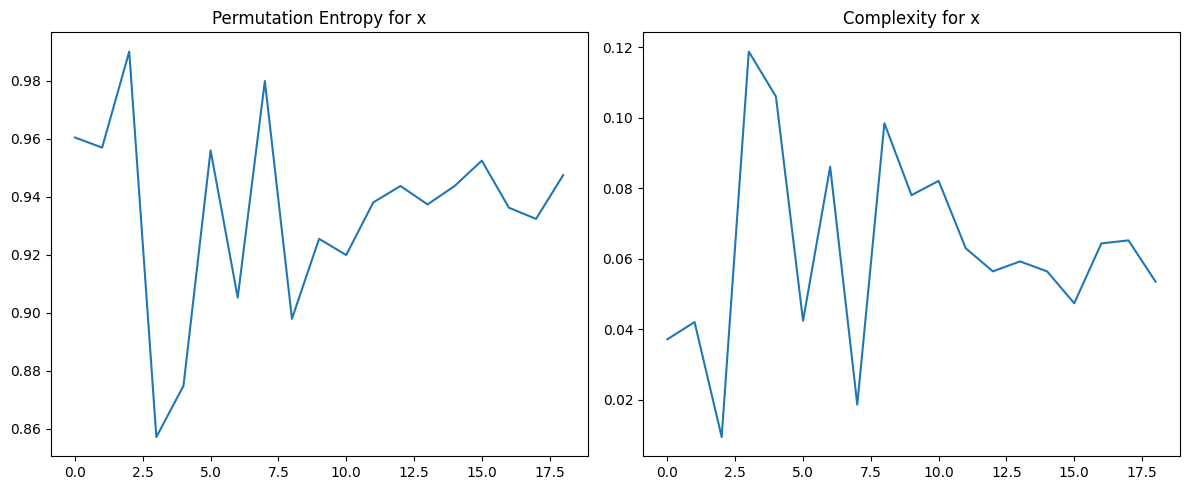

Starting Post Processing for df_sample_x
       Time       x       TAC  Permutation Entropy  Complexity  Class
0     0.000 -0.0012  0.069712             0.960345    0.037193      0
1     0.025 -0.0001  0.069712             0.960345    0.037193      0
2     0.050  0.0020  0.069712             0.960345    0.037193      0
3     0.075 -0.0006  0.069712             0.960345    0.037193      0
4     0.100  0.0025  0.069712             0.960345    0.037193      0
..      ...     ...       ...                  ...         ...    ...
757  18.925  0.0053 -0.004448             0.947378    0.053527      0
758  18.950 -0.0020 -0.004448             0.947378    0.053527      0
759  18.975  0.0042 -0.004448             0.947378    0.053527      0
760  19.000  0.0050 -0.004448             0.947378    0.053527      0
761  19.025 -0.0017 -0.004448             0.947378    0.053527      0

[762 rows x 6 columns]
Post Processing completed for df_sample_x


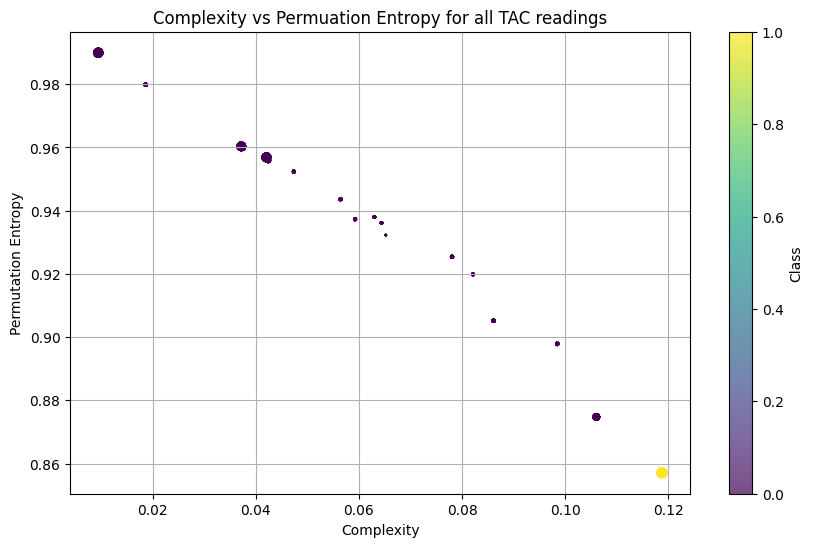

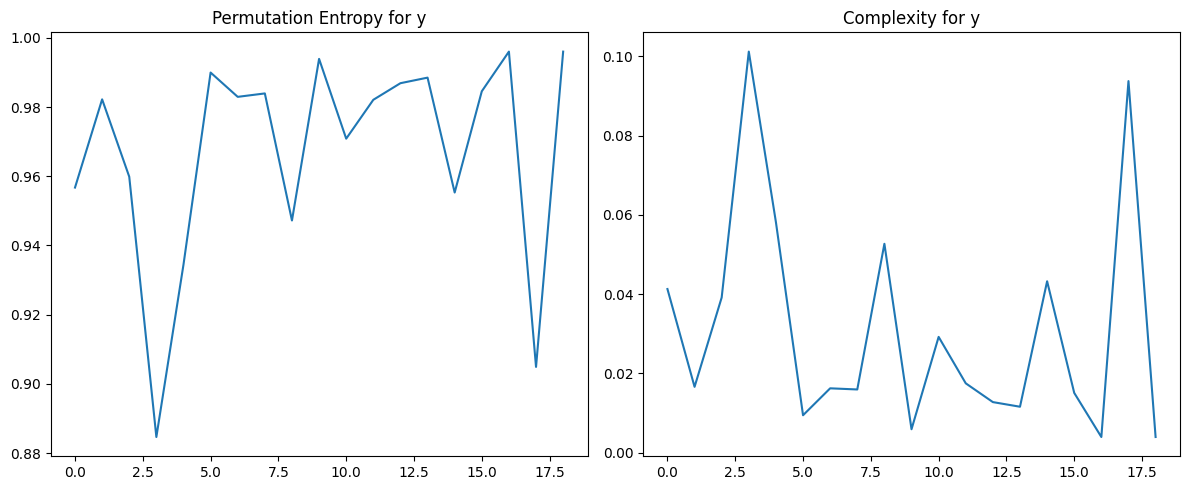

Starting Post Processing for df_sample_y
       Time       y       TAC  Permutation Entropy  Complexity  Class
0     0.000 -0.0008  0.069712              0.95673    0.041303      0
1     0.025 -0.0010  0.069712              0.95673    0.041303      0
2     0.050 -0.0002  0.069712              0.95673    0.041303      0
3     0.075 -0.0006  0.069712              0.95673    0.041303      0
4     0.100 -0.0006  0.069712              0.95673    0.041303      0
..      ...     ...       ...                  ...         ...    ...
757  18.925 -0.0028 -0.004448              0.99602    0.003974      0
758  18.950 -0.0011 -0.004448              0.99602    0.003974      0
759  18.975 -0.0021 -0.004448              0.99602    0.003974      0
760  19.000 -0.0021 -0.004448              0.99602    0.003974      0
761  19.025 -0.0022 -0.004448              0.99602    0.003974      0

[762 rows x 6 columns]
Post Processing completed for df_sample_y


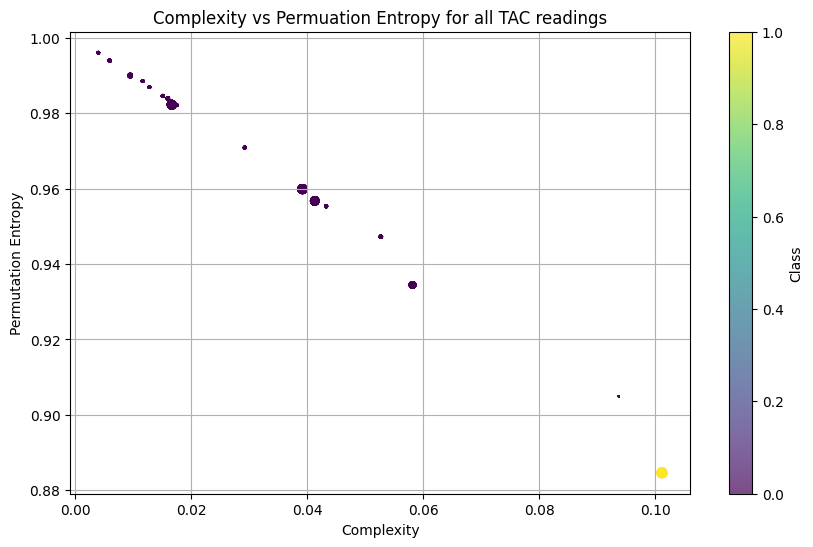

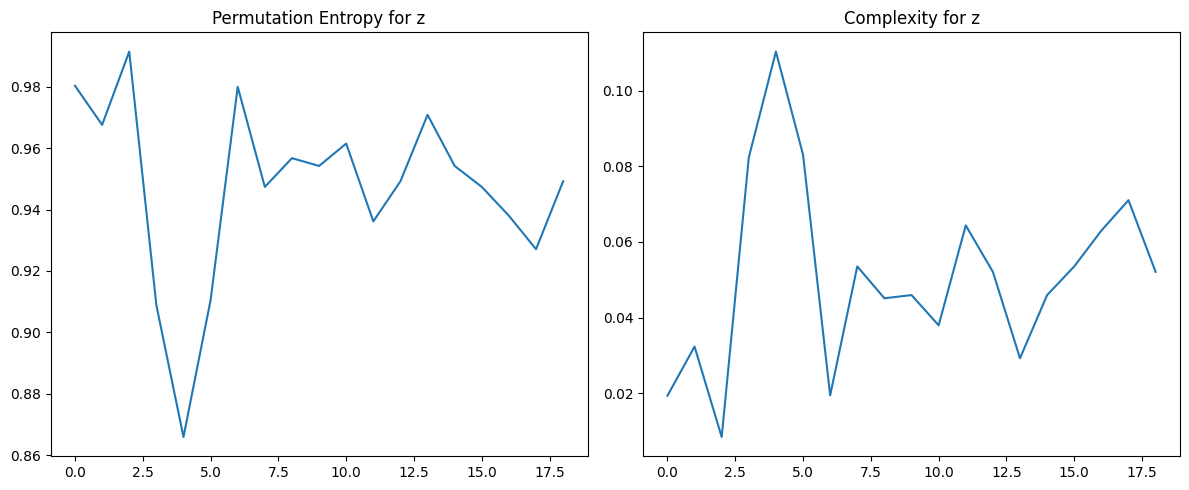

Starting Post Processing for df_sample_z
       Time       z       TAC  Permutation Entropy  Complexity  Class
0     0.000  0.0036  0.069712             0.980329    0.019329      0
1     0.025  0.0043  0.069712             0.980329    0.019329      0
2     0.050  0.0026  0.069712             0.980329    0.019329      0
3     0.075  0.0040  0.069712             0.980329    0.019329      0
4     0.100  0.0032  0.069712             0.980329    0.019329      0
..      ...     ...       ...                  ...         ...    ...
757  18.925  0.0264 -0.004448             0.949219    0.052104      0
758  18.950  0.0206 -0.004448             0.949219    0.052104      0
759  18.975  0.0190 -0.004448             0.949219    0.052104      0
760  19.000  0.0280 -0.004448             0.949219    0.052104      0
761  19.025 -0.0068 -0.004448             0.949219    0.052104      0

[762 rows x 6 columns]
Post Processing completed for df_sample_z


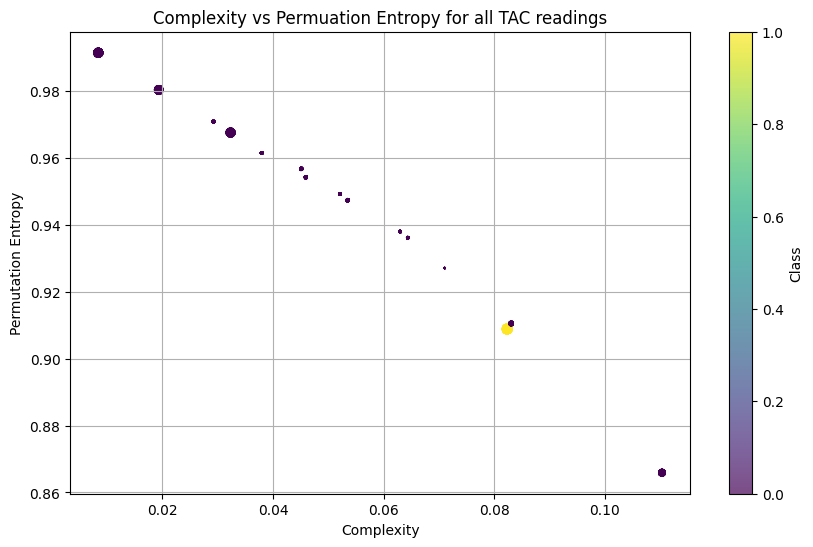

Plotting Scatter Plot


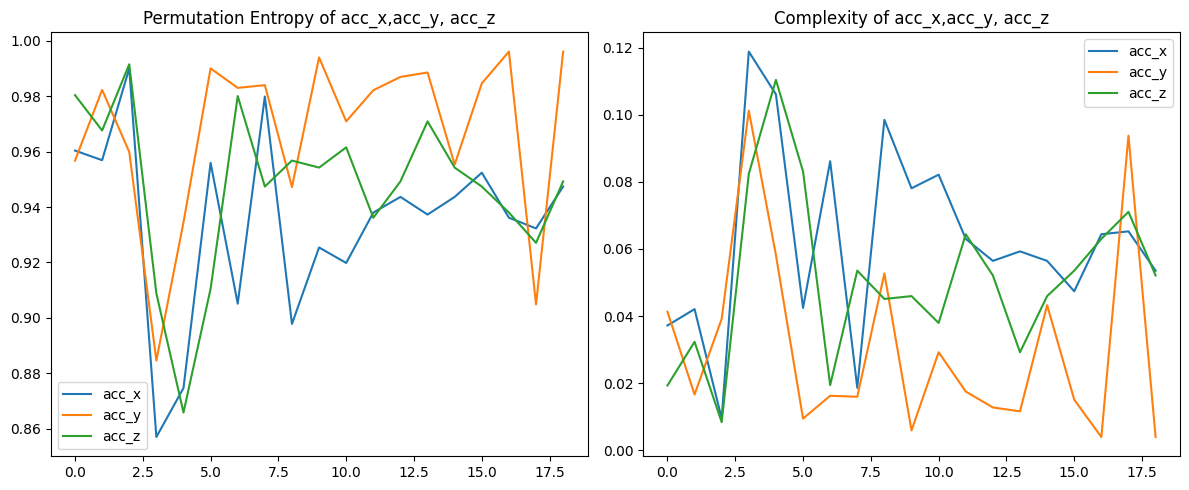

Graphs plotted successfully
###########################################################################################################


In [188]:
pid_name, pid = file_retrieval('PC6771_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

12.) PID: SA0297

###########################################################################################################
File Retrieval started
PID:  SA0297
File Retrieval finished
PID filtering started
Total number of rows are:  396
PID filtering ended
Plotting time stamp vs dimension graph


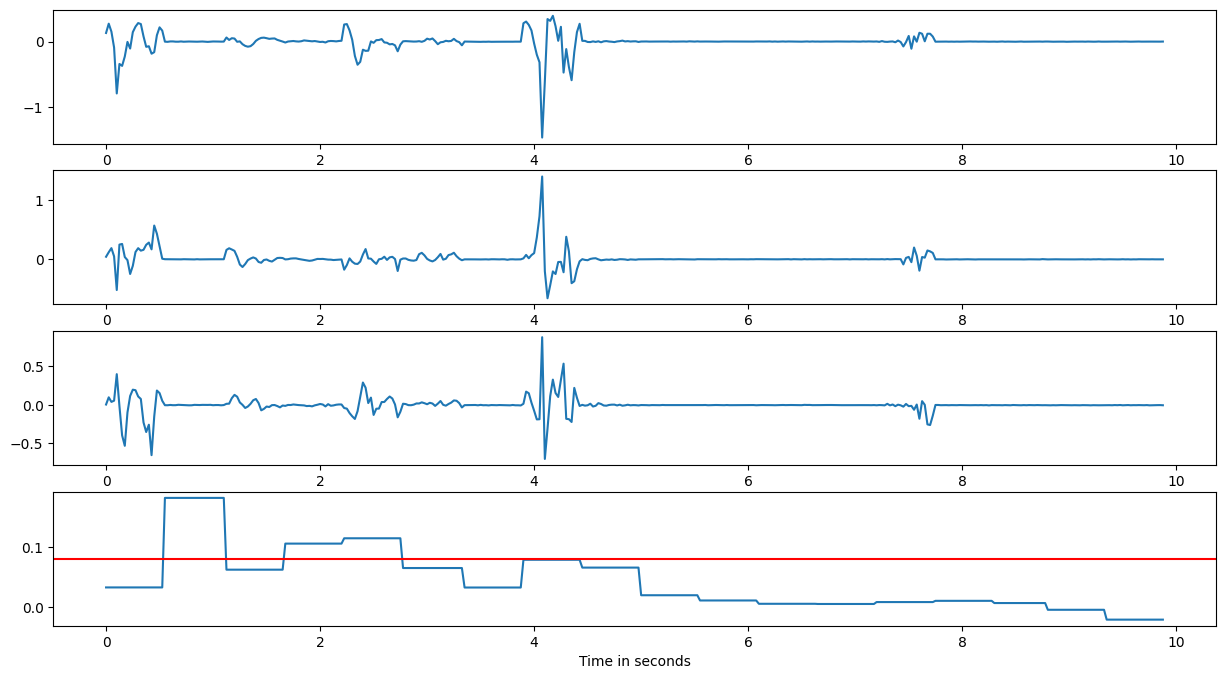

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 20]


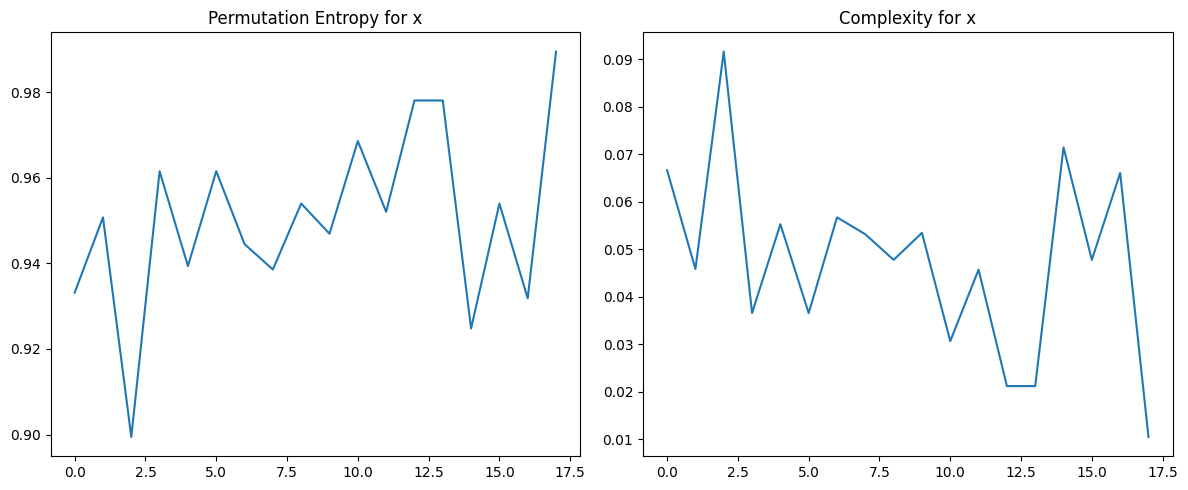

Starting Post Processing for df_sample_x
      Time       x       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.1312  0.032672             0.933142    0.066619      0
1    0.025  0.2734  0.032672             0.933142    0.066619      0
2    0.050  0.1514  0.032672             0.933142    0.066619      0
3    0.075 -0.0914  0.032672             0.933142    0.066619      0
4    0.100 -0.7935  0.032672             0.933142    0.066619      0
..     ...     ...       ...                  ...         ...    ...
391  9.775 -0.0012 -0.021275             0.989464    0.010436      0
392  9.800 -0.0025 -0.021275             0.989464    0.010436      0
393  9.825 -0.0012 -0.021275             0.989464    0.010436      0
394  9.850 -0.0012 -0.021275             0.989464    0.010436      0
395  9.875 -0.0000 -0.021275             0.989464    0.010436      0

[396 rows x 6 columns]
Post Processing completed for df_sample_x


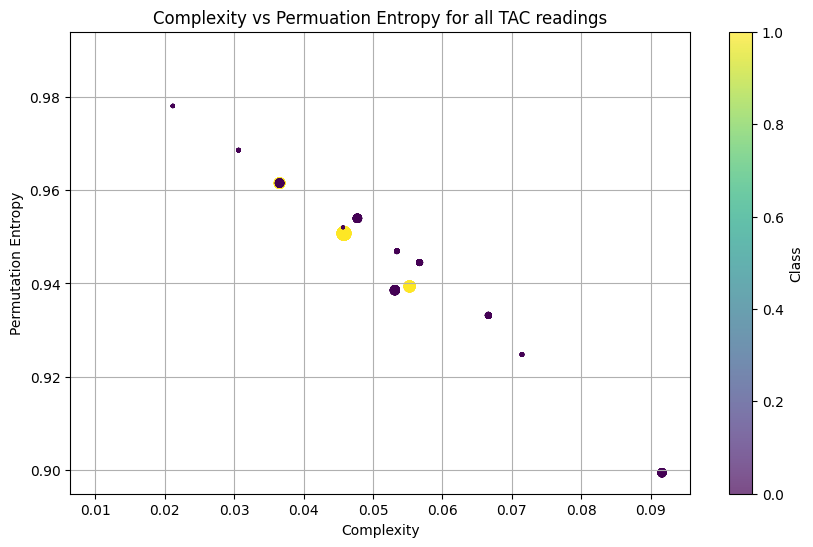

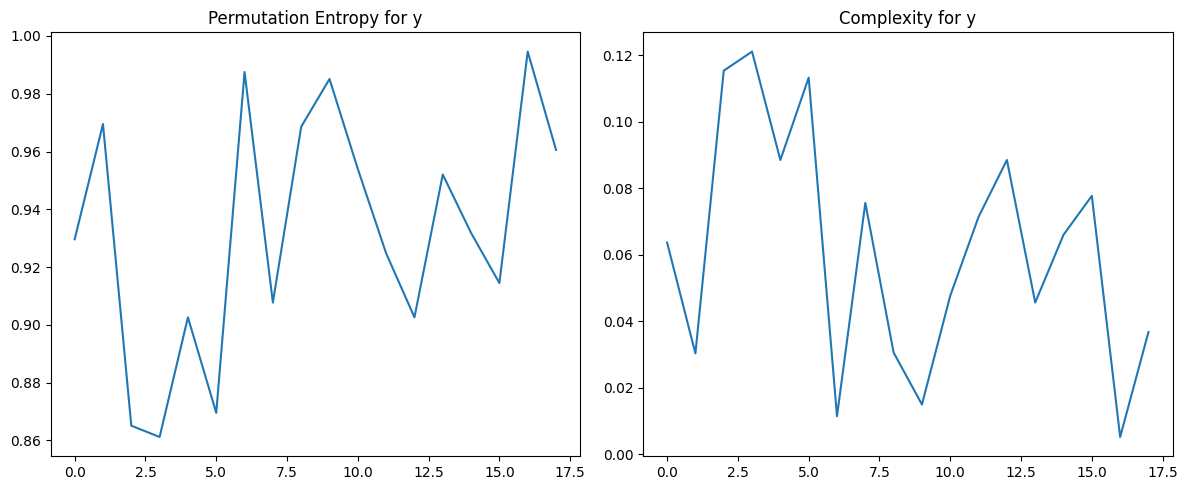

Starting Post Processing for df_sample_y
      Time       y       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.0432  0.032672             0.929630    0.063705      0
1    0.025  0.1197  0.032672             0.929630    0.063705      0
2    0.050  0.1886  0.032672             0.929630    0.063705      0
3    0.075  0.0496  0.032672             0.929630    0.063705      0
4    0.100 -0.5184  0.032672             0.929630    0.063705      0
..     ...     ...       ...                  ...         ...    ...
391  9.775  0.0006 -0.021275             0.960558    0.036820      0
392  9.800 -0.0006 -0.021275             0.960558    0.036820      0
393  9.825  0.0002 -0.021275             0.960558    0.036820      0
394  9.850 -0.0007 -0.021275             0.960558    0.036820      0
395  9.875 -0.0007 -0.021275             0.960558    0.036820      0

[396 rows x 6 columns]
Post Processing completed for df_sample_y


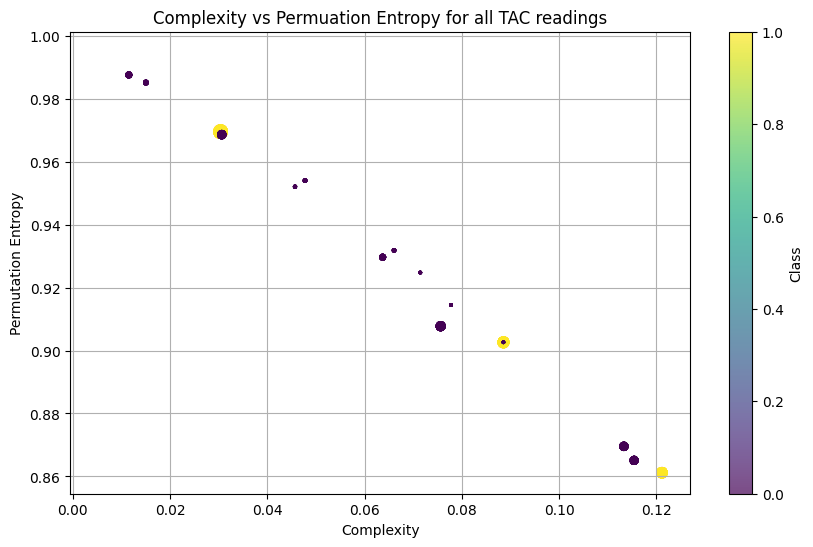

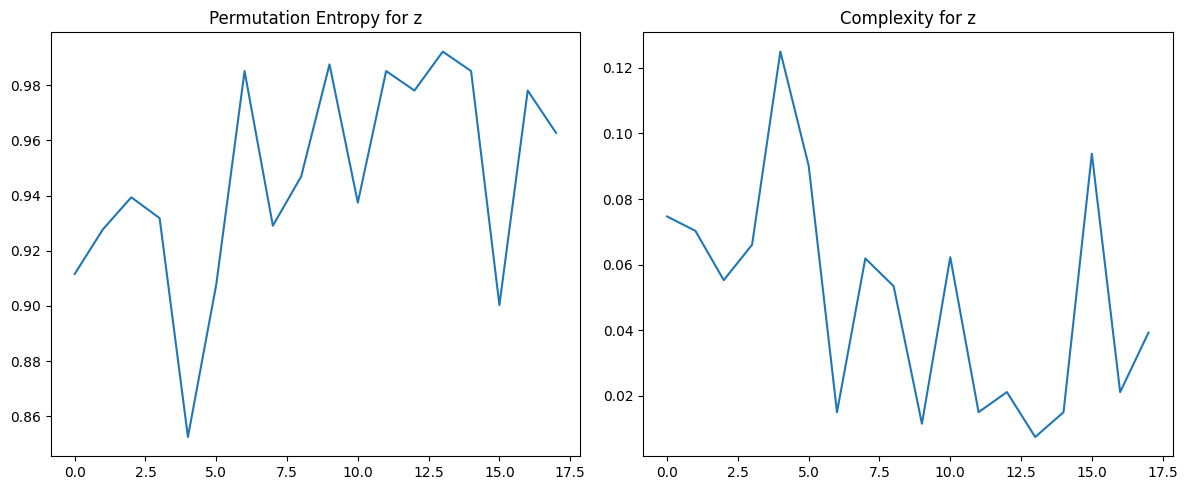

Starting Post Processing for df_sample_z
      Time       z       TAC  Permutation Entropy  Complexity  Class
0    0.000  0.0034  0.032672             0.911569    0.074679      0
1    0.025  0.0968  0.032672             0.911569    0.074679      0
2    0.050  0.0375  0.032672             0.911569    0.074679      0
3    0.075  0.0534  0.032672             0.911569    0.074679      0
4    0.100  0.3967  0.032672             0.911569    0.074679      0
..     ...     ...       ...                  ...         ...    ...
391  9.775 -0.0058 -0.021275             0.962704    0.039272      0
392  9.800 -0.0056 -0.021275             0.962704    0.039272      0
393  9.825 -0.0043 -0.021275             0.962704    0.039272      0
394  9.850 -0.0040 -0.021275             0.962704    0.039272      0
395  9.875 -0.0060 -0.021275             0.962704    0.039272      0

[396 rows x 6 columns]
Post Processing completed for df_sample_z


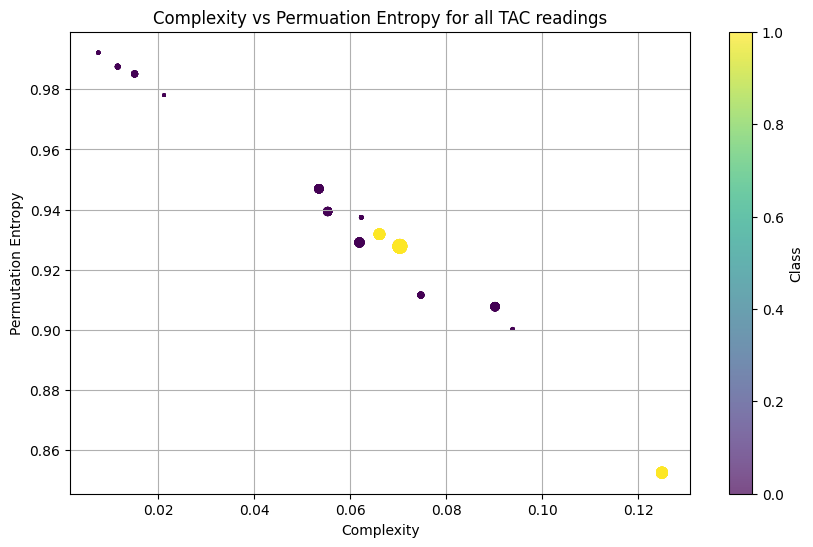

Plotting Scatter Plot


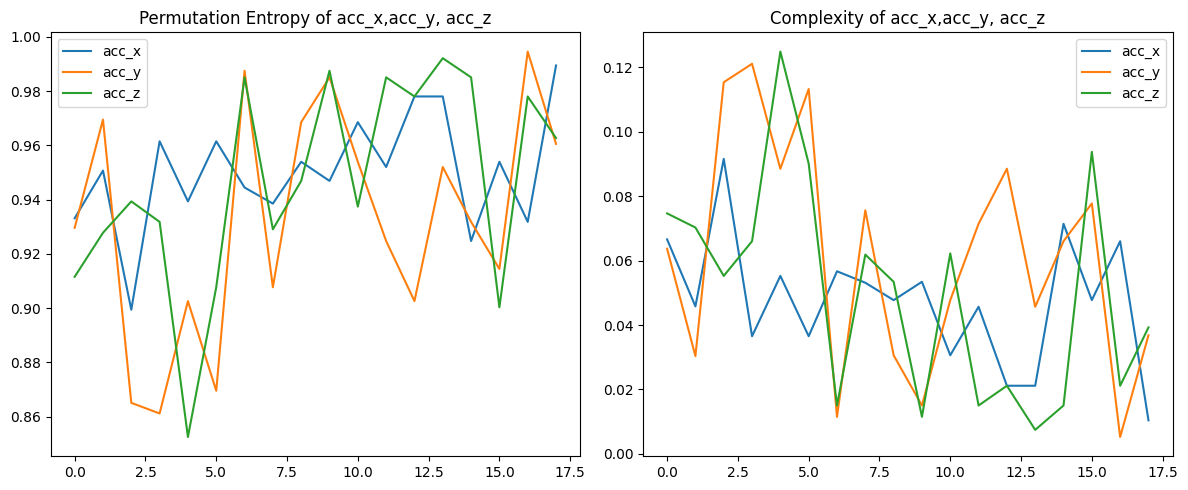

Graphs plotted successfully
###########################################################################################################


In [189]:
pid_name, pid = file_retrieval('SA0297_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

13.) PID: SF3079

###########################################################################################################
File Retrieval started
PID:  SF3079
File Retrieval finished
PID filtering started
Total number of rows are:  356
PID filtering ended
Plotting time stamp vs dimension graph


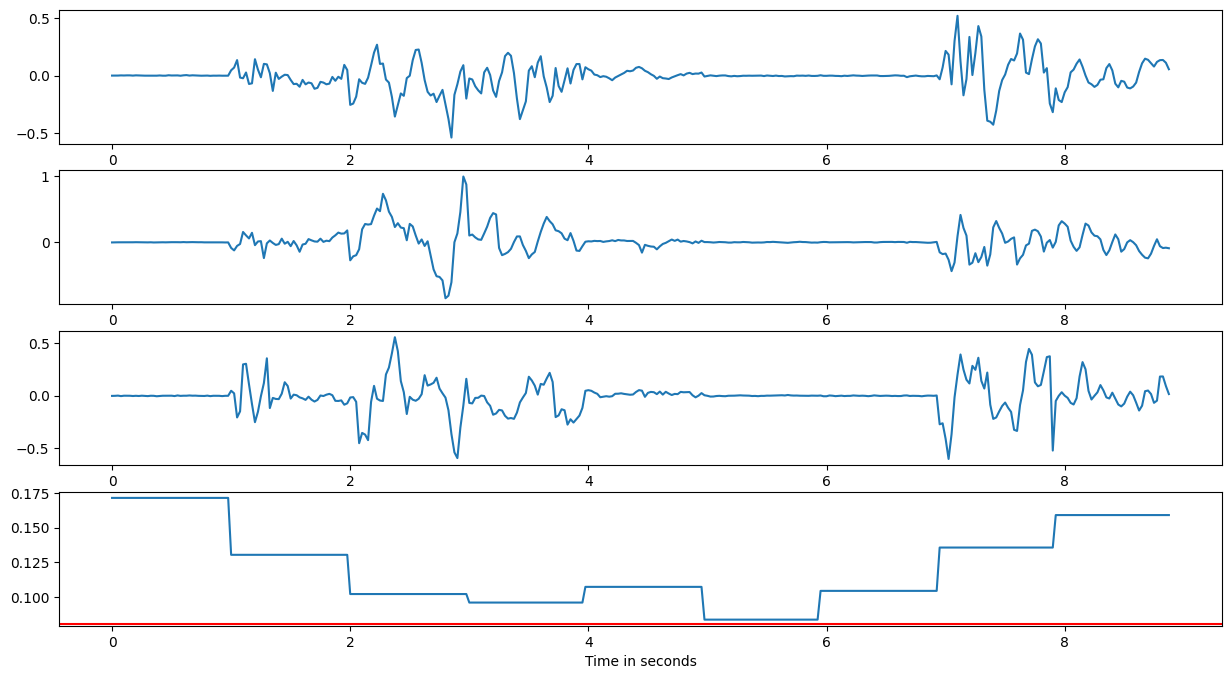

Plotting completed
Calculating permutation entropy and complexity
Plotting Graphs
Segment List:  [40, 40, 40, 40, 40, 39, 39, 39, 39]


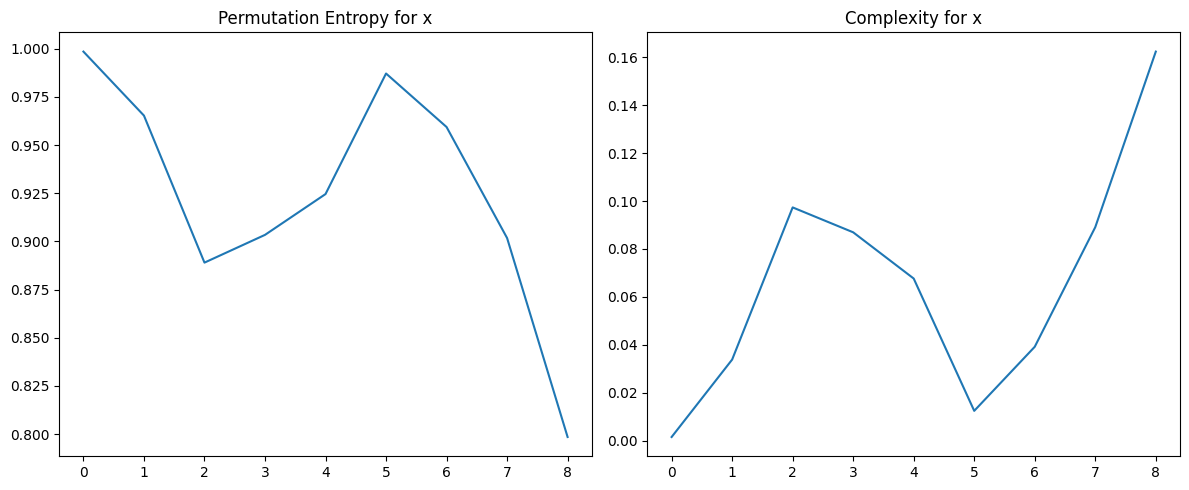

Starting Post Processing for df_sample_x
      Time       x       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0004  0.171436             0.998479    0.001487      1
1    0.025 -0.0007  0.171436             0.998479    0.001487      1
2    0.050 -0.0001  0.171436             0.998479    0.001487      1
3    0.075  0.0013  0.171436             0.998479    0.001487      1
4    0.100  0.0005  0.171436             0.998479    0.001487      1
..     ...     ...       ...                  ...         ...    ...
351  8.775  0.1188  0.159026             0.798506    0.162395      1
352  8.800  0.1342  0.159026             0.798506    0.162395      1
353  8.825  0.1356  0.159026             0.798506    0.162395      1
354  8.850  0.1117  0.159026             0.798506    0.162395      1
355  8.875  0.0551  0.159026             0.798506    0.162395      1

[356 rows x 6 columns]
Post Processing completed for df_sample_x


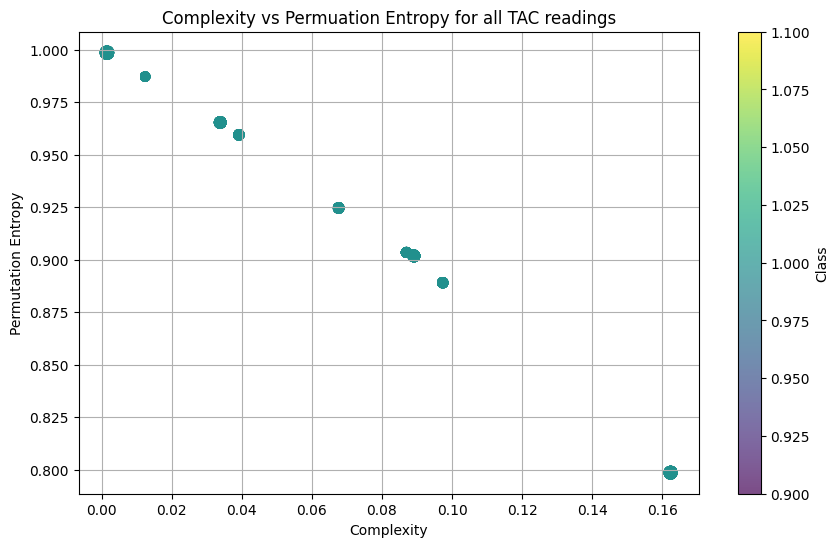

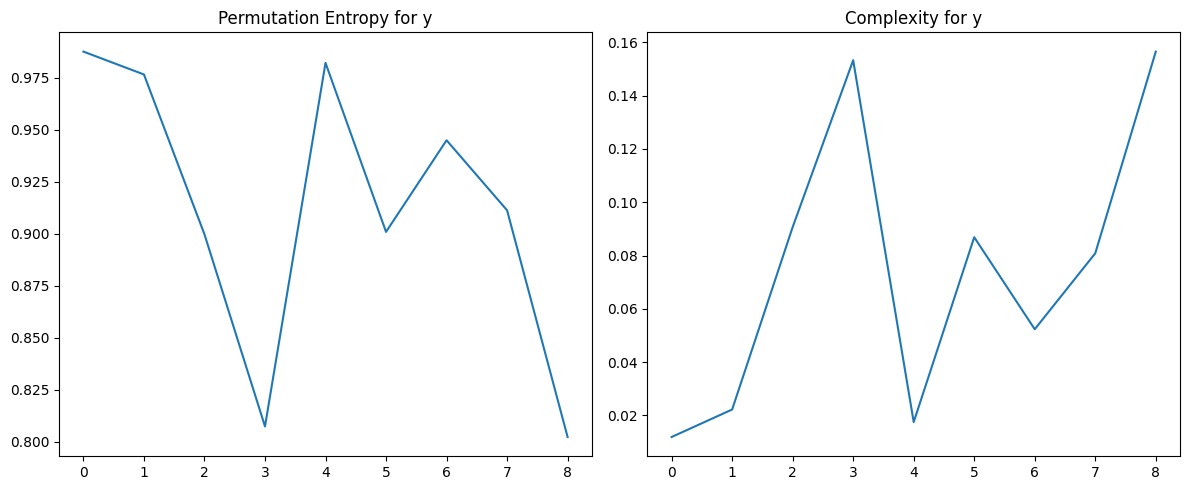

Starting Post Processing for df_sample_y
      Time       y       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0024  0.171436             0.987509    0.011908      1
1    0.025 -0.0008  0.171436             0.987509    0.011908      1
2    0.050 -0.0005  0.171436             0.987509    0.011908      1
3    0.075 -0.0006  0.171436             0.987509    0.011908      1
4    0.100  0.0000  0.171436             0.987509    0.011908      1
..     ...     ...       ...                  ...         ...    ...
351  8.775  0.0456  0.159026             0.802287    0.156495      1
352  8.800 -0.0594  0.159026             0.802287    0.156495      1
353  8.825 -0.0877  0.159026             0.802287    0.156495      1
354  8.850 -0.0822  0.159026             0.802287    0.156495      1
355  8.875 -0.0908  0.159026             0.802287    0.156495      1

[356 rows x 6 columns]
Post Processing completed for df_sample_y


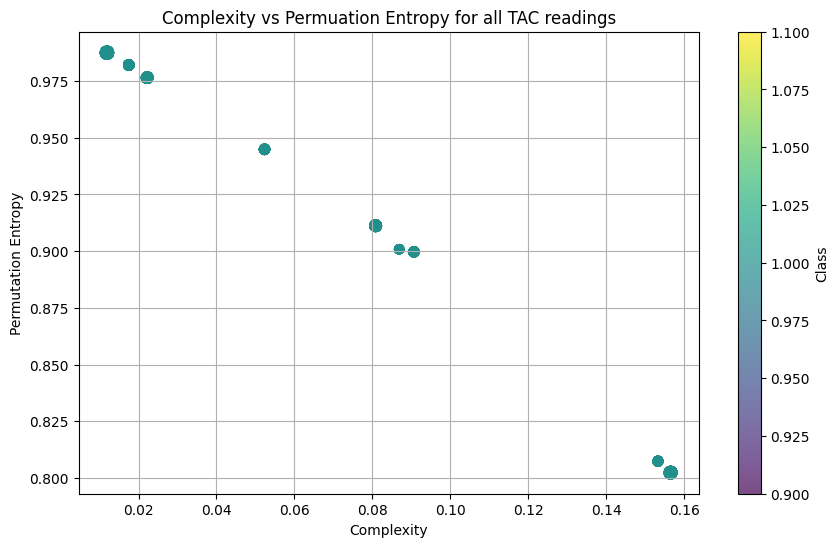

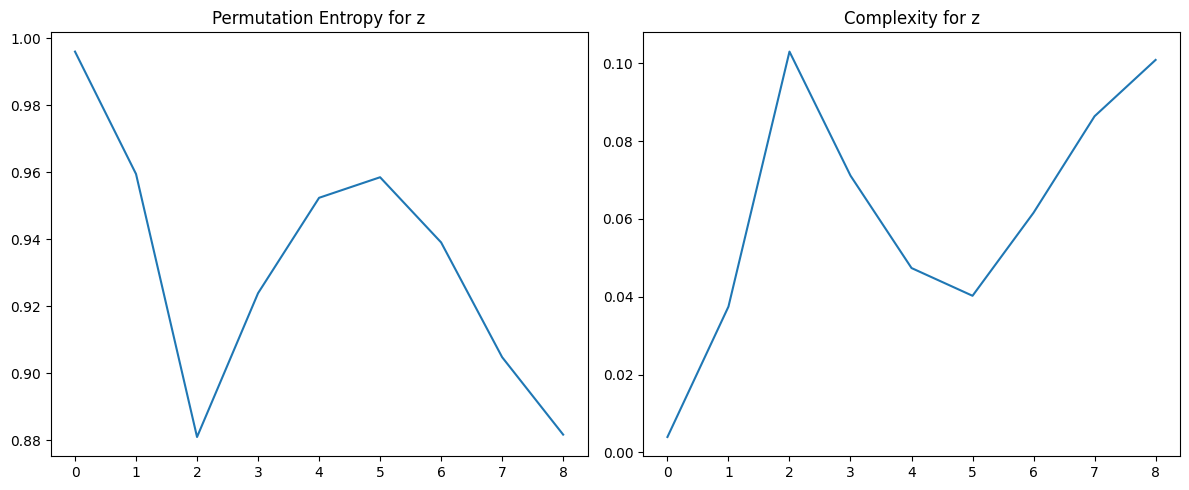

Starting Post Processing for df_sample_z
      Time       z       TAC  Permutation Entropy  Complexity  Class
0    0.000 -0.0026  0.171436             0.996020    0.003974      1
1    0.025 -0.0018  0.171436             0.996020    0.003974      1
2    0.050  0.0002  0.171436             0.996020    0.003974      1
3    0.075 -0.0044  0.171436             0.996020    0.003974      1
4    0.100 -0.0007  0.171436             0.996020    0.003974      1
..     ...     ...       ...                  ...         ...    ...
351  8.775 -0.0480  0.159026             0.881665    0.100869      1
352  8.800  0.1822  0.159026             0.881665    0.100869      1
353  8.825  0.1830  0.159026             0.881665    0.100869      1
354  8.850  0.0917  0.159026             0.881665    0.100869      1
355  8.875  0.0152  0.159026             0.881665    0.100869      1

[356 rows x 6 columns]
Post Processing completed for df_sample_z


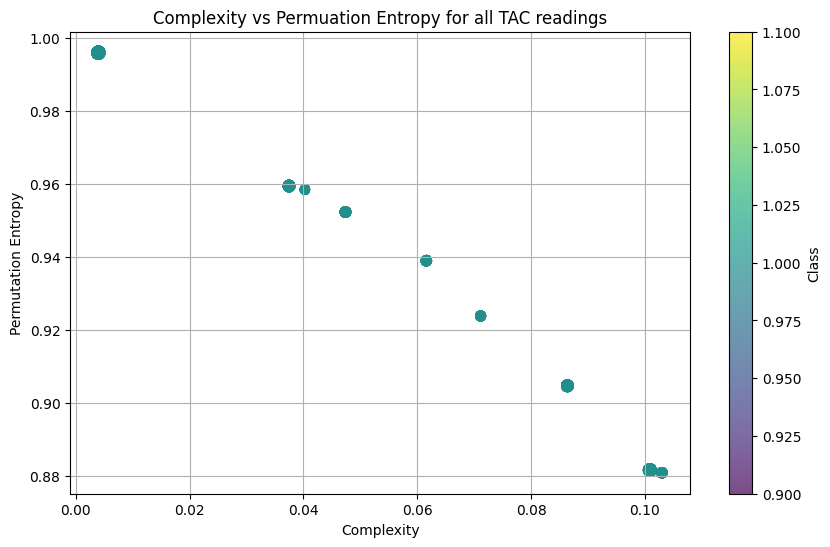

Plotting Scatter Plot


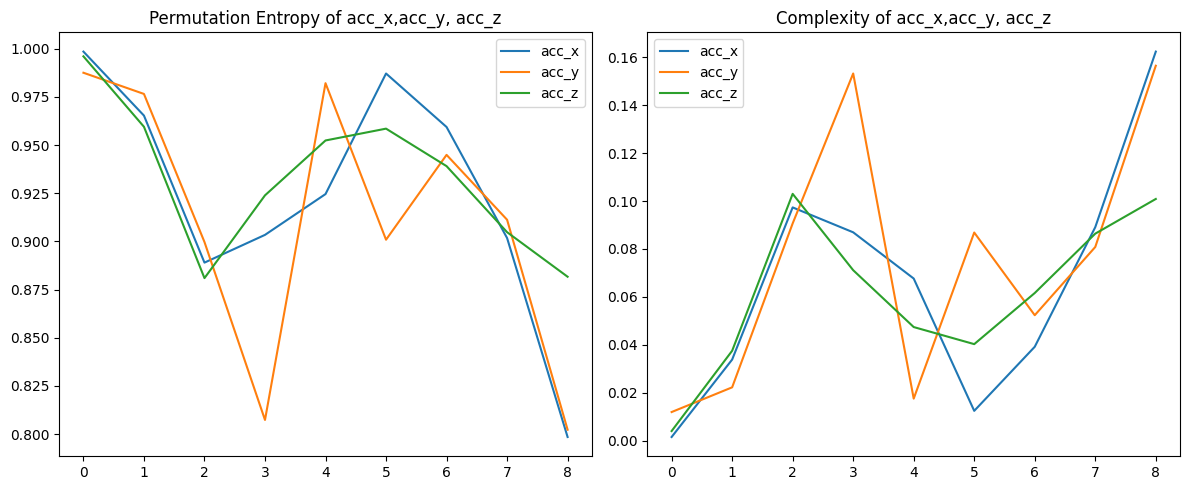

Graphs plotted successfully
###########################################################################################################


In [190]:
pid_name, pid = file_retrieval('SF3079_clean_TAC.csv')
merged_pid = pid_filter(pid, pid_name)
time = graph(merged_pid)
df_sample_x, df_sample_y, df_sample_z = length_of_segment(merged_pid)
pe_comp_calc(df_sample_x,df_sample_y,df_sample_z)

## **Future Scope**

1.) Refinement of Methods: As the project progresses, there is a scope to refine and optimize the permutation entropy and complexity methods for detecting heavy drinking behavior. This could involve exploring different parameter settings, algorithm variations, or ensemble techniques to enhance the accuracy and robustness of the classification.

2.) Feature Engineering: Continual exploration and experimentation with feature engineering techniques can be pursued to identify more informative features that contribute to the differentiation between heavy drinking and sober behavior. This could involve leveraging domain knowledge to create novel features or applying advanced feature selection methods.

3.) Model Enhancement: Further development of machine learning models can be explored to improve the classification performance. This includes experimenting with different algorithms beyond basic logistic regression, such as ensemble methods (e.g., Random Forests, Gradient Boosting), deep learning models, or hybrid approaches.

4.) Real-time Monitoring and Intervention: The findings from this study could pave the way for developing real-time monitoring systems or mobile applications that use accelerometer data and signal analysis techniques to provide feedback or interventions for individuals engaging in heavy drinking behaviors.

5.) Longitudinal Studies and Generalization: Consider extending the analysis to longitudinal studies to track behavioral patterns over time and generalize the findings to broader populations or settings beyond bar-crawl events. This could involve collaborating with researchers in public health or addiction studies.

6.) Interdisciplinary Collaboration: Explore interdisciplinary collaborations with experts in psychology, public health, or behavioral sciences to gain deeper insights into the factors influencing heavy drinking behavior and to translate research findings into effective intervention strategies.

7.) Validation and Deployment: Validate the effectiveness of the developed methods and models through external validation datasets or field trials. Successful validation can lead to the deployment of scalable solutions for detecting and intervening in heavy drinking behaviors in real-world scenarios.

8.) Ethical Considerations and Privacy: Address ethical considerations and privacy concerns associated with deploying behavioral analysis systems. Develop frameworks for responsible data collection, usage, and informed consent in the context of behavioral monitoring and intervention.

9.) By pursuing these future scopes, the project can contribute significantly to advancing methods for detecting and understanding alcohol-related behaviors using computational approaches, ultimately leading to meaningful impacts on public health and intervention strategies.

## **Conclusion**

In this project, we embarked on a comprehensive exploration and analysis of the "Bar Crawl: Detecting Heavy Drinking" dataset sourced from the UCI Machine Learning Repository. Our primary goal was to investigate the effectiveness of permutation entropy and complexity methods in differentiating heavy drinking episodes from sober behavior.

The initial phase of the project involved thorough data exploration, preprocessing, and feature analysis to understand the dataset's nature and underlying characteristics. We gained valuable insights into the recorded factors and variables associated with participants engaged in bar-crawl events.

Through the application of permutation entropy and complexity techniques, which are advanced methods in time series analysis and signal processing, we aimed to assess the irregularity and complexity of data patterns related to drinking behaviors. Our investigation focused on evaluating the reliability and applicability of these methods in accurately classifying instances of heavy drinking versus sobriety.

The findings from our study contribute to the advancement of computational machine learning approaches and signal analysis techniques for behavioral analysis and intervention related to alcohol consumption. Our structured analysis pipeline integrated data preprocessing, feature engineering, model development, and performance evaluation to achieve the research objectives outlined.

Moving forward, the outcomes of this study have the potential to inform future research on alcohol-related behaviors and contribute to the development of data-driven approaches for detecting and understanding drinking behaviors in various settings.

This project underscores the importance of leveraging machine learning and signal processing techniques to address real-world challenges associated with heavy drinking detection and behavioral analysis, ultimately aiming to contribute to public health initiatives and interventions.

By leveraging the detailed dataset and sophisticated analytical methods, we aim to advance our understanding of alcohol-related behaviors and pave the way for more effective strategies for intervention and prevention in this domain.

This conclusion encapsulates the project's objectives, methodologies, and potential implications, highlighting the significance of the research in addressing alcohol-related behavioral challenges through data-driven approaches.